In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300

In [2]:
import scipy.sparse as sp

In [196]:
class StimulationSequence:
    def __init__(self, N, N_patterns = 1300, N_pattern_repeats = 3, Iscale = 1000, stimulation_period = 15, N_stimulated = 3, start_step = 5, end_step = 7):
        self.stimulation_period = stimulation_period
        self.N_patterns = N_patterns
        self.N_pattern_repeats = N_pattern_repeats
        self.U = np.zeros([N, N_patterns])
        for i in range(N_patterns):
            self.U[np.random.choice(range(N), N_stimulated), i] = 1
        I_presentations = np.ones([N_patterns, N_pattern_repeats]) * np.arange(N_patterns)[:,None]
        self.I_stimulationPattern = np.random.choice(I_presentations.ravel(), N_patterns * N_pattern_repeats, replace=False)
        self.I_stimulation = np.zeros([N_patterns, stimulation_period * N_patterns * (N_pattern_repeats + 1)])
        self.I_stimulation_start = np.zeros([N_patterns * N_pattern_repeats])
        for t, pattern in enumerate(self.I_stimulationPattern):
            self.I_stimulation[int(pattern), t * stimulation_period + start_step : t * stimulation_period + end_step] = Iscale
            self.I_stimulation_start[t] = t * stimulation_period + start_step
            
    def return_input_current(self, t):
        return self.U.dot(self.I_stimulation[:,t]).T[:,None]

class SNN:
    def __init__(self, Ncells = 100, g = 1, rank_dim = 15, noise = 1, leak = 0.1, Catau = 3, Itau = 1, resetvoltage = 0.1, threshold_voltage = 6, connection_density = 0.2):
        self.g = g
        self.N = Ncells
        self.noise = noise
        self.leak = leak
        self.Catau = Catau
        self.Itau = Itau
        self.resetvoltage = resetvoltage
        self.v = np.random.normal(0, 1, [self.N, 1])
        self.I = np.abs(np.random.normal(0, 1, [self.N, 1]))
        self.Ca = np.abs(np.random.normal(0, 1, [self.N, 1]))
        self.v0 = self.v.copy()
        self.I0 = self.I.copy()
        self.Ca0 = self.Ca.copy()

        # default W random matrix
        # self.W = np.random.normal(0, g, [Ncells, Ncells])

        sparse_vectors_u = []
        # Generate sparse vectors u_i
        for _ in range(rank_dim):
            random_sparse_vector = sp.rand(Ncells, 1, density = connection_density).toarray().flatten()
            rescale_random_sparse_vector = random_sparse_vector.copy()
            rescale_random_sparse_vector[random_sparse_vector != 0] = random_sparse_vector[random_sparse_vector != 0]* 2 - 1 
            #rescale_random_sparse_vector = np.random.randn(Ncells)
            sparse_vectors_u.append(rescale_random_sparse_vector * self.g)

        sparse_vectors_v = []
        # Generate sparse vectors v_i
        for _ in range(rank_dim):
            random_sparse_vector = sp.rand(Ncells, 1, density = connection_density).toarray().flatten()
            rescale_random_sparse_vector = random_sparse_vector.copy()
            rescale_random_sparse_vector[random_sparse_vector != 0] = random_sparse_vector[random_sparse_vector != 0]* 2 - 1 
            #rescale_random_sparse_vector = np.random.randn(Ncells)
            sparse_vectors_v.append(rescale_random_sparse_vector * self.g)

        # Compute outer products of sparse vectors and sum them up
        sum_outer_products = np.zeros((Ncells, Ncells))
        for u, v in zip(sparse_vectors_u, sparse_vectors_v):
            sum_outer_products += np.outer(u, v)

        self.W = sum_outer_products - np.diag(np.diag(sum_outer_products))
        self.T = threshold_voltage
        
        self.dt = 0.05
        self.stim_dt = 0.005
        self.res = 'high'
        self.numsteps = 20
        
        self.eval_inputs = None

    def nonlin(self):
        return self.v > self.T

    def runsimulation(self, numsteps = 1000, Iscale = 1000, dt = 0.05, stim_dt = 0.005, bias = 1, res='low'):
        self.numsteps = numsteps
        self.stim = StimulationSequence(self.N, Iscale = Iscale)
        steps_per_measurement = int(dt / stim_dt)
        vall = np.zeros([self.N, numsteps])
        Ca_all = np.zeros(vall.shape)
        Spikes_all = np.zeros(vall.shape)
        Stimulation_all = np.zeros(vall.shape)
        if res == 'high':
            vall_full = np.zeros([self.N, numsteps * steps_per_measurement])
            Ca_all_full = np.zeros(vall_full.shape)
            Spikes_all_full = np.zeros(vall_full.shape)
            Stimulation_all_full =np.zeros(vall_full.shape)
        for t in range(numsteps):
            for ss in range(steps_per_measurement):
                spike = self.nonlin()
                if ss ==0:
                    s = spike
                else:
                    s[spike] = True
                self.vold = np.copy(self.v)
                #print(self.stim.U.dot(self.stim.I_stimulation[:,t]))
                self.v = self.v + stim_dt * (-self.leak * self.v + self.W.dot(spike) + self.stim.U.dot(self.stim.I_stimulation[:,t]).T[:,None] + np.random.normal(bias, self.noise, self.v.shape))
                self.v[self.vold > self.T] = self.resetvoltage
                self.I[spike] += 1
                self.I = self.I - stim_dt * (self.I / self.Itau)
                self.Ca += self.I
                self.Ca = self.Ca - stim_dt * (self.Ca / self.Catau)
                if res == 'high':
                    vall_full[:,t*steps_per_measurement + ss] = self.v.ravel()
                    Ca_all_full[:,t*steps_per_measurement + ss] = self.Ca.ravel()
                    Spikes_all_full[:,t*steps_per_measurement + ss] = s.ravel()
                    Stimulation_all_full[:,t*steps_per_measurement + ss] = self.stim.U.dot(self.stim.I_stimulation[:,t]).T.ravel()
            vall[:,t] = self.v.ravel()
            Ca_all[:,t] = self.Ca.ravel()
            Spikes_all[:,t] = s.ravel()
            Stimulation_all[:,t] = self.stim.U.dot(self.stim.I_stimulation[:,t]).T.ravel()
        if res == 'high':
            return vall, Ca_all, Spikes_all, Stimulation_all, vall_full, Ca_all_full, Spikes_all_full, Stimulation_all_full
        else:
            return vall, Ca_all, Spikes_all, Stimulation_all
        
    def runsimulation2(self, u, Iscale = 1000, bias = 1):
        steps_per_measurement = int(self.dt / self.stim_dt)
        vall = np.zeros([self.N, self.numsteps])
        Ca_all = np.zeros(vall.shape)
        Spikes_all = np.zeros(vall.shape)
        Stimulation_all = np.zeros(vall.shape)
        for t in range(self.numsteps):
            for ss in range(steps_per_measurement):
                spike = self.nonlin()
                if ss ==0:
                    s = spike
                else:
                    s[spike] = True
                self.vold = np.copy(self.v)
                if t == 5:
                    self.v = self.v + self.stim_dt * (-self.leak * self.v + self.W.dot(spike) + u + np.random.normal(bias, self.noise, self.v.shape))
                else:
                    self.v = self.v + self.stim_dt * (-self.leak * self.v + self.W.dot(spike) + np.random.normal(bias, self.noise, self.v.shape))
                self.v[self.vold > self.T] = self.resetvoltage
                self.I[spike] += 1
                self.I = self.I - self.stim_dt * (self.I / self.Itau)
                self.Ca += self.I
                self.Ca = self.Ca - self.stim_dt * (self.Ca / self.Catau)
            vall[:,t] = self.v.ravel()
            Ca_all[:,t] = self.Ca.ravel()
            Spikes_all[:,t] = s.ravel()
            if t == 5:
                Stimulation_all[:,t] = u.flatten()
        return vall, Ca_all, Spikes_all, Stimulation_all
    

    def reset(self):
        self.v = self.v0.copy()
        self.I = self.I0.copy()
        self.Ca = self.Ca0.copy()


    def plotresults(self, vall, Ca_all, Spikes_all, Stimulation_all, plotwindow = 99, plotstart = 900):
        plt.figure(figsize = [15,15])
        plt.subplot(411)
        plt.imshow(Spikes_all[:, plotstart : plotstart + plotwindow], aspect='auto', cmap='seismic')
        plt.ylabel('Spikes')
        plt.colorbar()
        plt.subplot(412)
        plt.imshow(vall[:, plotstart : plotstart + plotwindow], aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.ylabel('Mem V')
        plt.subplot(413)
        plt.imshow(Ca_all[:, plotstart : plotstart + plotwindow], aspect='auto', cmap='bone')
        plt.colorbar()
        plt.xlabel('time')
        plt.ylabel('Ca')
        plt.subplot(414)
        plt.imshow(self.stim.U.dot(self.stim.I_stimulation)[:, 0:self.numsteps][:, plotstart : plotstart + plotwindow], aspect='auto', cmap='jet')
        plt.ylabel('Stim')
        plt.colorbar()
        plt.show()
    
    def get_snn_observation(self, u, onestep=True):
#         self.v = np.zeros(self.v.shape)
#         self.I = np.zeros(self.I.shape)
#         self.Ca = np.zeros(self.Ca.shape)
#         self.v = np.random.normal(0, 1, [self.N, 1])
#         self.I = np.abs(np.random.normal(0, 1, [self.N, 1]))
#         self.Ca = np.abs(np.random.normal(0, 1, [self.N, 1]))
#         self.v = self.v0.copy()
#         self.I = self.I0.copy()
#         self.Ca = self.Ca0.copy()
        
        _, Ca, _, inputs = self.runsimulation2(u[:,None])
        if onestep:
            x0 = np.sum(Ca[:,0:5], axis=1)
            x1 = np.sum(Ca[:,6:], axis=1)
            return x1, x0, u
        else:
            return Ca, inputs
        
    def get_eval(self, max_on=5, num_inputs=1000):
        if self.eval_inputs is None:
            self.eval_inputs = np.zeros((num_inputs, self.N))
            self.x0 = np.zeros((num_inputs, self.N))
            self.x1 = np.zeros((num_inputs, self.N))
            for i in range(num_inputs):
                u = np.zeros(self.N)
                idx = np.random.choice(range(self.N), size=max_on, replace=False)
                u[idx] = 1.0
                self.eval_inputs[i,:] = u
                x1_, x0_, _ = self.get_snn_observation(u, onestep=True)
                self.x0[i,:] = x0_
                self.x1[i,:] = x1_
        return self.x1.copy(), self.x0.copy(), self.eval_inputs.copy()

In [347]:
snn = SNN(Ncells=30, rank_dim=2, g=25, noise=1, leak=0.1, Catau=0.2, Itau=0.1, resetvoltage=0.1, threshold_voltage=10)
u = np.zeros(30)
u[1] = 1
y, x, u = snn.get_snn_observation(u)
print(y.shape)

116.93581395521228
(30,)


In [89]:
trial_len = 20
pre_stim_step = 5
post_stim_step = 8
def generate_data(g = 1, Iscale = 3, Catau = 1, Itau = 0.1, noise = 10, threshold_voltage = 3):
    snn = SNN(Ncells = 30, rank_dim=2, g = g, noise = noise, leak = 0.1, Catau = Catau, Itau = Itau, resetvoltage = 0.1, threshold_voltage = threshold_voltage)
    v_all, Ca_all, Spikes_all, Stimulation_all, v_all_full, Ca_all_full, Spikes_all_full, Stimulation_all_full = snn.runsimulation(numsteps = 60020, Iscale = Iscale, res='high')
    snn.plotresults(v_all, Ca_all, Spikes_all, Stimulation_all)
    num_neurons = Ca_all.shape[0]
    I_pattern = snn.stim.I_stimulationPattern
    num_trials = snn.stim.I_stimulation_start.shape[0]
    F_vis_raw = np.zeros((num_trials, trial_len, num_neurons))
    v_vis = np.zeros((num_trials, trial_len, num_neurons))
    spik_vis = np.zeros((num_trials, trial_len, num_neurons))
    input_vis = np.zeros((num_trials, trial_len, num_neurons))
    for i, start_time in enumerate(snn.stim.I_stimulation_start):
        F_vis_raw[i, :, :] = Ca_all[:, int(start_time - pre_stim_step) : int(start_time - pre_stim_step + trial_len)].T
        input_vis[i, :, :] = Stimulation_all[:, int(start_time - pre_stim_step) : int(start_time - pre_stim_step + trial_len)].T
        v_vis[i, :, :] = v_all[:, int(start_time - pre_stim_step) : int(start_time - pre_stim_step + trial_len)].T
        spik_vis[i, :, :] = Spikes_all[:, int(start_time - pre_stim_step) : int(start_time - pre_stim_step + trial_len)].T
    
    print('F_vis shape:', F_vis_raw.shape)
    F_baseline = np.mean(np.mean(F_vis_raw[:,:pre_stim_step,:], axis = 0), axis = 0)
    F_vis = (F_vis_raw - F_baseline[None, None, :])/F_baseline[None, None, :]

    stim_group_id = 2
    stim_trial_ids = np.where(snn.stim.I_stimulationPattern == stim_group_id)[0]
    print('stim_trial_ids:', stim_trial_ids)
    stim_neuron_ids = np.where(snn.stim.U[:,stim_group_id]==1)[0]
    untargeted_neuron_ids = np.where(snn.stim.U[:,stim_group_id]==0)[0][:10]
    untargeted_all_neuron_ids = np.where(snn.stim.U[:,stim_group_id]==0)[0]
    print('stim_neuron_ids:', stim_neuron_ids)
    print('untargeted_neuron_ids:', untargeted_neuron_ids)

    fig, axes = plt.subplots(2, 5, figsize = (12,6))
    for i in range(len(stim_neuron_ids)):
        stim_neuron_id = stim_neuron_ids[i]
        xi = int(i%2)
        yi = int(i/2)
        mean_dF = np.mean(F_vis[stim_trial_ids,:,stim_neuron_id], axis = 0)
        std_dF = np.std(F_vis[stim_trial_ids,:,stim_neuron_id], axis = 0)
        axes[xi][yi].plot(F_vis[stim_trial_ids,:,stim_neuron_id].T)
        min_v = np.min(F_vis[stim_trial_ids,:,stim_neuron_id])
        max_v = np.max(F_vis[stim_trial_ids,:,stim_neuron_id])
        axes[xi][yi].fill_between(np.arange(0,trial_len), min_v, max_v, where = (input_vis[stim_trial_ids[0],:,stim_neuron_id] > 0), alpha=0.2, facecolor='green')

    fig, axes = plt.subplots(2, 5, figsize = (12,6))
    for i in range(len(untargeted_neuron_ids)):
        untargeted_neuron_id = untargeted_neuron_ids[i]
        xi = int(i%2)
        yi = int(i/2)
        mean_dF = np.mean(F_vis[stim_trial_ids,:,untargeted_neuron_id], axis = 0)
        std_dF = np.std(F_vis[stim_trial_ids,:,untargeted_neuron_id], axis = 0)
        axes[xi][yi].plot(F_vis[stim_trial_ids,:,untargeted_neuron_id].T)
        min_v = np.min(F_vis[stim_trial_ids,:,untargeted_neuron_id])
        max_v = np.max(F_vis[stim_trial_ids,:,untargeted_neuron_id])
        axes[xi][yi].fill_between(np.arange(0,trial_len), min_v, max_v, where = (input_vis[stim_trial_ids[0],:,stim_neuron_id] > 0), alpha=0.2, facecolor='green')

    return snn, F_vis, input_vis, I_pattern, v_all, Ca_all, Spikes_all, Stimulation_all, snn.W

In [20]:
import numpy.linalg as la
def plot_rank_svd(A):
    A2 = A - np.diag(np.diag(A))
    U_true,S_true,V_true = la.svd(A2)
    plt.plot(S_true,label='minus diag')

    U_true,S_true,V_true = la.svd(A)
    plt.plot(S_true,label='full')
    plt.legend()
    plt.show()
    # print(S_true)

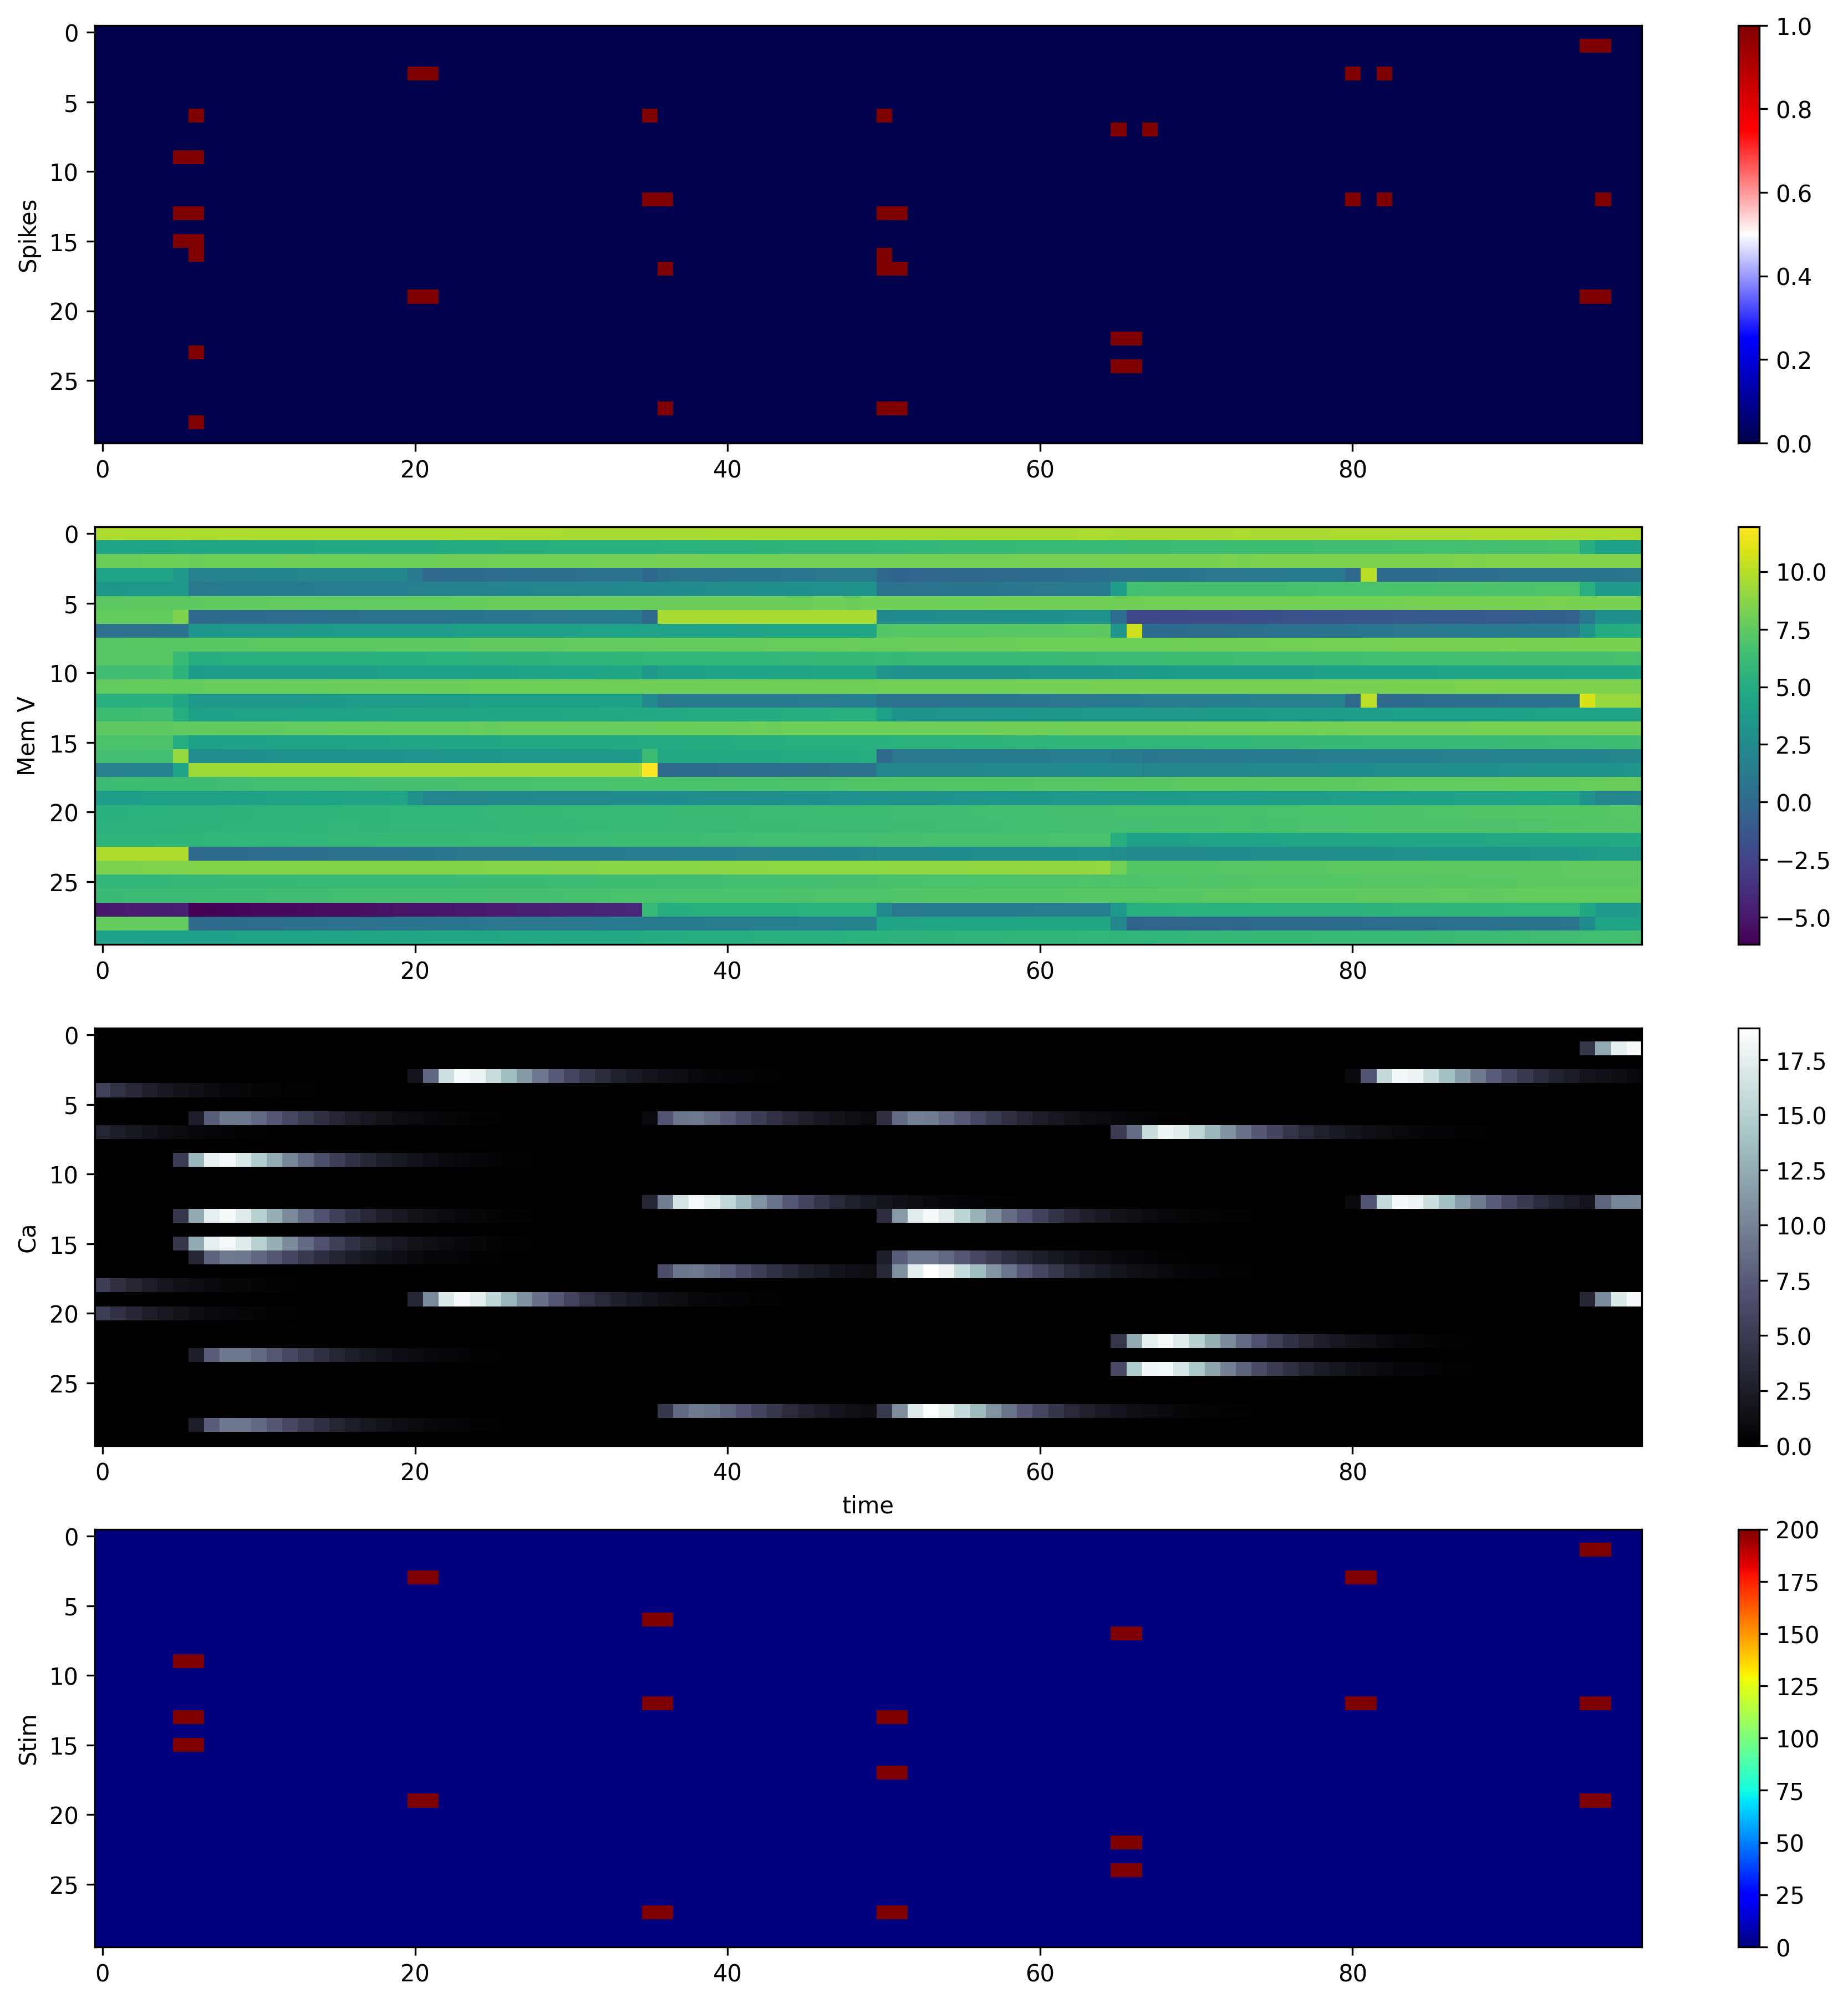

F_vis shape: (3900, 20, 30)
stim_trial_ids: [ 999 1115 2977]
stim_neuron_ids: [ 9 15 25]
untargeted_neuron_ids: [ 0  1  2  3  4  5  6  7  8 10]


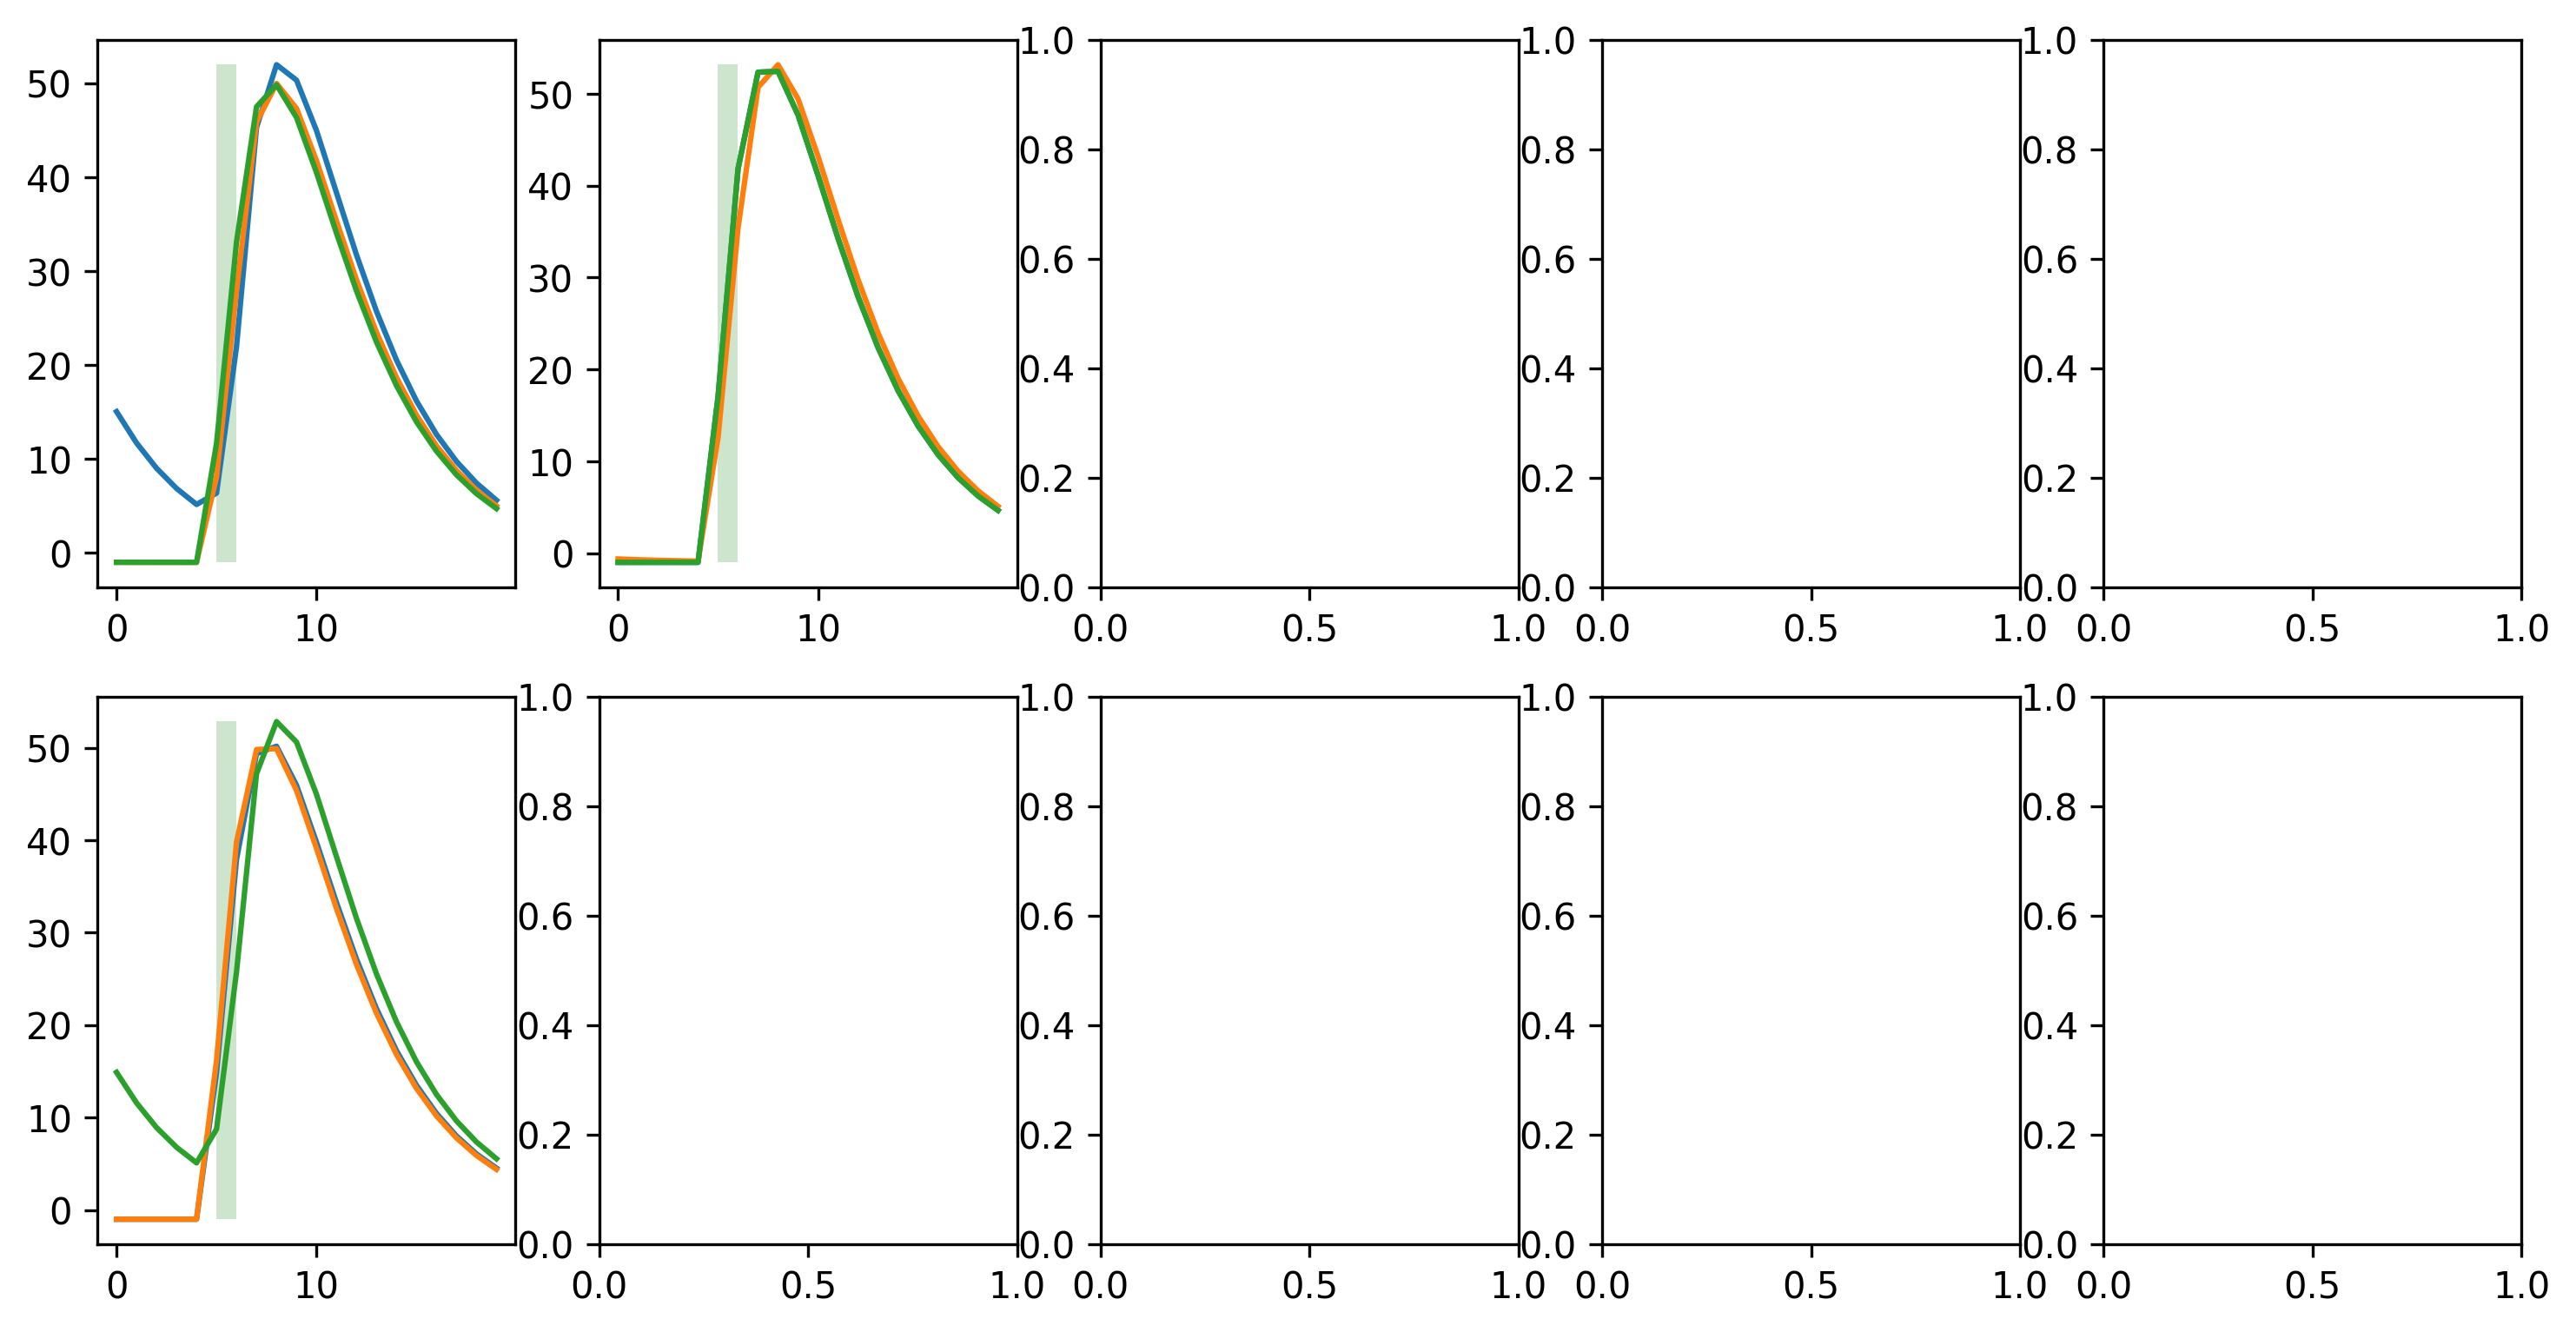

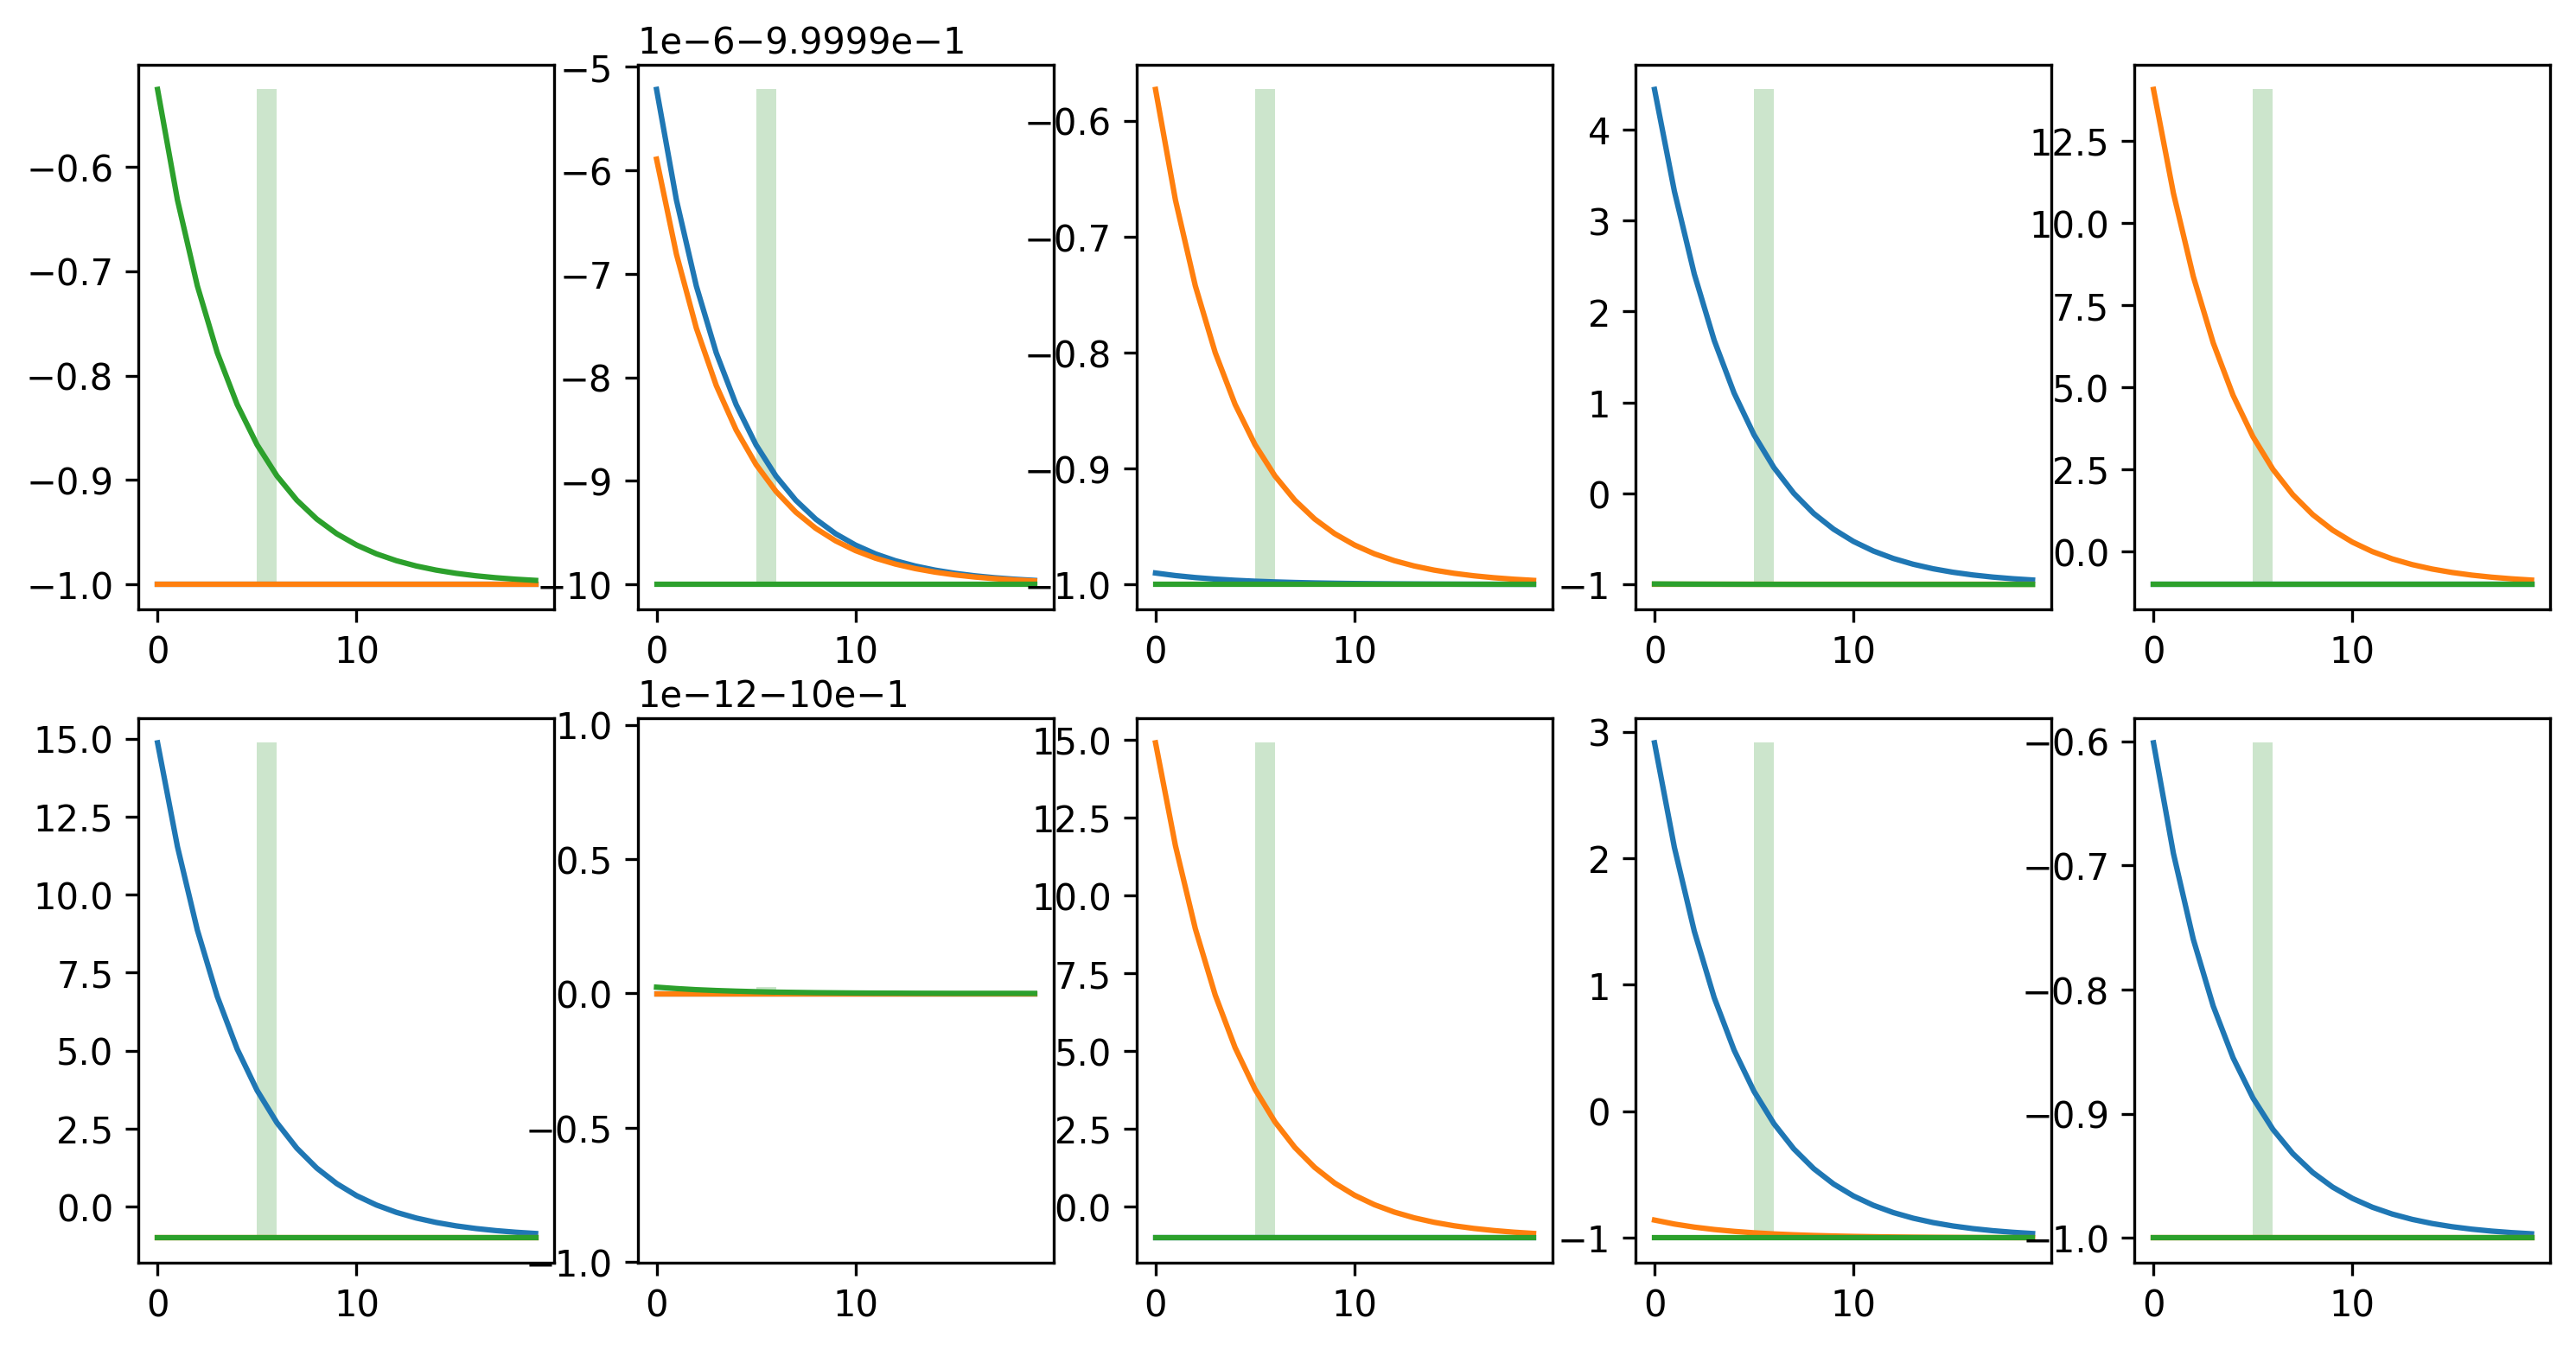

In [165]:
g = 25
Iscale = 200
Catau = 0.2
Itau = 0.1
noise = 1
threshold_voltage = 10
snn, F_vis, input_vis, I_pattern, v_all, Ca_all, Spikes_all, Stimulation_all, Wtrue = generate_data(g = g, 
                                                                                             Iscale = Iscale, 
                                                                                             Catau = Catau, 
                                                                                             Itau = Itau, 
                                                                                             noise = noise,
                                                                                             threshold_voltage = threshold_voltage)

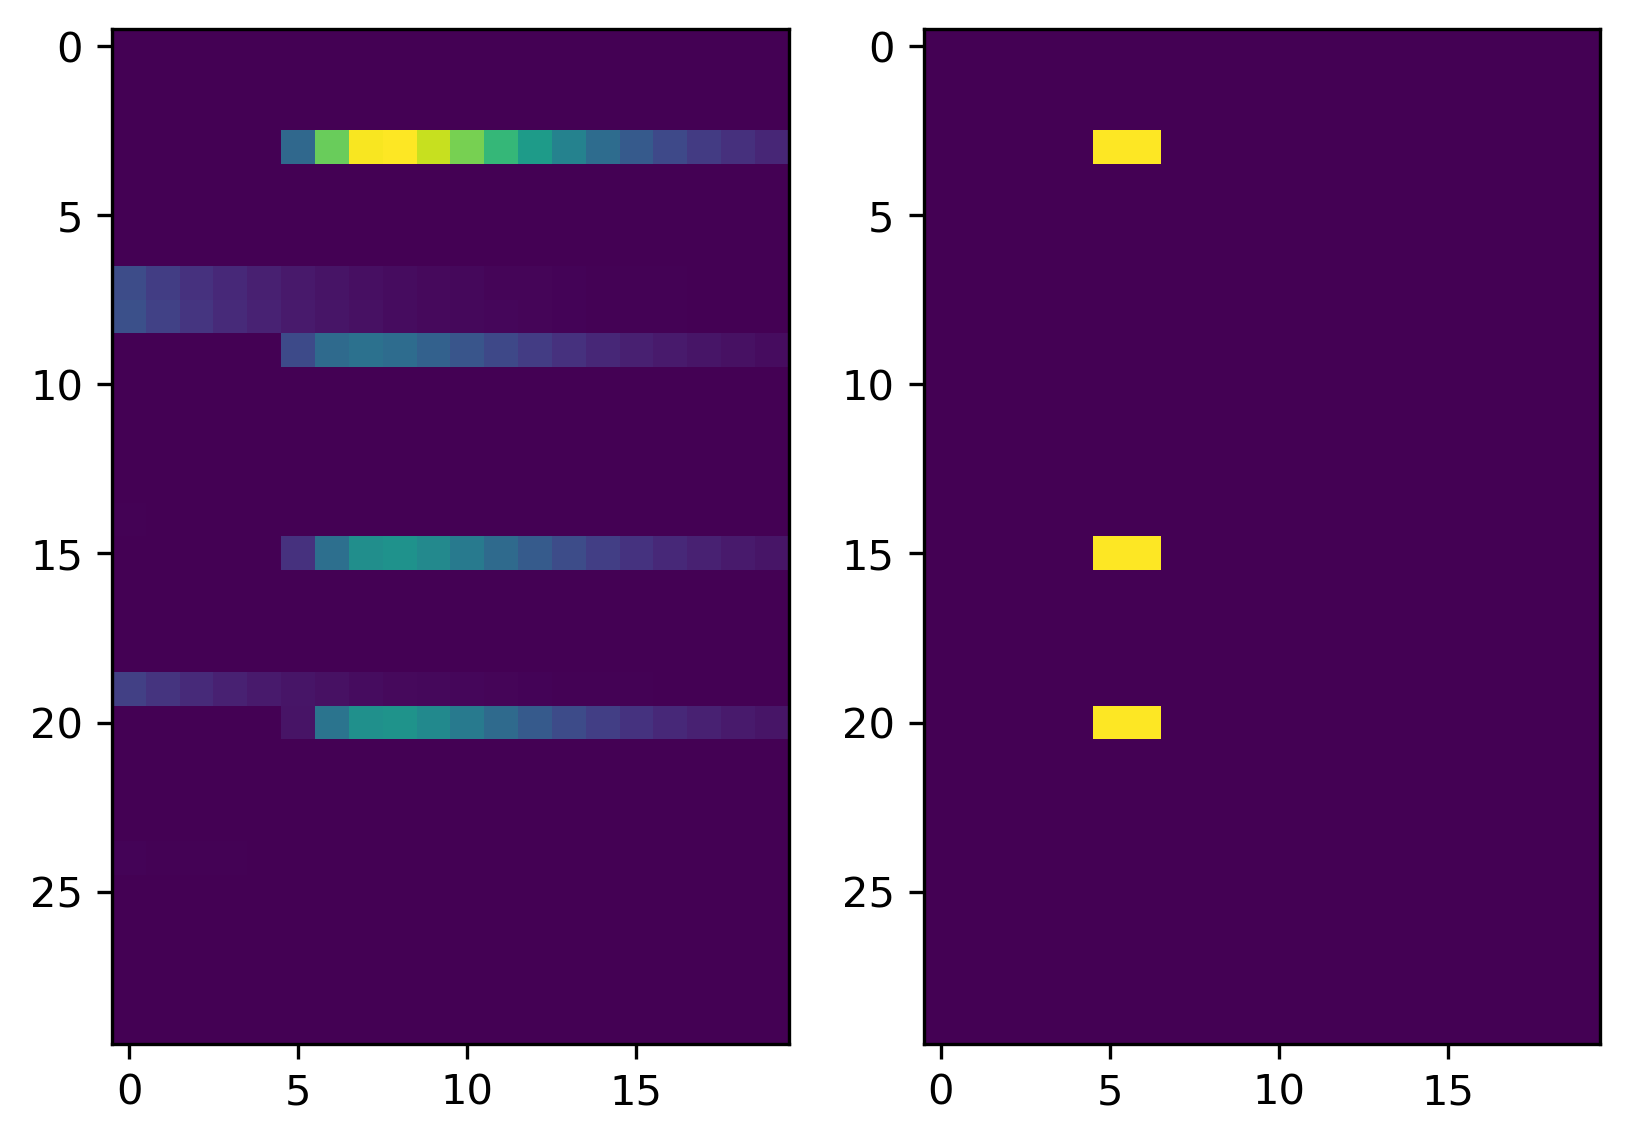

In [33]:
trial_id = 40
neuron_ids_start = 0
neuron_ids_end = 600
plt.figure()
plt.subplot(1,2,1)
plt.imshow(F_vis[trial_id,:,neuron_ids_start:neuron_ids_end].T)
plt.subplot(1,2,2)
plt.imshow(input_vis[trial_id,:,neuron_ids_start:neuron_ids_end].T)

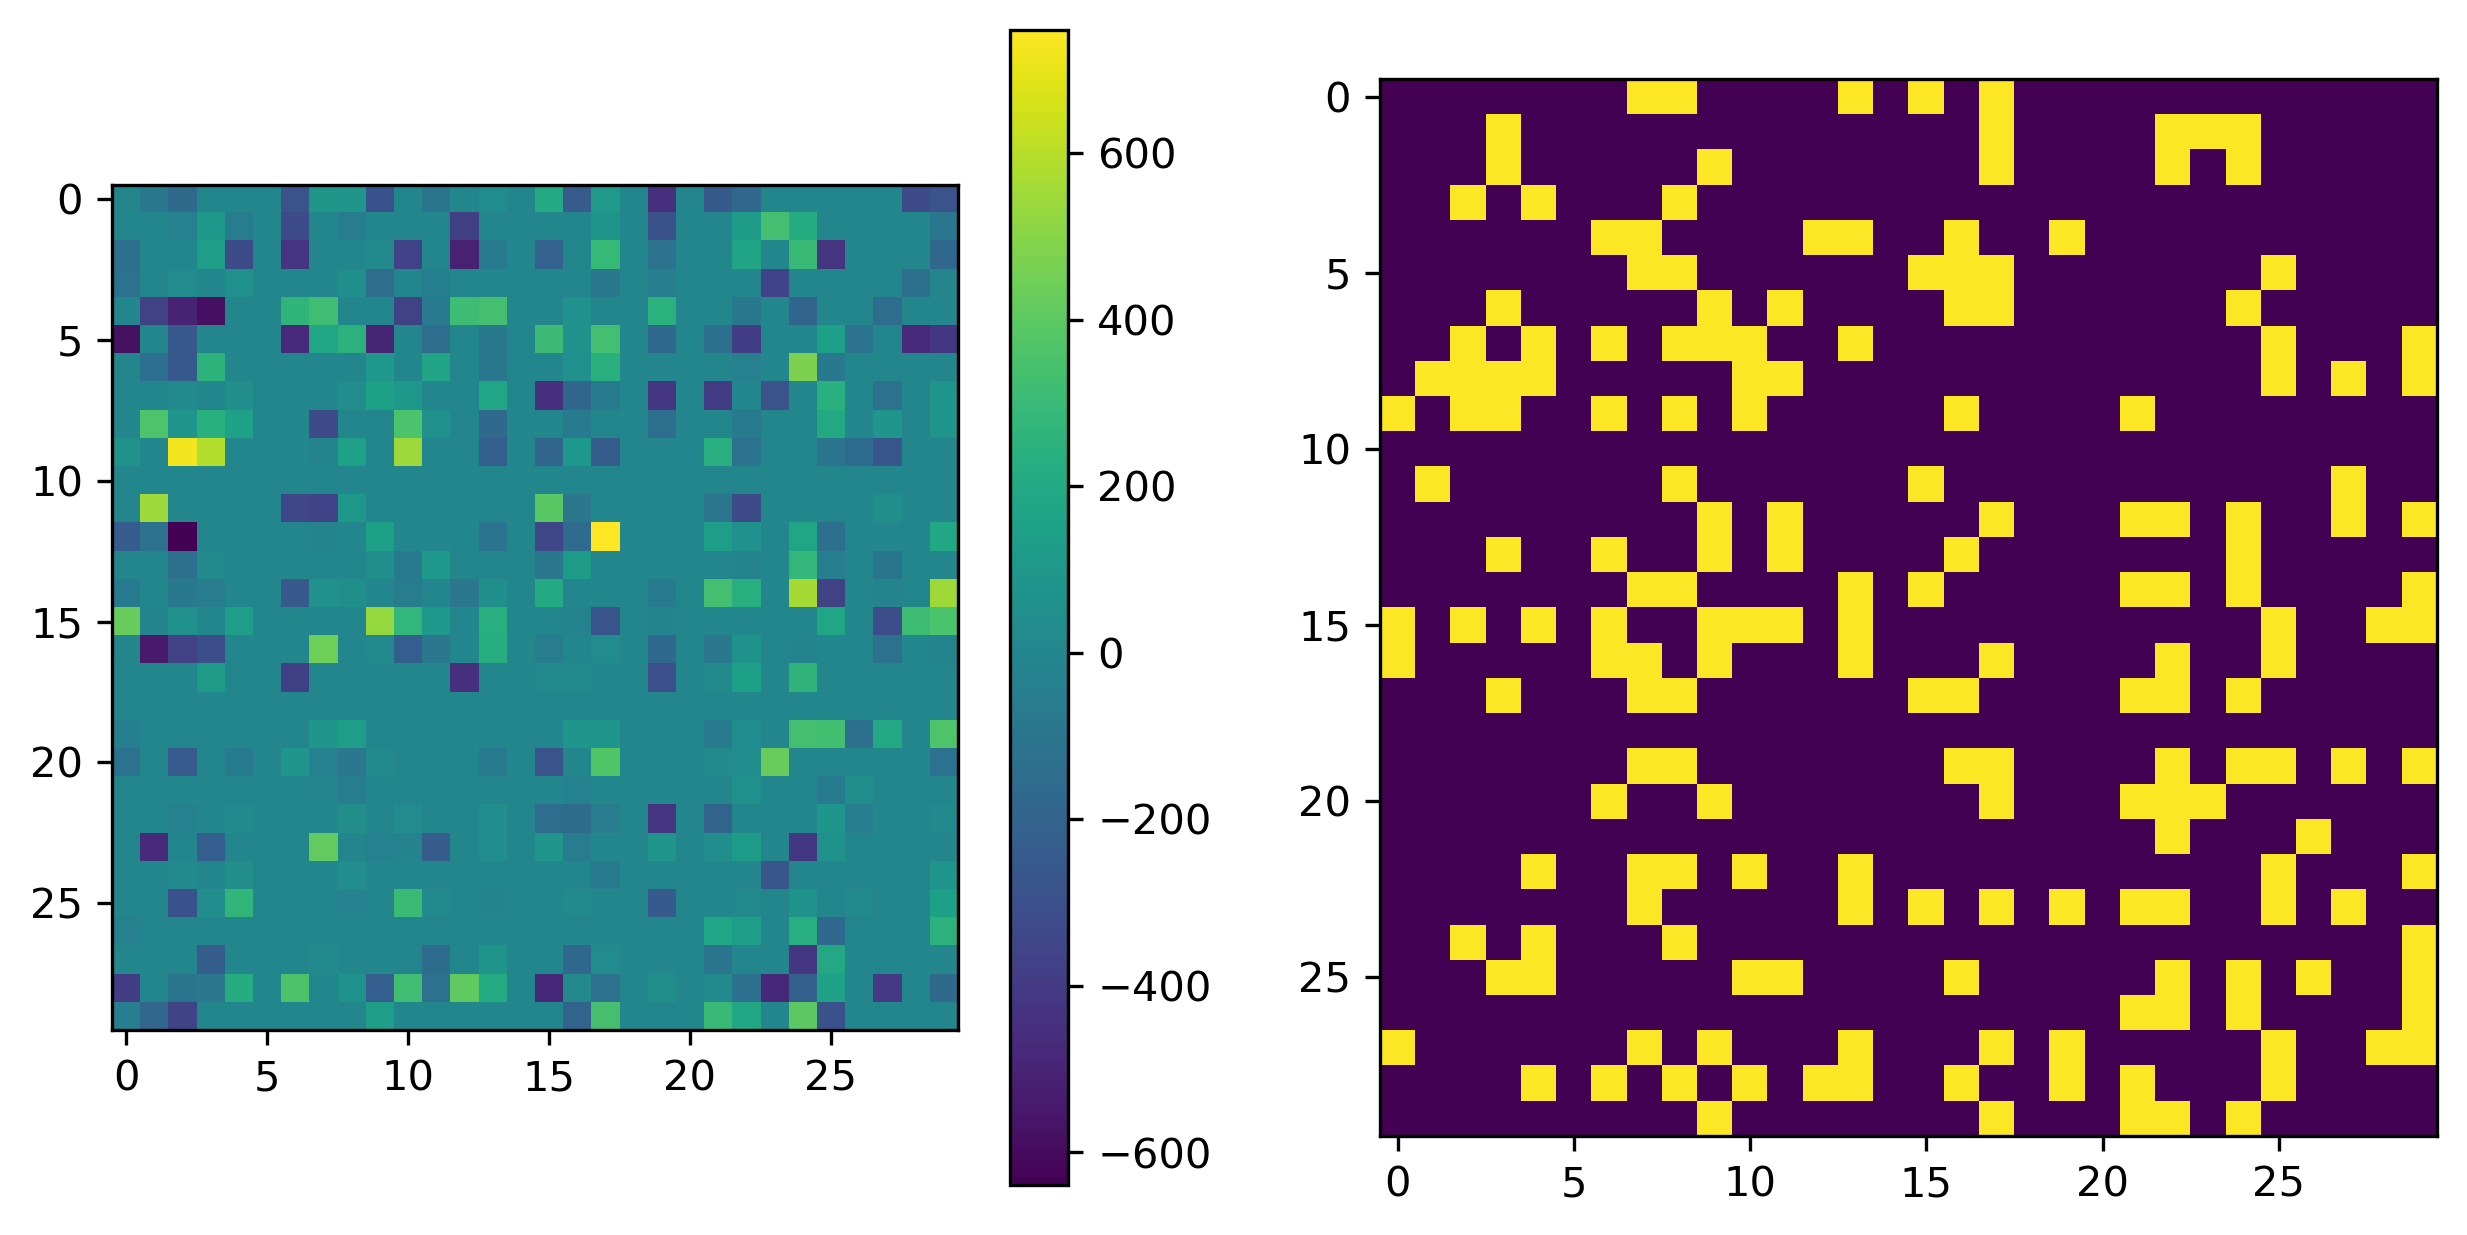

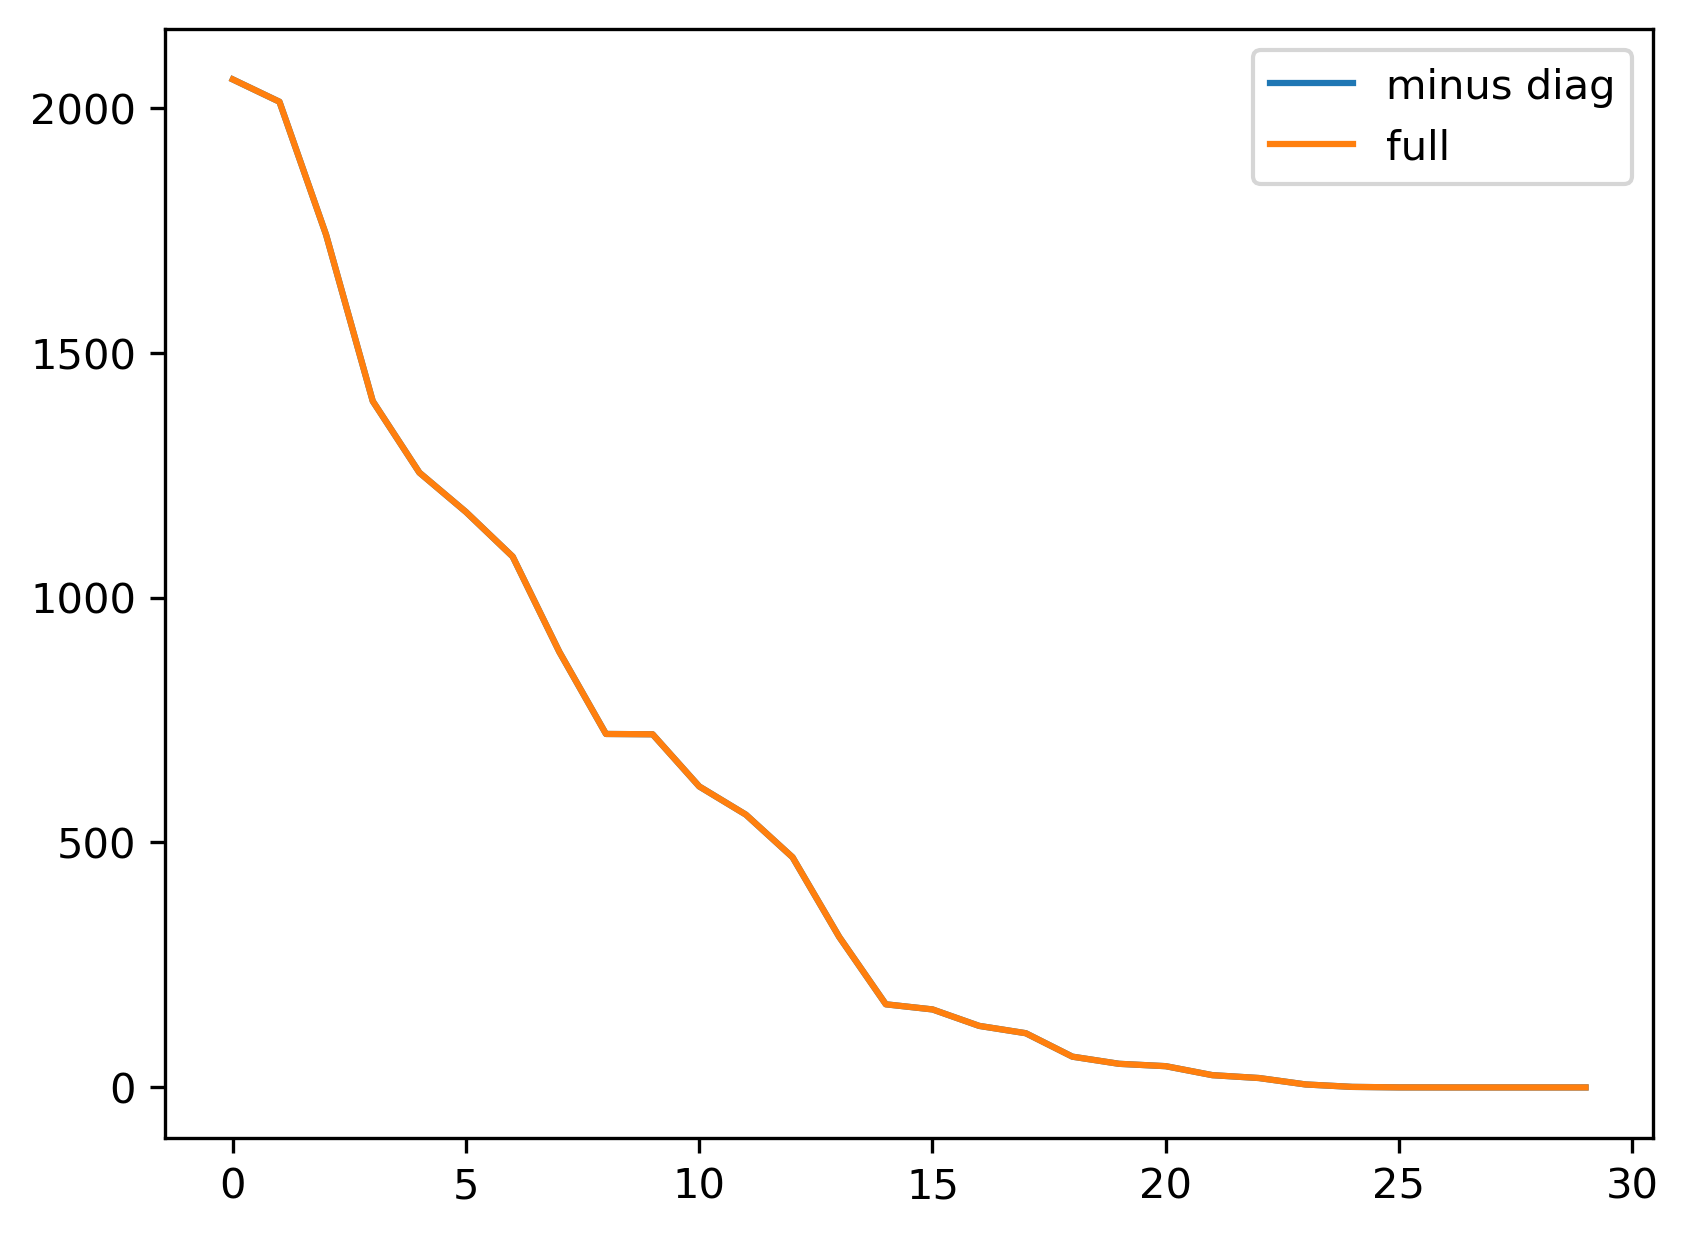

In [35]:
W = snn.W
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(W)
plt.colorbar()

connection_threshold = 1*np.mean(np.diag(W))
W_threshold = (W > connection_threshold).astype(float)
plt.subplot(1,2,2)
plt.imshow(W > connection_threshold)
# plt.imshow(A > connection_threshold, norm=colors.Normalize(vmin=0,vmax=0.5))
plt.figure()
plot_rank_svd(W)

In [36]:
num_neurons = Ca_all.shape[0]
num_trials = snn.stim.I_stimulation_start.shape[0]
upsample_factor = 1
F_vis_raw = np.zeros((num_trials, trial_len * upsample_factor, num_neurons))
v_vis = np.zeros((num_trials, trial_len * upsample_factor, num_neurons))
spik_vis = np.zeros((num_trials, trial_len * upsample_factor, num_neurons))
input_vis = np.zeros((num_trials, trial_len * upsample_factor, num_neurons))

for i, start_time in enumerate(snn.stim.I_stimulation_start):
    F_vis_raw[i, :, :] = Ca_all[:, int(start_time - pre_stim_step) * upsample_factor : int(start_time - pre_stim_step + trial_len)* upsample_factor].T
    input_vis[i, :, :] = Stimulation_all[:, int(start_time - pre_stim_step)* upsample_factor : int(start_time - pre_stim_step + trial_len)* upsample_factor].T
    v_vis[i, :, :] = v_all[:, int(start_time - pre_stim_step)* upsample_factor : int(start_time - pre_stim_step + trial_len)* upsample_factor].T
    spik_vis[i, :, :] = Spikes_all[:, int(start_time - pre_stim_step)* upsample_factor : int(start_time - pre_stim_step + trial_len)* upsample_factor].T

print('F_vis shape:', F_vis_raw.shape)
F_baseline = np.mean(np.mean(F_vis_raw[:,:pre_stim_step,:], axis = 0), axis = 0)
F_vis = (F_vis_raw - F_baseline[None, None, :])/F_baseline[None, None, :]

F_vis shape: (1989, 20, 30)


In [37]:
time_steps = int(F_vis.shape[1]/upsample_factor)
F_vis_ds = np.zeros((F_vis.shape[0], time_steps, F_vis.shape[2]))
input_vis_ds = np.zeros((F_vis.shape[0], time_steps, F_vis.shape[2]))
v_vis_ds = np.zeros((v_vis.shape[0], time_steps, v_vis.shape[2]))
for t in range(time_steps):
    F_vis_ds[:,t,:] = F_vis[:,t * upsample_factor,:]
    input_vis_ds[:,t,:] = input_vis[:,t * upsample_factor,:]
    v_vis_ds[:,t,:] = v_vis[:,t * upsample_factor,:]

In [38]:
print(F_vis_ds.shape)
print(input_vis_ds.shape)

(1989, 20, 30)
(1989, 20, 30)


Text(0.5, 0, 'time (s)')

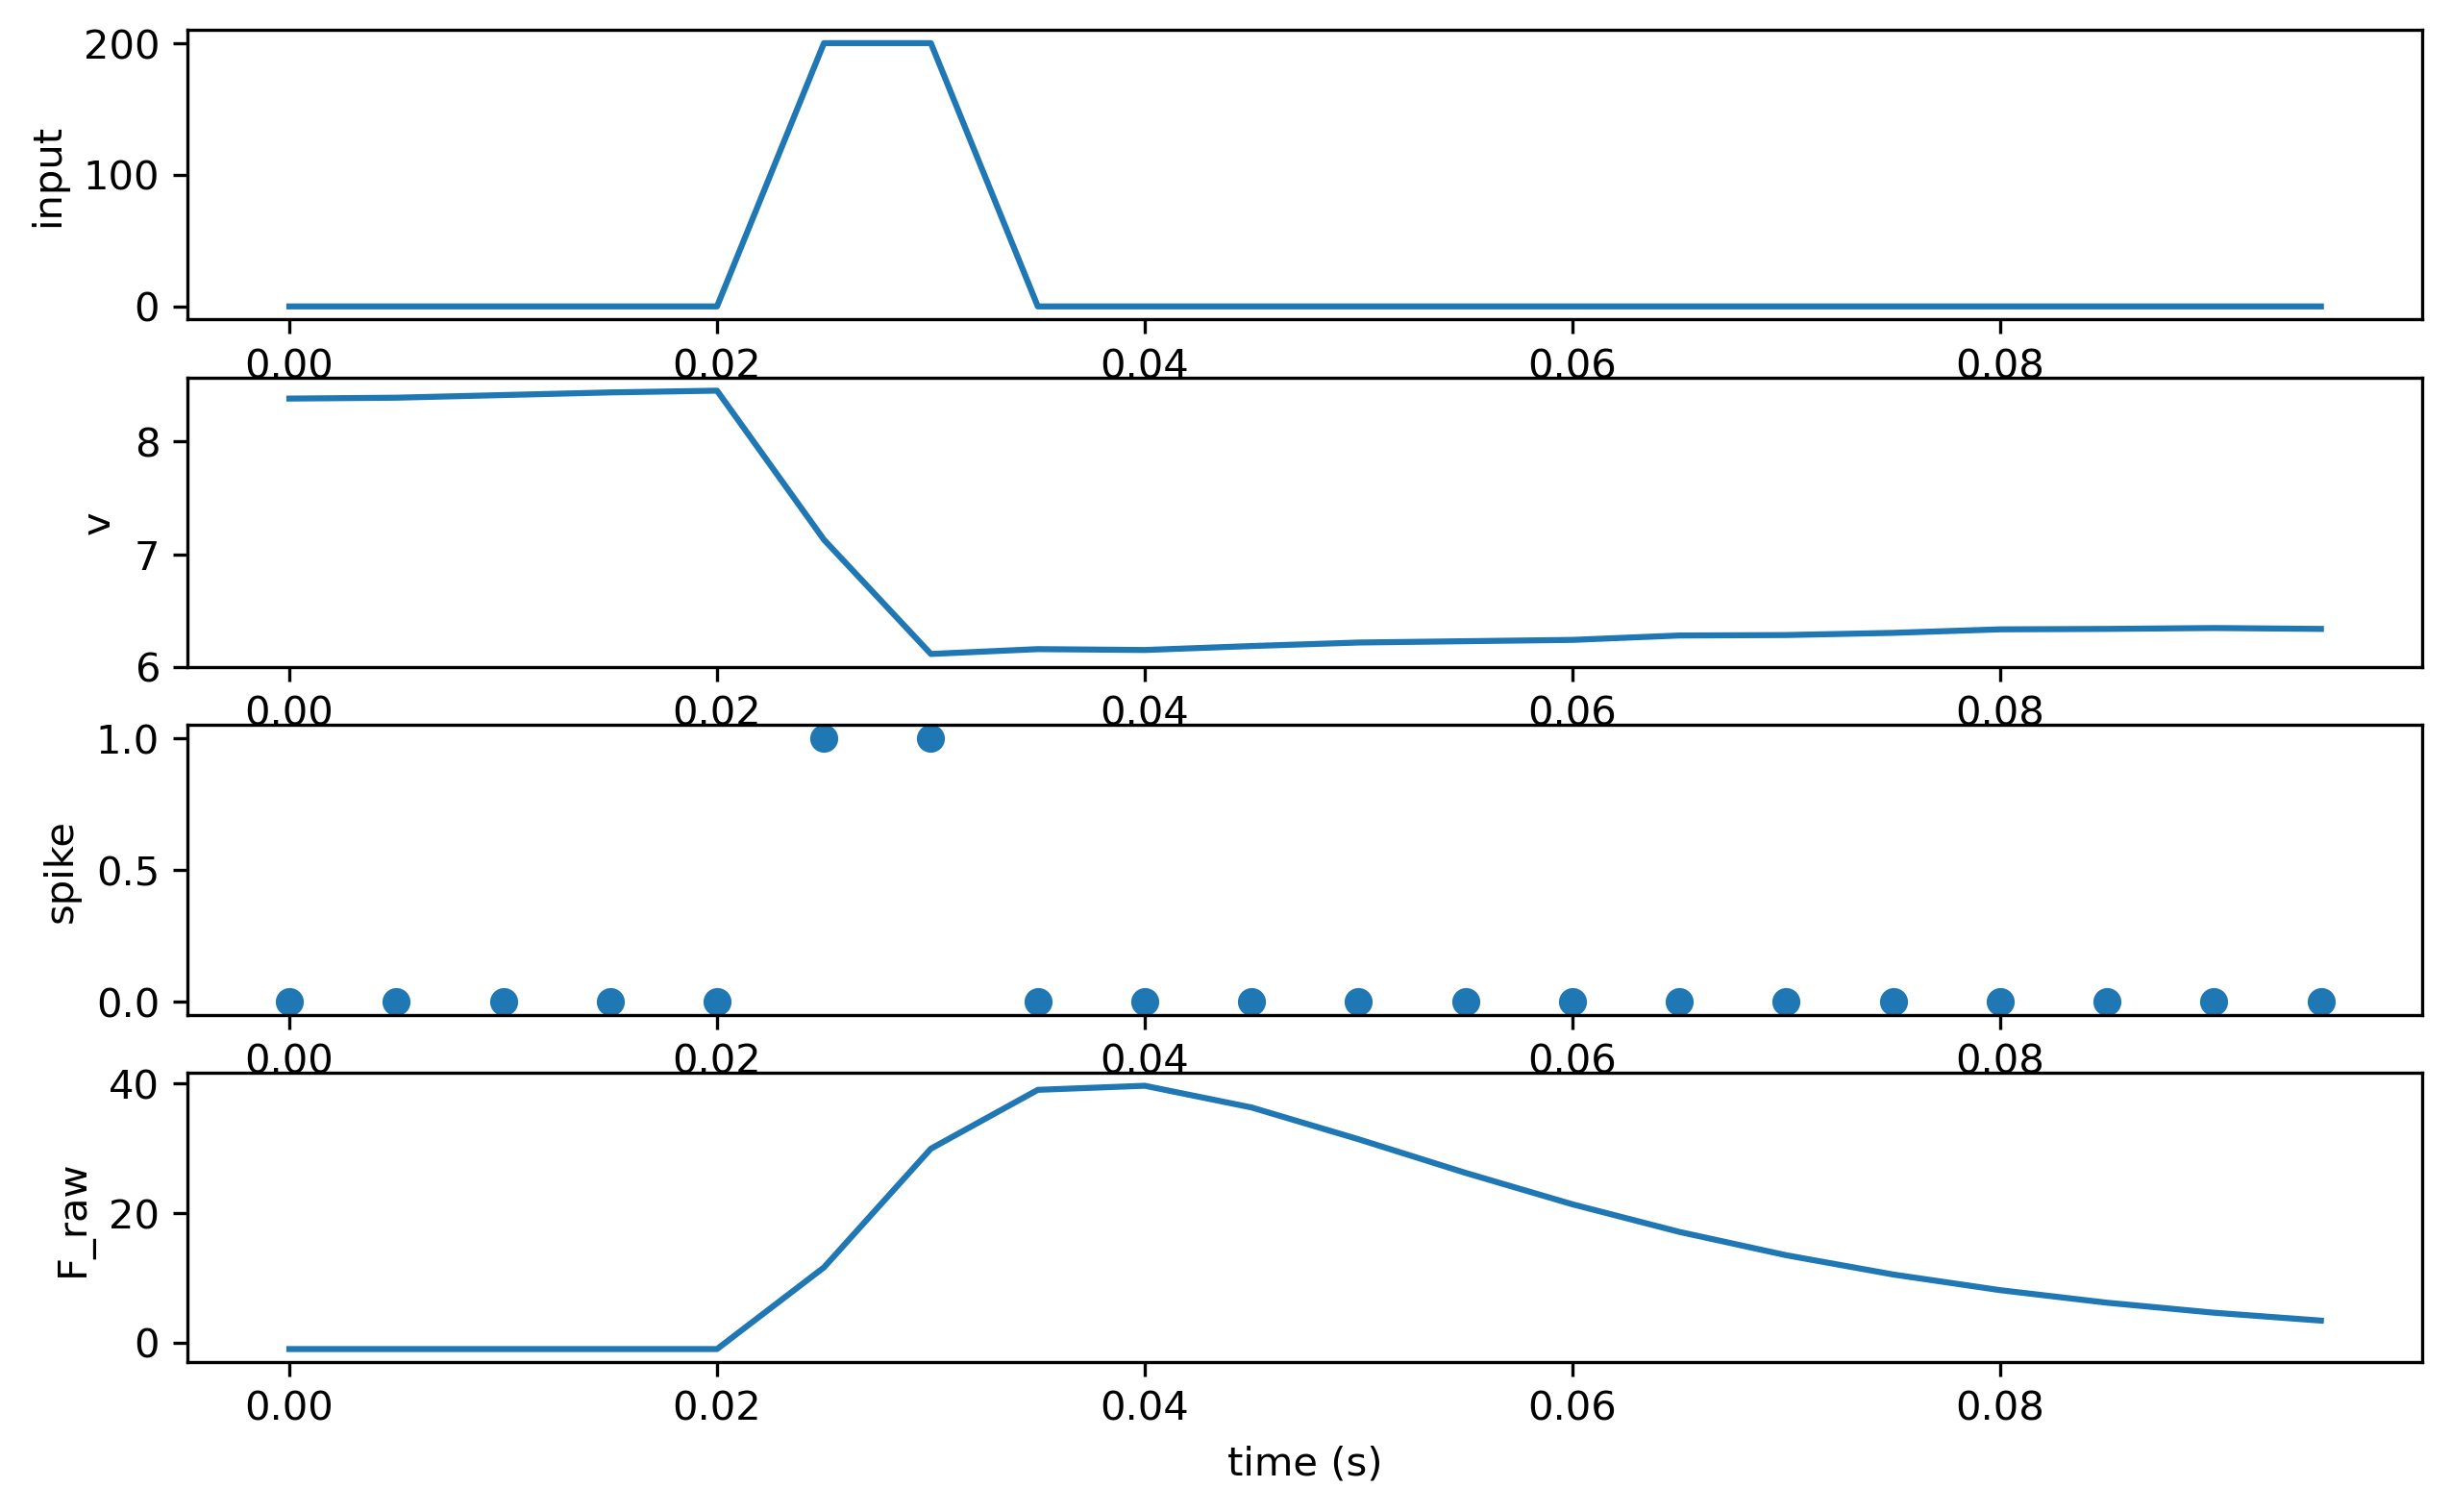

In [39]:
stim_group_id = 60
stim_dt = 0.005
stim_trial_ids = np.where(snn.stim.I_stimulationPattern == stim_group_id)[0]
stim_neuron_ids = np.where(snn.stim.U[:,stim_group_id]==1)[0]
untargeted_all_neuron_ids = np.where(snn.stim.U[:,stim_group_id]==0)[0]
neuron_id = stim_neuron_ids[0]
trial_id = stim_trial_ids[2]
time_steps_ds = np.arange(trial_len) * stim_dt
time_steps = np.arange(trial_len * upsample_factor) * stim_dt
fig, axes = plt.subplots(4,1, figsize=(10, 6))
axes[0].plot(time_steps_ds, input_vis_ds[trial_id, :, neuron_id])
axes[0].set_ylabel('input')
axes[0].set_xlabel('time (s)')
axes[1].plot(time_steps, v_vis.astype('float16')[trial_id, :, neuron_id])
axes[1].set_ylabel('v')
axes[1].set_xlabel('time (s)')
axes[2].plot(time_steps, spik_vis[trial_id, :, neuron_id],'o')
axes[2].set_ylabel('spike')
axes[2].set_xlabel('time (s)')
axes[3].plot(time_steps_ds, F_vis_ds[trial_id, :, neuron_id])
axes[3].set_ylabel('F_raw')
axes[3].set_xlabel('time (s)')

In [166]:
# trial data

y_session = Ca_all.T
u_session = Stimulation_all.T

num_neurons = y_session.shape[1]

# linear interpolation of data
y_session_interp = y_session.copy()
# for i in range(y_session.shape[1]):
#     nan_start = -1
#     nan_stop = -1
#     for j in range(y_session.shape[0]):
#         if nan_start == -1 and np.isnan(y_session_interp[j,i]):
#             nan_start = j - 1
#         if nan_start != -1 and not np.isnan(y_session_interp[j,i]):
#             nan_stop = j
#         if nan_start != -1 and nan_stop != -1:
#             slope = y_session_interp[nan_stop,i] - y_session_interp[nan_start,i]
#             for k in range(nan_stop - nan_start - 1):
#                 y_session_interp[nan_start + k + 1,i] = slope*k/(nan_stop-nan_start-1) + y_session_interp[nan_start,i]
#             nan_start = -1
#             nan_stop = -1
            
# y_session = y_session[4:,:]
# u_session = u_session[4:,:]
# y_session_interp = y_session_interp[4:,:]

In [9]:
spiking = np.zeros(u_session.shape).astype(bool)

for neuron in range(u_session.shape[1]):
    output_true = y_session_interp[4:,neuron]
    mean_threshold = np.median(output_true)
    lower_tail_idx = (output_true < mean_threshold)
    lower_tail_data = output_true[lower_tail_idx]
    lower_tail_std = np.std(lower_tail_data)
    print(lower_tail_std)
    true_spike_threshold = mean_threshold + 10*lower_tail_std
    true_spikes = (output_true > true_spike_threshold)
    spiking[4:,neuron] = true_spikes  
    
#np.save('spiking_labels',spiking)

8.432191815146331e-07
8.022919208133099e-05
9.920206588960728e-06
6.0672039302249855e-09
6.290339761480787e-11
2.384887172330457e-10
2.0192394822772953e-10
1.9315105418023833e-12
5.5654640740345106e-08
3.287338551704567e-05
2.2798208079094888e-14
4.880950018559641e-10
2.106558341362322e-06
1.592431375595125e-05
6.960309710040359e-11
6.538937557224076e-08
1.7179819847029308e-16
0.02582131568484198
3.3118261103771737e-12
0.007816641915908041
1.390107507538943e-08
0.00021152028653191344
1.6331642269607913e-07
0.00019211513834633872
5.379563160722954e-08
0.00021282567472422529
1.8435692227529603e-07
3.1927625975212764e-07
1.6432382473766167e-12
1.455212403705771e-14


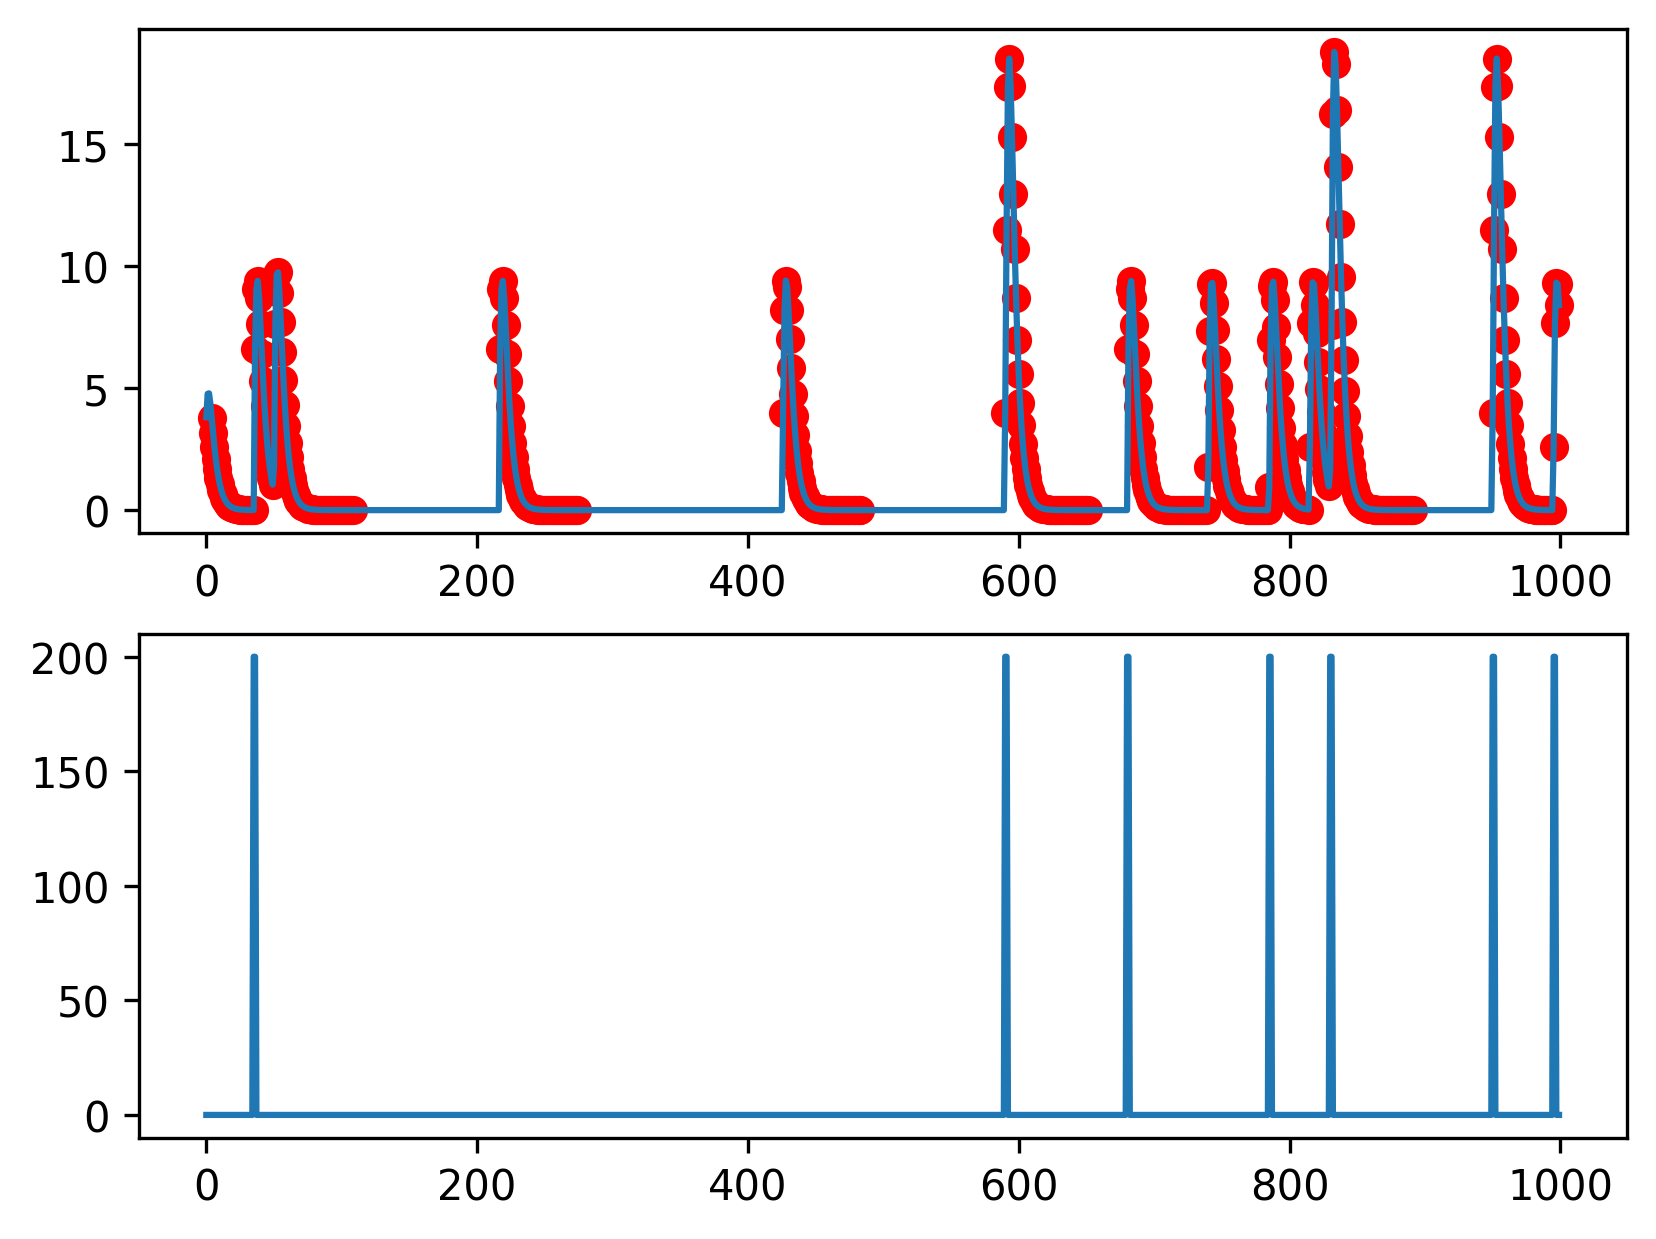

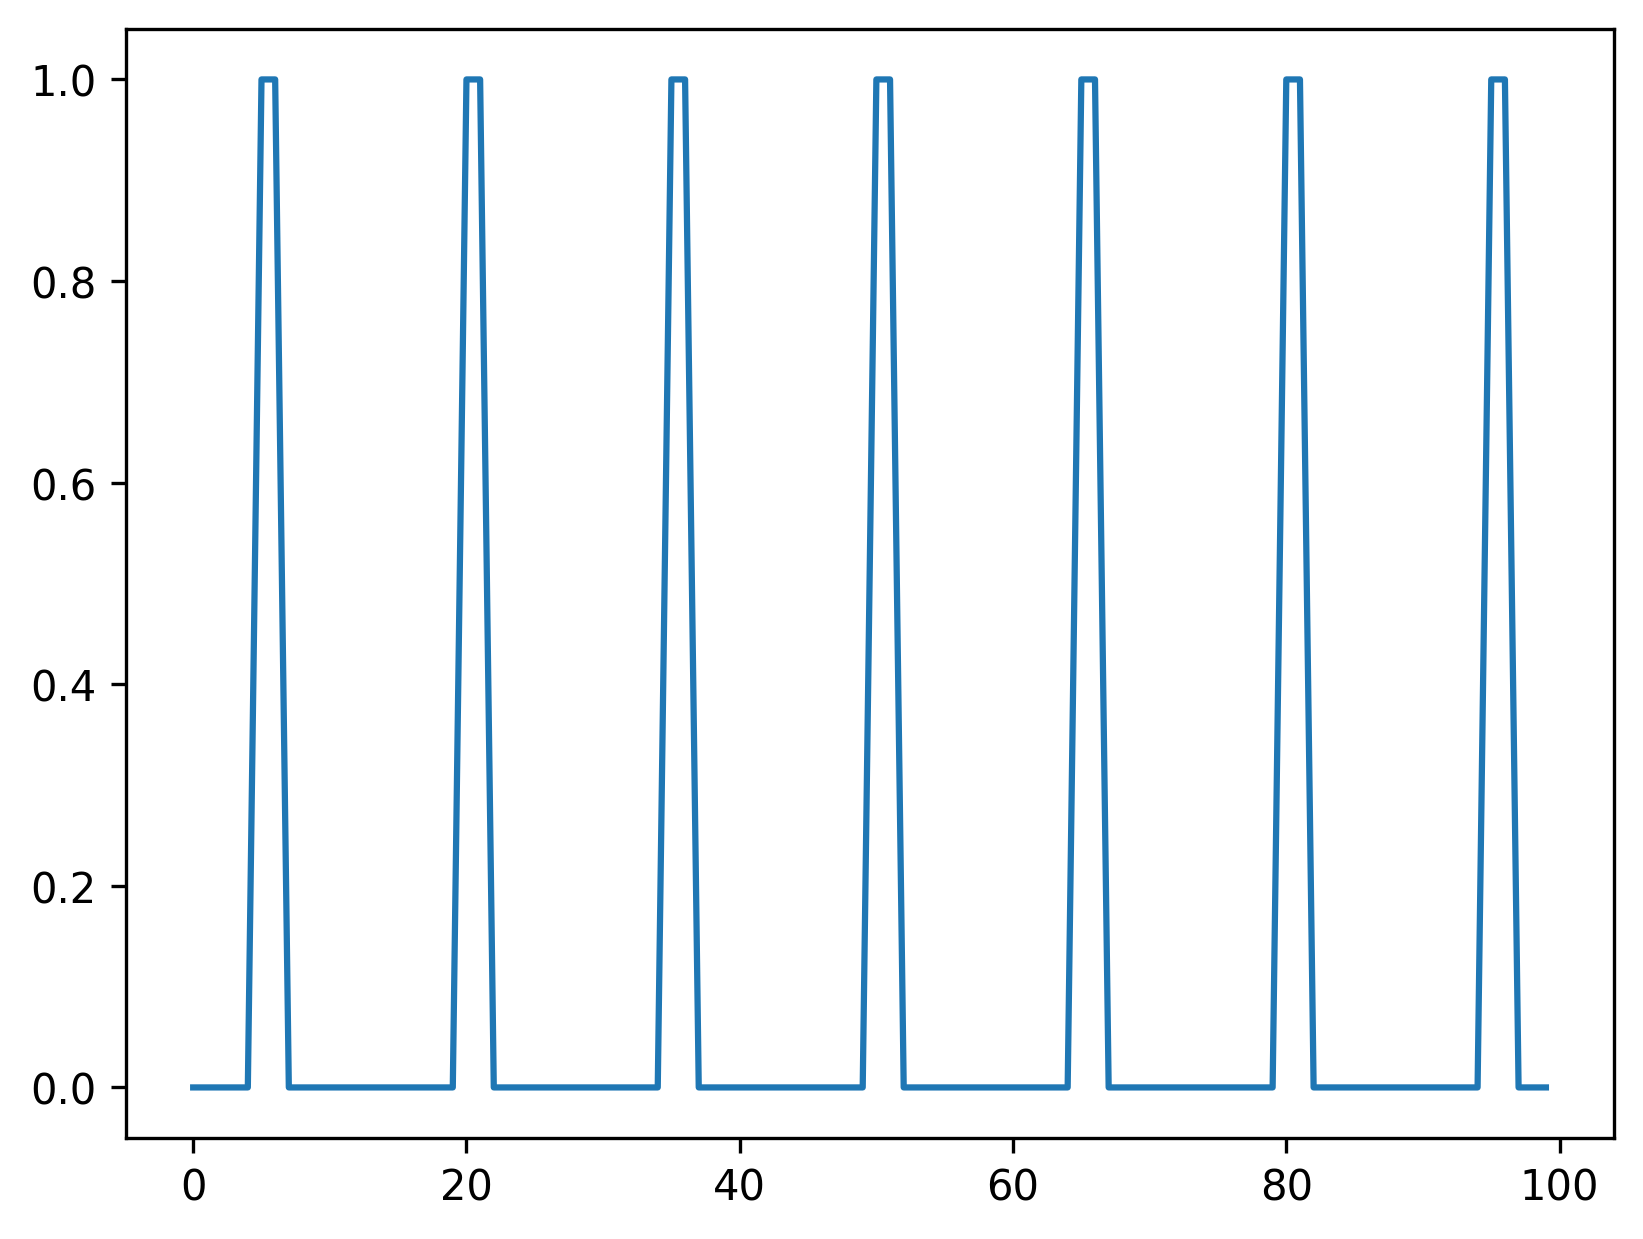

In [16]:
neuron = 0
T_start = 100
T = 1000
plt.subplot(2,1,1)
plt.plot(y_session_interp[:T,neuron])
idx = np.linspace(0,T-1,T)
spiking_neuron = spiking[:T,neuron]
y_out = y_session_interp[0:T,neuron].copy()
y_out = y_out * spiking_neuron
y_out[y_out == 0] = np.nan
plt.scatter(idx,y_out,color='r')

plt.subplot(2,1,2)
plt.plot(u_session[:T,neuron])
plt.show()

plt.plot(np.sum(u_session[0:100,:],axis=1) > 0)

In [44]:
sim_SNN = {'Ca_all': Ca_all,
           'Stimulation_all': Stimulation_all,
           'v_all': v_all,
           'Spikes_all': Spikes_all,
           'F_vis_ds': F_vis_ds,
           'v_vis_ds': v_vis.astype('float16'),
           'input_vis_ds': input_vis_ds,
           'spik_vis': spik_vis.astype(int),
           'stim_order': snn.stim.I_stimulationPattern,
           'stim_pattern': snn.stim.U,
           'sim_w': snn.W}

In [45]:
np.save('data/sim_SNN_0515_neuron_30_sparse_low_rank_15.npy', sim_SNN)

# Andrew Edit's

In [8]:
def np_sigmoid(z):
    return 1/(1 + np.exp(-z))

class Dataset:
    def __init__(self, segments_y, segments_u, segments_nan, segments_spiking, train_idx, test_idx):
        self.segments_y = segments_y
        self.segments_u = segments_u
        self.segments_nan = segments_nan
        self.segments_spiking = segments_spiking
        self.train_indices = train_idx  
        self.test_indices = test_idx
        self.d = segments_y[0].shape[1]
        self.ark_order = 1
        self.roc_thresholds = np.linspace(-2,5,15)
        self.compute_test_quantities()

    def get_y(self,idx):
        return self.segments_y[idx].copy()

    def get_u(self,idx):
        return self.segments_u[idx].copy()

    def get_train_idx(self):
        return self.train_indices.copy()

    def get_inputs(self):
        cov_u = np.zeros((self.d,len(self.segments_u)))
        for i in range(len(self.segments_u)):
            for t in range(self.segments_u[i].shape[0]):
                if np.sum(self.segments_u[i][t,:]) > 0:
                    cov_u[:,i] = self.segments_u[i][t,:].copy()
                    break
        return cov_u.T

    def compute_test_quantities(self):
        x_true = []
        spike_label = []
        input_segment = []
        for i in range(len(self.test_indices)):
            if self.test_indices[i]:
                x_true.append([])
                spike_label.append([])
                input_segment.append(0)
                for t in range(self.segments_y[i].shape[0]):
                    if t >= self.ark_order:
                        if not self.segments_nan[i][t]:
                            x_true[-1].append(self.segments_y[i][t,:].copy().flatten())
                            spike_label[-1].append(self.segments_spiking[i][t,:].copy().flatten())
                input_segment[-1] = np.sum(self.segments_u[i], axis=0) > 0
                x_true[-1] = np.array(x_true[-1])
                spike_label[-1] = np.array(spike_label[-1])
        self.test_true = x_true
        self.test_spike_label = spike_label
        self.test_input_segment = input_segment


    def compute_roc(self, prediction):
        tpr = []
        fpr = []
        tpr_noinput = []
        fpr_noinput = []

        for thresholds_idx in range(len(self.roc_thresholds)):
            for mode_idx in range(2):
                tp_total = 0
                fp_total = 0
                p_total = 0
                n_total = 0

                for neuron in range(self.d):
                    output_pred = []
                    output_true = []
                    output_label = []
                    sequence_idx = 0
                    for i in range(len(self.test_true)):
                        if mode_idx == 0:
                            output_pred.extend(prediction[i][:,neuron])
                            output_true.extend(self.test_true[i][:,neuron])
                            output_label.extend(self.test_spike_label[i][:,neuron])
                        elif not self.test_input_segment[i][neuron]:
                            output_pred.extend(prediction[i][:,neuron])
                            output_true.extend(self.test_true[i][:,neuron])
                            output_label.extend(self.test_spike_label[i][:,neuron])
                    output_pred = np.array(output_pred)
                    output_true = np.array(output_true)
                    output_label = np.array(output_label).astype(bool)

                    mean_threshold = np.median(output_true)
                    lower_tail_idx = (output_true < mean_threshold)
                    lower_tail_data = output_true[lower_tail_idx]
                    lower_tail_std = np.std(lower_tail_data)
                    detect_spike_threshold = mean_threshold + self.roc_thresholds[thresholds_idx]*lower_tail_std

                    predicted_spikes = (output_pred > detect_spike_threshold)
                    tp_total += np.sum(np.logical_and(predicted_spikes,output_label))
                    fp_total += np.sum(np.logical_and(predicted_spikes,~output_label))
                    p_total += np.sum(output_label)
                    n_total += np.sum(~output_label)

                if mode_idx == 0:
                    tpr.append(tp_total / p_total)
                    fpr.append(fp_total / n_total)
                else:
                    if p_total > 0:
                        tpr_noinput.append(tp_total / p_total)
                    if n_total > 0:
                        fpr_noinput.append(fp_total / n_total)
        return tpr, fpr, tpr_noinput, fpr_noinput


    def evaluate(self, Ahat, roc=True, sigmoid=False):
        if sigmoid:
            return self.evaluate_sigmoid(Ahat)
        x_pred = []
        mse = 0
        mse_pc1 = 0
        count = 0
        for i in range(len(self.test_indices)):
            if self.test_indices[i]:
                x_past = []
                x_pred.append([])
                for t in range(self.segments_y[i].shape[0]):
                    if t < self.ark_order:
                        x_past.append(self.segments_y[i][t,:].copy().flatten())
                    else:
                        z = np.array(x_past).flatten()
                        z = np.concatenate((z,self.segments_u[i][t-self.ark_order:t,:].copy().flatten(),np.ones(1)))
                        x_next = Ahat @ z
                        x_past.pop(0)
                        x_past.append(x_next.copy())
                        if not self.segments_nan[i][t]:
                            x_pred[-1].append(x_next.copy())
                            mse += np.linalg.norm(x_next.copy() - self.segments_y[i][t,:].copy().flatten(), 2)**2
                            #mse_pc1 += (y_pc1.T @ (x_next.copy() - self.segments_y[i][t,:].copy().flatten()))**2
                            count += 1
                x_pred[-1] = np.array(x_pred[-1])
        if roc:
            tpr, fpr, tpr_noin, fpr_noin = self.compute_roc(x_pred)
            return mse / count, tpr, fpr, tpr_noin, fpr_noin
        else:
            return mse / count
    
    def evaluate_sigmoid(self, Ahat):
        x_pred = []
        mse = 0
        mse_pc1 = 0
        count = 0
        x_true = []
        for i in range(len(self.test_indices)):
            if self.test_indices[i]:
                x_past = []
                x_pred.append([])
                for t in range(self.segments_y[i].shape[0]):
                    if t < self.ark_order:
                        x_past.append(self.segments_y[i][t,:].copy().flatten())
                    else:
                        z = np.array(x_past).flatten()
                        u = self.segments_u[i][t-self.ark_order:t,:].copy().flatten()
                        #z = np.concatenate((z,self.segments_u[i][t-self.ark_order:t,:].copy().flatten(),np.ones(1)))
                        x_next = Ahat[3] * np_sigmoid(Ahat[0] @ z + Ahat[1] @ u + Ahat[2])
                        x_past.pop(0)
                        x_past.append(x_next.copy())
                        if not self.segments_nan[i][t]:
                            x_pred[-1].append(x_next.copy())
                            mse += np.linalg.norm(x_next.copy() - self.segments_y[i][t,:].copy().flatten(), 2)**2
                            #mse_pc1 += (y_pc1.T @ (x_next.copy() - self.segments_y[i][t,:].copy().flatten()))**2
                            count += 1
                            x_true.append(self.segments_y[i][t,:].copy().flatten())
                x_pred[-1] = np.array(x_pred[-1])
        x_true = np.array(x_true)
        return mse / np.linalg.norm(x_true, 'fro')**2





def load_data(y_session,u_session, one_step=False):
    # trial data
    #data = np.load('./data/' + filename, allow_pickle = True).item()
    #data = np.load('./data/photostim_0404/photostim_0404_date_070623.npy', allow_pickle=True).item()
    #y = data['y']
    #u = data['u']
    # num_trials = y.shape[0]
    # num_steps = y.shape[1]
    # num_neurons = y.shape[2]
    # d = num_neurons
    #y_session = data['y_session'][4:,:]
    #u_session = data['u_session'][4:,:]
    num_neurons = u_session.shape[1]
    d = num_neurons

    y_ses_nan = np.isnan(y_session)
    y_ses_nan_sum = np.sum(y_ses_nan, axis=1)
    y_ses_nan_idx = (y_ses_nan_sum > 0)

    #linear interpolation of data
    y_session_interp = y_session.copy()
    for i in range(y_session.shape[1]):
        nan_start = -1
        nan_stop = -1
        for j in range(y_session.shape[0]):
            if nan_start == -1 and np.isnan(y_session_interp[j,i]):
                nan_start = j - 1
            if nan_start != -1 and not np.isnan(y_session_interp[j,i]):
                nan_stop = j
            if nan_start != -1 and nan_stop != -1:
                slope = y_session_interp[nan_stop,i] - y_session_interp[nan_start,i]
                for k in range(nan_stop - nan_start - 1):
                    y_session_interp[nan_start + k + 1,i] = slope*k/(nan_stop-nan_start-1) + y_session_interp[nan_start,i]
                nan_start = -1
                nan_stop = -1
    print('number nan = ' + str(np.sum(np.isnan(y_session_interp))))

    spiking = np.zeros(u_session.shape).astype(bool)
    for neuron in range(u_session.shape[1]):
        output_true = y_session_interp[4:,neuron]
        mean_threshold = np.median(output_true)
        lower_tail_idx = (output_true < mean_threshold)
        lower_tail_data = output_true[lower_tail_idx]
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
        true_spikes = (output_true > true_spike_threshold)
        spiking[4:,neuron] = true_spikes  

    return split_data(u_session, y_session, y_ses_nan_idx, spiking, one_step=one_step)


def split_data(u_session, y_session_interp, y_nan_idx, spiking, one_step=False):
    segments_y = []
    segments_u = []
    segments_nan = []
    segments_spiking = []
    t = 0
    saved_t = 0
    saved_idx = np.zeros(u_session.shape[0])
    while True:
        #if np.sum(u_session[t,:]) > 0 and np.sum(u_session[t-1,:]) == 0 and t < saved_t + 5:
        t2 = 5
        while True:
            if np.sum(u_session[saved_t+t2,:]) > 0 and np.sum(u_session[saved_t+t2-1,:]) == 0:
                break
            t2 += 1
            if saved_t+t2 == u_session.shape[0] - 1:
                break
        segment_stop = np.min([saved_t+t2-3, u_session.shape[0]])
        if one_step:
            y1 = np.mean(y_session_interp[saved_t:saved_t+3,:].copy(), axis=0)
            y2 = np.mean(y_session_interp[saved_t+3:segment_stop,:].copy(), axis=0)
            #print(np.sum(np.isnan(y_session_interp[saved_t:segment_stop,:])),saved_t+t2,segment_stop)
            seg_y = np.array([y1,y2])
            u1 = u_session[saved_t+t2,:].copy()
            #u2 = np.zeros(u1.shape)
            #seg_u = np.array([u1,u2])
            seg_u = u1[None,:]
        else:
            seg_y = y_session_interp[saved_t:segment_stop,:].copy() #/ 1000
            seg_u = u_session[saved_t:segment_stop,:].copy()
        saved_idx[saved_t:segment_stop] += 1.0
        nan_idx = y_nan_idx[saved_t:segment_stop]
        if np.sum(np.isnan(seg_y)) == 0:
            segments_y.append(seg_y)
            segments_u.append(seg_u)
            segments_nan.append(nan_idx)
            segments_spiking.append(spiking[saved_t:segment_stop,:])
        saved_t = segment_stop
        if saved_t + 5 >= u_session.shape[0]:
            break
    print(saved_idx.sum(),u_session.shape[0],np.sum(saved_idx > 1),len(segments_u))

    patterns = []
    pattern_count = []
    pattern_idx = []
    pattern_length = []
    d = u_session.shape[1]

    for i in range(len(segments_u)):
        found_pat = False
        for t in range(segments_u[i].shape[0]):
            if np.sum(np.abs(segments_u[i][t,:])) > 0:
                idx = np.linspace(0,d-1,d).astype(int)
                on = segments_u[i][t,:] > 0
                pattern = np.array(idx[on])
                found = False
                for j in range(len(patterns)):
                    if len(pattern) == len(patterns[j]):
                        if np.linalg.norm(pattern - patterns[j]) == 0:
                            pattern_count[j] += 1
                            pattern_idx[j].append(i)
                            found = True
                            break
                if found is False:
                    patterns.append(pattern)
                    pattern_count.append(1)
                    pattern_idx.append([i])
                    pattern_length.append(len(pattern))
                found_pat = True
                break
        if not found_pat:
            print('error',i,segments_u[i].sum())

                
    # remove patterns randomly
    print('num patterns = ' + str(len(patterns)))
    num_patterns = 200
    removed_patterns = []
    removed_count = 0
    train_idx = np.ones(len(segments_u)).astype(int)
    test_idx = np.zeros(len(segments_u)).astype(int)

    while len(removed_patterns) < num_patterns:
        p_idx = np.random.randint(0,len(patterns))
        if p_idx not in removed_patterns:
            removed_patterns.append(p_idx)
            removed_count += pattern_count[p_idx]
            test_idx[pattern_idx[p_idx]] = 1
            train_idx[pattern_idx[p_idx]] = 0

    print(removed_patterns)
            
    data = Dataset(segments_y, segments_u, segments_nan, segments_spiking, train_idx, test_idx)
    return data

In [167]:
data = load_data(y_session,u_session,one_step=False)

number nan = 0
60016.0 60020 0 3901
error 0 0.0
num patterns = 1136
[1073, 963, 76, 532, 958, 1101, 507, 335, 265, 391, 748, 177, 240, 1074, 635, 676, 909, 928, 365, 952, 931, 791, 453, 687, 239, 493, 829, 191, 151, 370, 667, 461, 245, 241, 430, 104, 921, 907, 648, 675, 232, 372, 727, 349, 717, 1088, 359, 221, 38, 208, 172, 398, 604, 688, 77, 768, 1032, 225, 706, 329, 29, 685, 170, 95, 769, 679, 736, 935, 5, 197, 654, 257, 357, 49, 413, 1058, 445, 595, 866, 446, 490, 811, 473, 781, 636, 771, 23, 1093, 1009, 787, 854, 746, 176, 2, 722, 597, 741, 834, 630, 855, 495, 183, 1082, 938, 743, 582, 171, 94, 485, 1026, 20, 721, 141, 217, 549, 852, 277, 464, 694, 207, 1077, 211, 233, 235, 949, 1005, 397, 567, 1031, 25, 373, 737, 1099, 601, 997, 162, 901, 878, 719, 710, 1057, 402, 740, 109, 904, 465, 893, 219, 212, 1065, 84, 276, 100, 585, 238, 54, 422, 936, 884, 906, 476, 598, 304, 560, 330, 392, 697, 526, 363, 508, 472, 930, 883, 1041, 252, 602, 187, 273, 405, 12, 488, 550, 185, 258, 1035, 1048,

In [16]:
def run_experiment_helper(params, data):
    results = {}
    results["time"] = []
    for est_type in params["est_type"]:
        results[est_type + '_mse'] = []
        #data[est_type + '_mse_pc1'] = []
        if params["roc"]:
            results[est_type + "_roc"] = []
            results[est_type + "_roc_noin"] = []
    X = []
    X2 = []
    Y = []
    d = data.d
    input_cov = 0.000001 * np.eye(d)
    state_cov = 0.000001 * np.eye(d)
    if params["type"] == "oracle":
        _,_,V_true = la.svd(params["B_gt"])
        V_true = V_true[0:params["inputs_r"],:]
    train_u = data.get_inputs()
    available_idx = data.get_train_idx()
    N = len(available_idx)

    t = -1
    if params["T_stop"] is None:
        T_stop = len(available_idx) + 10
    else:
        T_stop = params["T_stop"]
    while available_idx.sum() > 0 and t < T_stop:
        t += 1
        if params["type"] == "random":
            query_idx = np.random.choice(range(N), p=available_idx/available_idx.sum())
        elif params["type"] == "sequential":
            query_idx = t
        elif params["type"] == "oracle":
            if np.mod(t,2) > 0:
                input_cov_inv = la.inv(V_true @ input_cov @ V_true.T)
                cov_u = input_cov_inv @ V_true @ train_u.T
                ip = np.sum(cov_u * cov_u, axis=0)
                ip = np.multiply(ip,available_idx)
                ip[np.isnan(ip)] = 0
                query_idx = np.argmax(ip)
            else:
                query_idx = np.random.choice(range(N), p=available_idx/available_idx.sum())
        elif params["type"] == "active":
            if np.mod(t,2) > 0 and t > params["active_start"]:
                input_cov_inv = la.inv(V_hat @ input_cov @ V_hat.T)
                cov_u = input_cov_inv @ V_hat @ train_u.T
                ip = np.sum(cov_u * cov_u, axis=0)
                ip = np.multiply(ip,available_idx)
                ip[np.isnan(ip)] = 0
                query_idx = np.argmax(ip)
            else:
                query_idx = np.random.choice(range(N), p=available_idx/available_idx.sum())
        
        new_u = data.get_u(query_idx)
        new_y = data.get_y(query_idx)
        for i in range(np.max([1,new_u.shape[0]-1])):
            X.append(np.concatenate((new_u[i,:].flatten(), new_y[i,:].flatten())))
            X2.append(np.concatenate((new_u[i,:].flatten(), new_y[i,:].flatten(), np.ones(1))))
            Y.append(new_y[i+1,:].flatten())
            #state_cov += np.outer(train_segments_y[query_idx][i,:].copy().flatten(), train_segments_y[query_idx][i,:].copy().flatten())
        input_cov += np.outer(train_u[query_idx,:], train_u[query_idx,:])
        available_idx[query_idx] = 0
        
        if (np.mod(t, params["record_interval"]) == 0 and t > 0) or np.sum(available_idx) == 0:
            print('estimating', t)
            Xnp = np.array(X)
            X2np = np.array(X2)
            Ynp = np.array(Y)
            A_ls = np.linalg.pinv(X2np.T @ X2np + 0.00001 * np.eye(X2np.shape[1])) @ X2np.T @ Ynp
            A_ls = A_ls.T
            A_ls_eval = A_ls.copy()
            A_ls_eval[:,0:d] = A_ls_eval[:,d:2*d]
            A_ls_eval[:,d:2*d] = A_ls[:,0:d]
            results["time"].append(t)
            if params["type"] == "active":
                _,_,V_hat = la.svd(A_ls[:,0:d])
                V_hat = V_hat[0:params["inputs_r"],:]
            
            if "ls" in params["est_type"]:
                if params["roc"]:
                    mse, tpr, fpr, tpr_noin, fpr_noin = data.evaluate(A_ls_eval, roc=True)
                    results["ls_roc"].append([fpr,tpr])
                    results["ls_roc_noin"].append([fpr_noin,tpr_noin])
                else:
                    mse = data.evaluate(A_ls_eval, roc=False)
                results["ls_mse"].append(mse)
                #data["ls_mse_pc1"].append(mse_pc1)
            if "nuc" in params["est_type"]:
                A_nuc,B_nuc,v_nuc = est.estimate_gd_nuc_project_AB_offset(Xnp,Ynp,reg=params["nuc_reg"],transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1]],n_iters=1500,lr=0.0001,plt_save=params['plt_save'] + "_nuc_" + str(t))
                #A_nuc,B_nuc,v_nuc = est.estimate_gd_nuc_project_AB_offset(Xnp,Ynp,reg=params["nuc_reg"],transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1]],n_iters=1500,lr=0.01)
                G_nuc = np.concatenate((A_nuc,B_nuc,v_nuc[:,None]), axis=1)
                if params["roc"]:
                    mse, tpr, fpr, tpr_noin, fpr_noin = data.evaluate(G_nuc, roc=True)
                    results["nuc_roc"].append([fpr,tpr])
                    results["nuc_roc_noin"].append([fpr_noin,tpr_noin])
                else:
                    mse = data.evaluate(G_nuc, roc=False)
                results["nuc_mse"].append(mse)
                #data["nuc_mse_pc1"].append(mse_pc1)
            if "nl" in params["est_type"]:
                A_nl,B_nl,v_nl,scale_nl = est.estimate_gd_nuc_project_AB_offset_sigmoid(Xnp,Ynp,reg=params["nuc_reg"],transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1],1],n_iters=1500,lr=0.0001,plt_save=params['plt_save'] + "_nuc_" + str(t))
                #G_nuc = np.concatenate((A_nuc,B_nuc,v_nuc[:,None]), axis=1)
#                 if params["roc"]:
#                     mse, tpr, fpr, tpr_noin, fpr_noin = data.evaluate(G_nuc, roc=True)
#                     results["nuc_roc"].append([fpr,tpr])
#                     results["nuc_roc_noin"].append([fpr_noin,tpr_noin])
#                 else:
                _,S,_ = la.svd(B_nl)
                print(S.sum())
                mse = data.evaluate([A_nl,B_nl,v_nl,scale_nl], roc=False, sigmoid=True)
                results["nl_mse"].append(mse)
            #print(results)
                #data["nuc_mse_pc1"].append(mse_pc1)
            if "nl_nuc" in params["est_type"]:
                A_nl,B_nl,v_nl,scale_nl = est.estimate_gd_nuc_project_AB_offset_sigmoid(Xnp,Ynp,reg=params["nuc_reg"],transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1],1],n_iters=1500,lr=0.0001,nuc_reg=True,plt_save=params['plt_save'] + "_nuc_" + str(t))
                mse = data.evaluate([A_nl,B_nl,v_nl,scale_nl], roc=False, sigmoid=True)
                results["nl_nuc_mse"].append(mse)
            #print(results)
                #data["nuc_mse_pc1"].append(mse_pc1)
            #print(results['nl_mse'][-1])
    return results, A_ls[:,d:2*d], A_ls[:,0:d], A_ls_eval

In [168]:
import importlib
import input_design
import estimation_procedures as est
importlib.reload(est)
importlib.reload(input_design)
import numpy.linalg as la

exp_params = {
        "record_interval": 30,
        "est_type": ['ls'],
        "roc": False,
        "type": "active",
        "plt_save": "./results_snn/",
        "active_start": 25,
        "inputs_r": 5,
        "nuc_reg": 1.05,
        "T_stop": 31,
        "B_gt": snn.W.copy(),
    }

error_passive = None
error_active = None
fpr_p = None
tpr_p = None
fpr_a = None
tpr_a = None

# B_gt_old = B_gt.copy()
# exp_params['type'] = 'random'
# results_passive, Ahat, B_gt, Ghat = run_experiment_helper(exp_params, data)
# exp_params['B_gt'] = B_gt

n = 50
for t in range(n):
    exp_params['type'] = 'oracle'
    results_active, Ahat, Bhat, Ghat_active = run_experiment_helper(exp_params, data)
    exp_params['type'] = 'random'
    results_passive, Ahat, Bhat, Ghat_passive = run_experiment_helper(exp_params, data)
    if fpr_p is None:
        #error_passive = np.array(results_passive['nl_mse']) / n
        #error_active = np.array(results_active['nl_mse']) / n
        fpr_, tpr_ = compute_roc(Ghat_passive)
        fpr_p = fpr_ / n
        tpr_p = tpr_ / n
        fpr_, tpr_ = compute_roc(Ghat_active)
        fpr_a = fpr_ / n
        tpr_a = tpr_ / n
    else:
        #error_passive += np.array(results_passive['nl_mse']) / n
        #error_active += np.array(results_active['nl_mse']) / n
        fpr_, tpr_ = compute_roc(Ghat_passive)
        fpr_p += fpr_ / n
        tpr_p += tpr_ / n
        fpr_, tpr_ = compute_roc(Ghat_active)
        fpr_a += fpr_ / n
        tpr_a += tpr_ / n
#plt.plot(results['time'],results['ls_mse'])
#print(results_passive['ls_mse'],results_passive['nuc_mse'])
print(error_passive,error_active)

estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estimating 30
estima

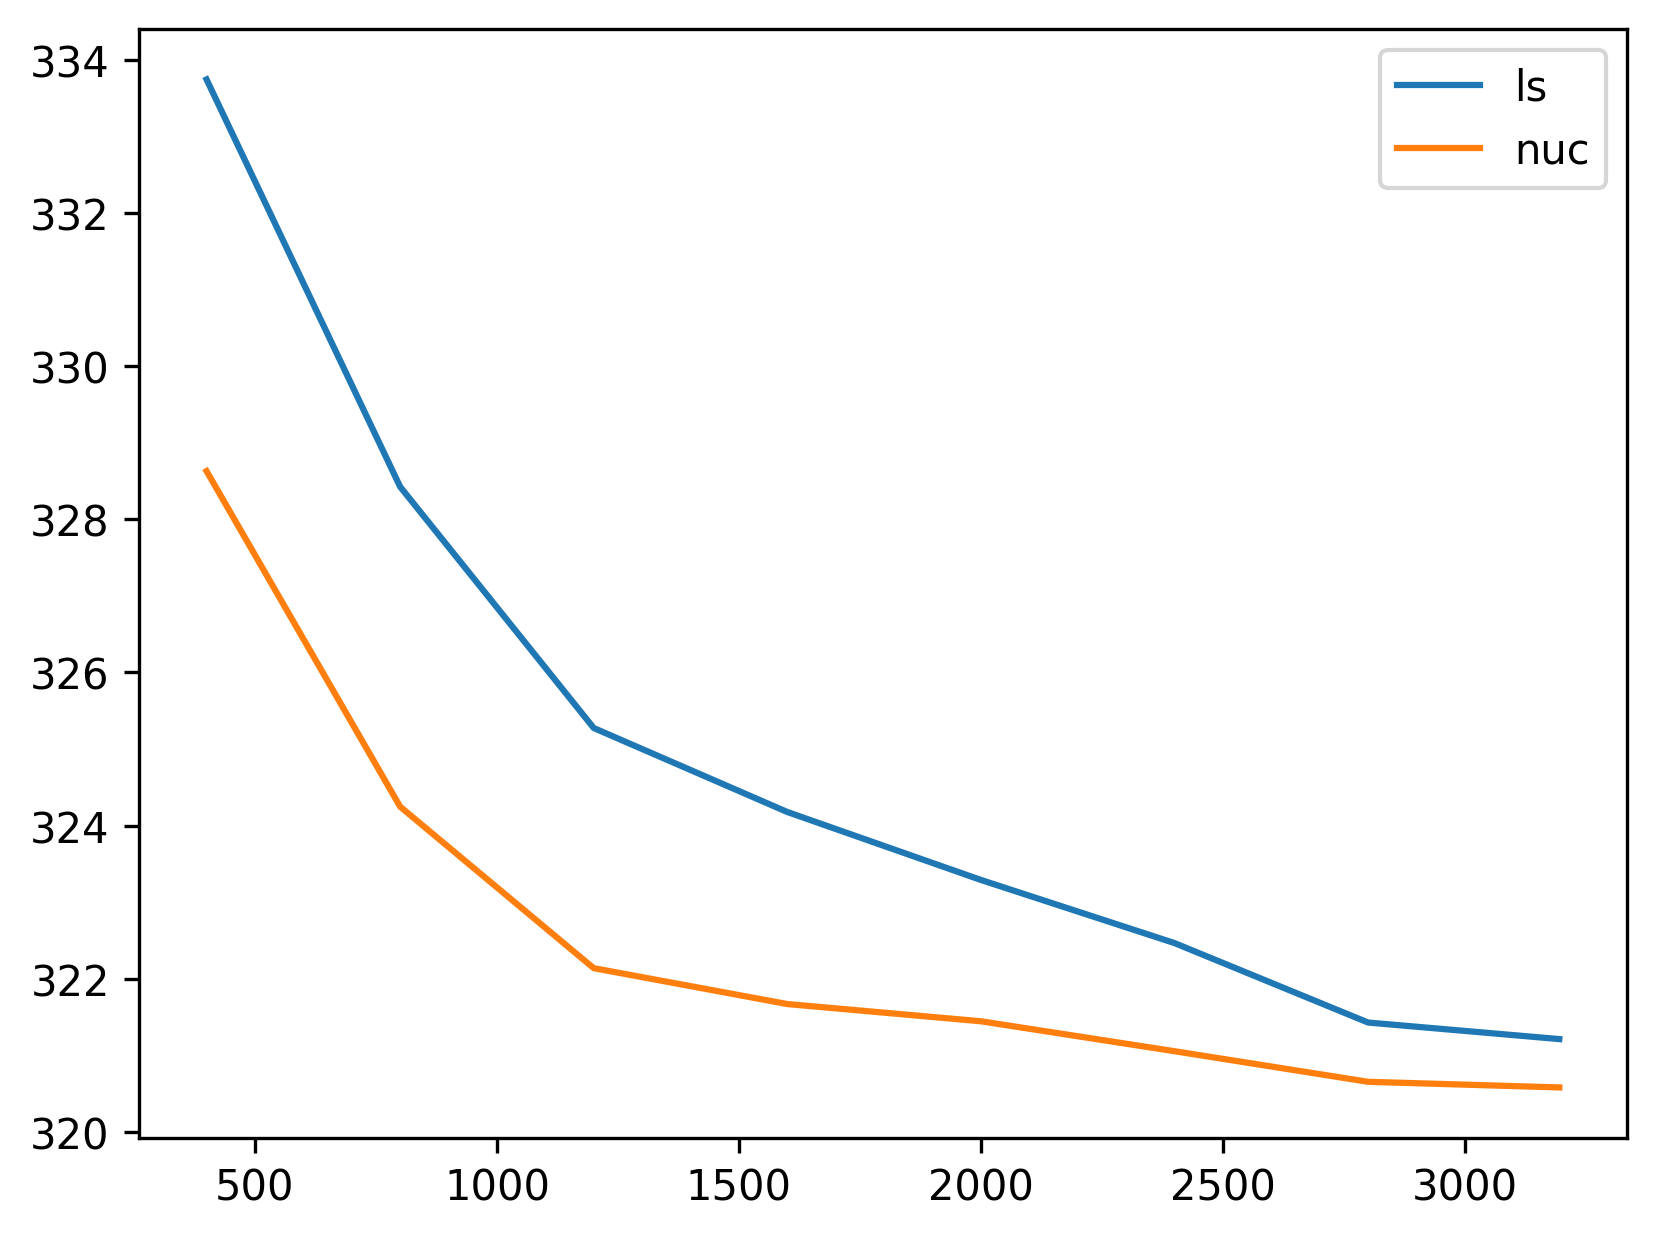

In [278]:
# plt.plot(results_passive['time'],error_passive,label='passive')
# plt.plot(results_active['time'],error_active,label='active')
# plt.legend()
# plt.show()
# print(error_passive,error_active)

# _,S,_ = la.svd(Wtrue)
# print(S.sum())
# _,S,_ = la.svd(Bhat)
# print(S.sum())
# print(results_passive['ls_mse'],results_passive['nuc_mse'])
plt.plot(results_passive['time'],results_passive['nl_mse'],label='ls')
plt.plot(results_active['time'],results_passive['nl_nuc_mse'],label='nuc')
plt.legend()
plt.show()

# mse = data.evaluate(np.zeros(Ghat.shape), roc=False)
# print(mse)

In [238]:
print(results_passive['ls_mse'])
print(B_gt)

[371.03428607067815, 341.4029517678362, 332.9211894657738, 329.0153024660699, 326.16646226576626, 324.2853068765352, 323.8680729598142, nan, nan]
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan 

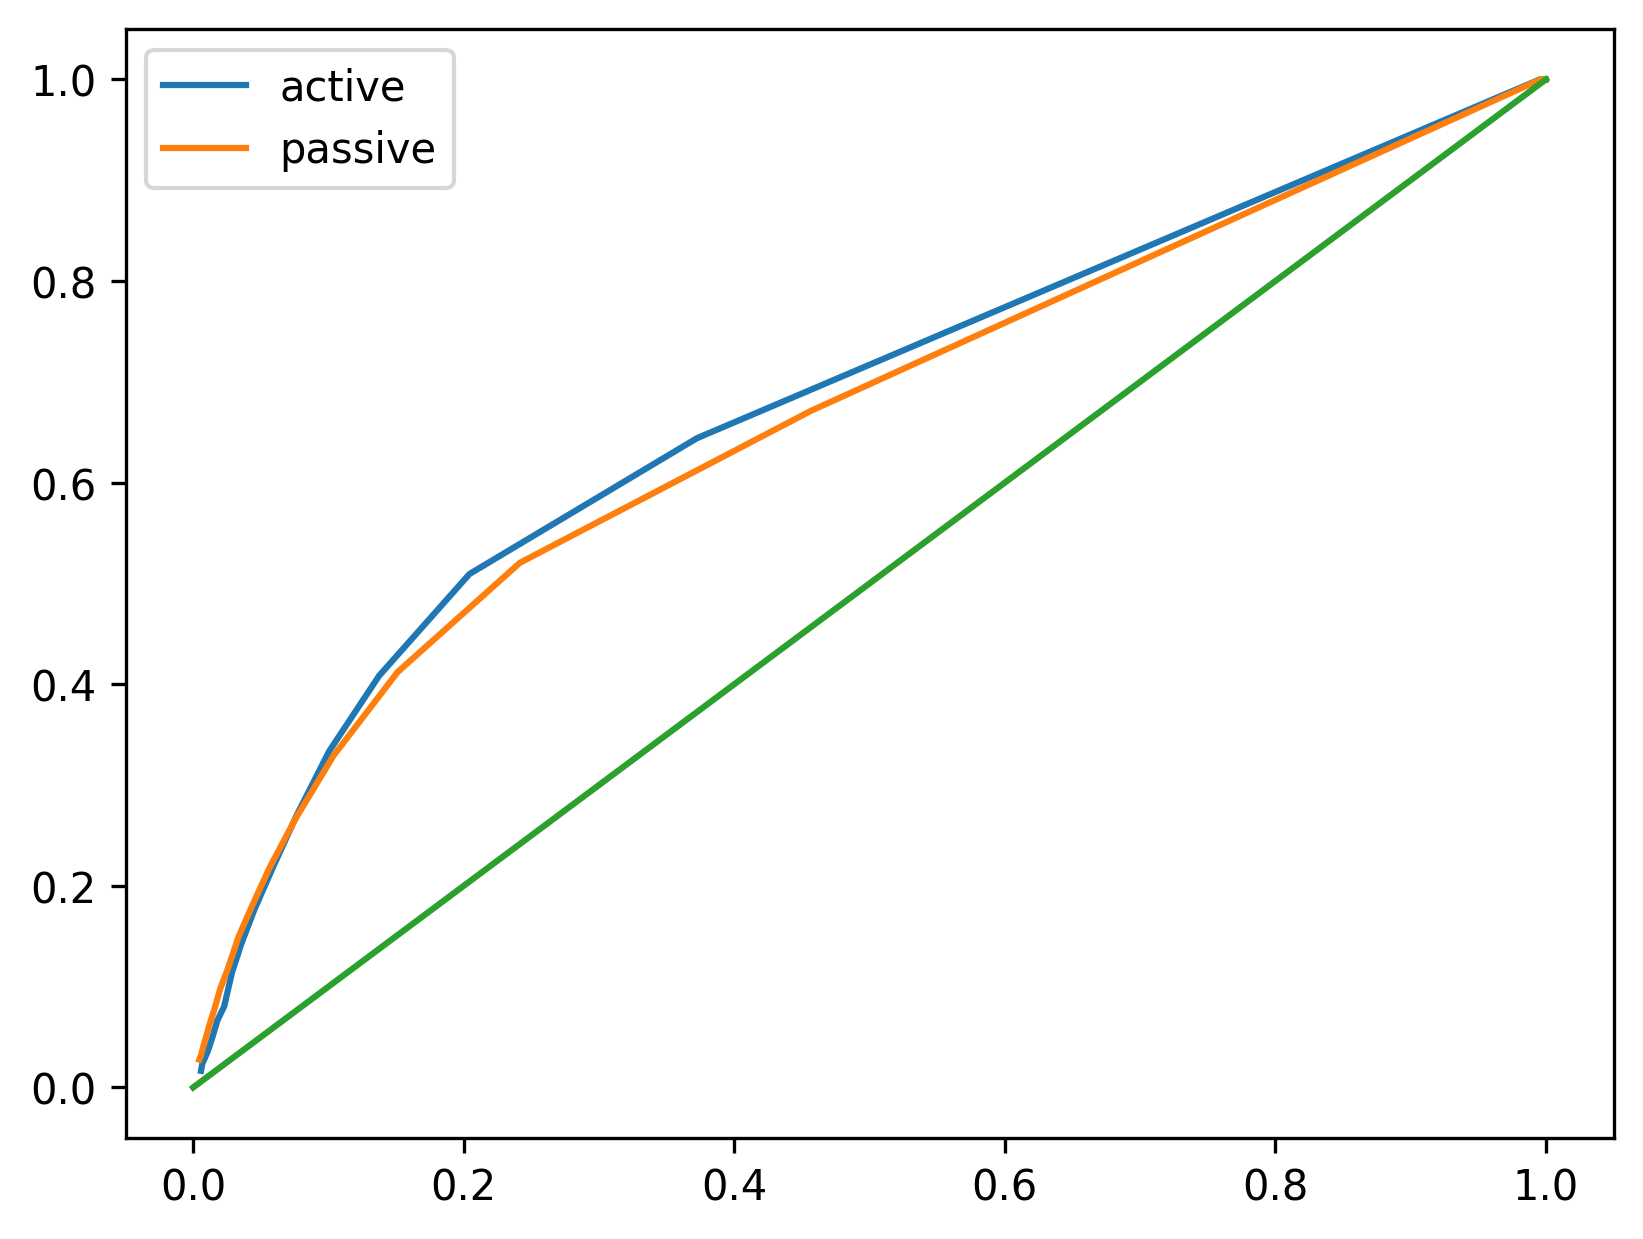

In [169]:
plt.plot(fpr_a,tpr_a,label='active')
import copy
# fpr_p300 = copy.copy(fpr_p)
# tpr_p300 = copy.copy(tpr_p)
#plt.plot(fpr_p1000,tpr_p1000,label='1000')
#plt.plot(fpr_p3000,tpr_p3000,label='3000')
#plt.plot(fpr_p300,tpr_p300,label='300')
plt.plot(fpr_p,tpr_p,label='passive')
plt.plot([0,1],[0,1])
plt.legend()
plt.show()

In [18]:
def compute_transfer_matrix2(Ahat,rollout_len,k=5):
    avg_connect_ark = np.zeros((d,d))
    #rollout_len = 15
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(np.zeros((d,d)))
        A_params.insert(0,Ahat[:,i*d:(i+1)*d])
        B_params.insert(0,Ahat[:,d*k+i*d:d*k+(i+1)*d])

    for t in range(rollout_len):
        param_new = np.zeros((d,d))
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t] 
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark


Ghat = Ghat_passive
num_neurons = Ghat.shape[0]
d = num_neurons
k = 1
Ast_new = np.zeros((num_neurons,2*k*num_neurons+1))
for i in range(2*k):
    Ast_new[:,i*num_neurons:(i+1)*num_neurons] = Ghat[0:num_neurons,i*d:i*d+num_neurons]
Ast_new[:,-1] = Ghat[0:num_neurons,-1]

def compute_transfer_gt(Ast_new):
    transfer_gt = compute_transfer_matrix2(Ast_new, rollout_len=15, k=k)
    transfer_gt += compute_transfer_matrix2(Ast_new, rollout_len=14, k=k)
    transfer_gt += compute_transfer_matrix2(Ast_new, rollout_len=13, k=k)
    return transfer_gt

What = compute_transfer_gt(Ast_new)

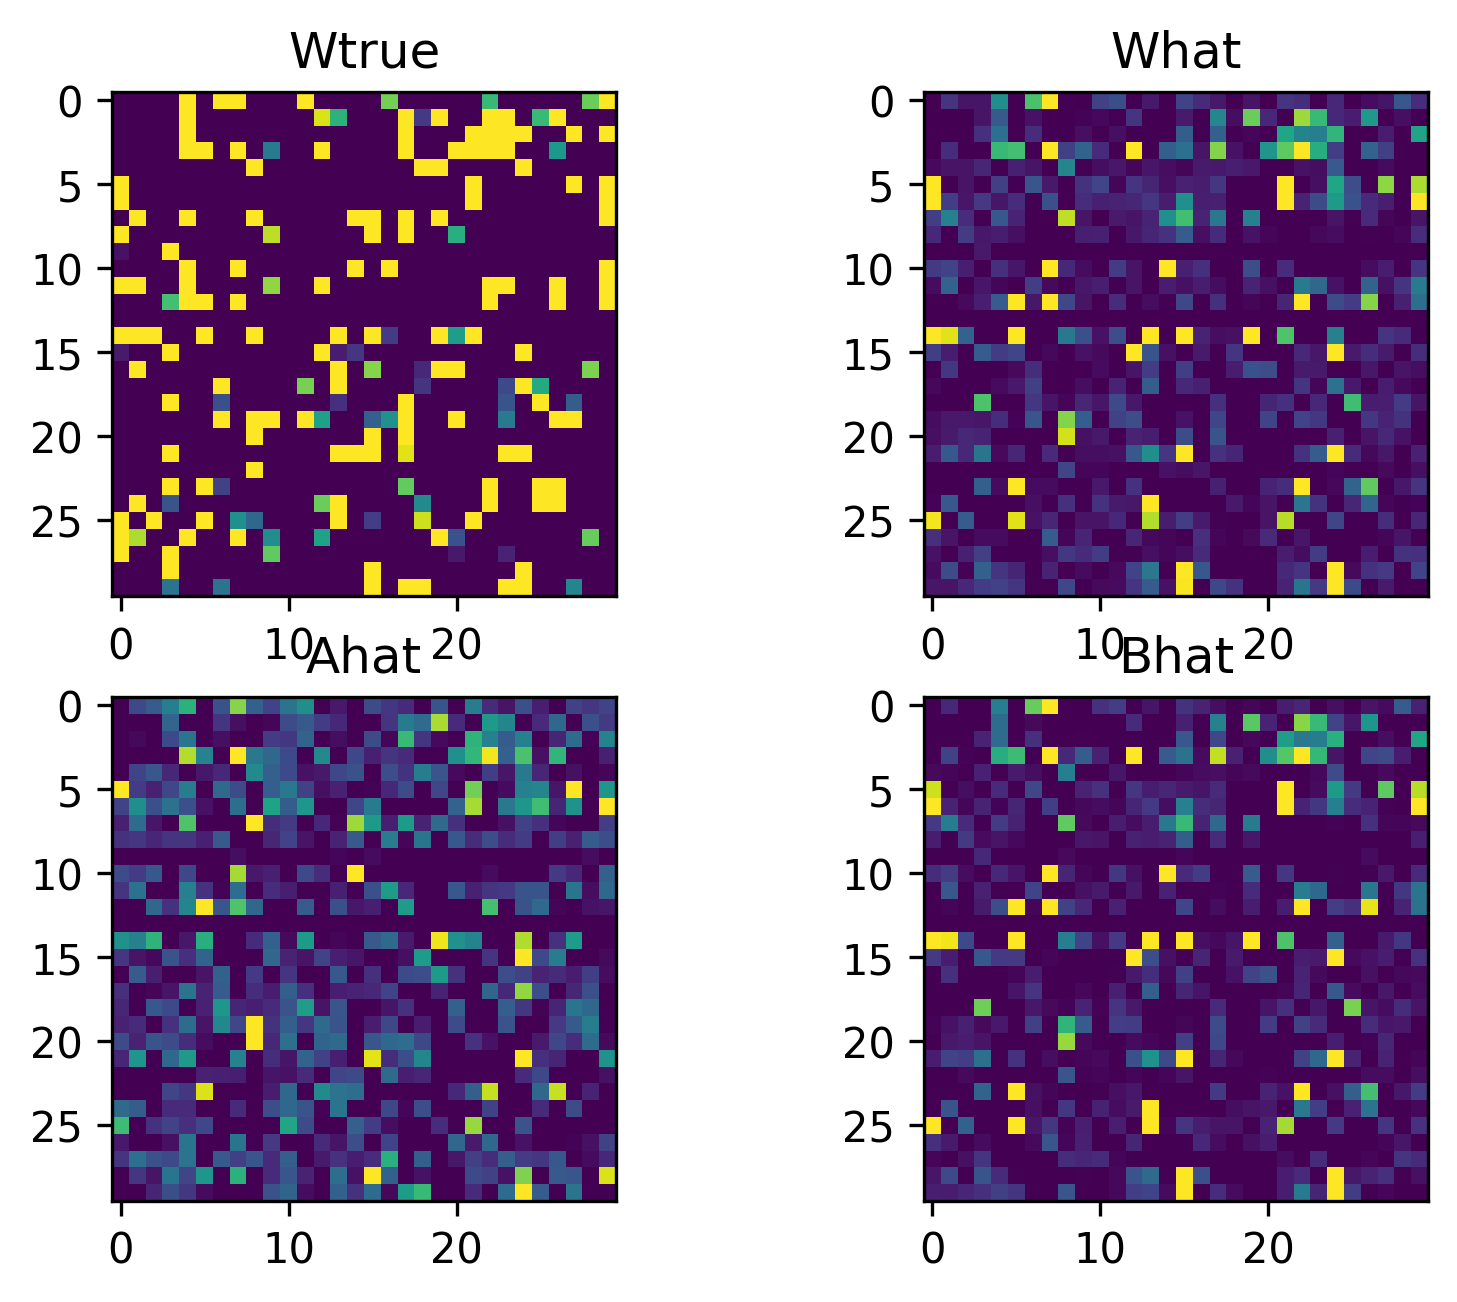

In [63]:
import matplotlib.colors as colors
import numpy.linalg as la

plt.subplot(2,2,1)
plt.title('Wtrue')
plt.imshow(Wtrue/la.norm(Wtrue), norm=colors.Normalize(vmin=0.0, vmax=.01))

plt.subplot(2,2,2)
plt.title('What')
What2 = What - np.diag(np.diag(What))
plt.imshow(What2/la.norm(What2), norm=colors.Normalize(vmin=0.0, vmax=.1))

plt.subplot(2,2,3)
plt.title('Ahat')
Ahat2 = Ahat - np.diag(np.diag(Ahat))
plt.imshow(Ahat2/la.norm(Ahat2), norm=colors.Normalize(vmin=0.0, vmax=.1))

plt.subplot(2,2,4)
plt.title('Bhat')
Bhat2 = Bhat - np.diag(np.diag(Bhat))
plt.imshow(Bhat2/la.norm(Bhat2), norm=colors.Normalize(vmin=0.0, vmax=.1))

0.46153846153846156 0.12427409988385599


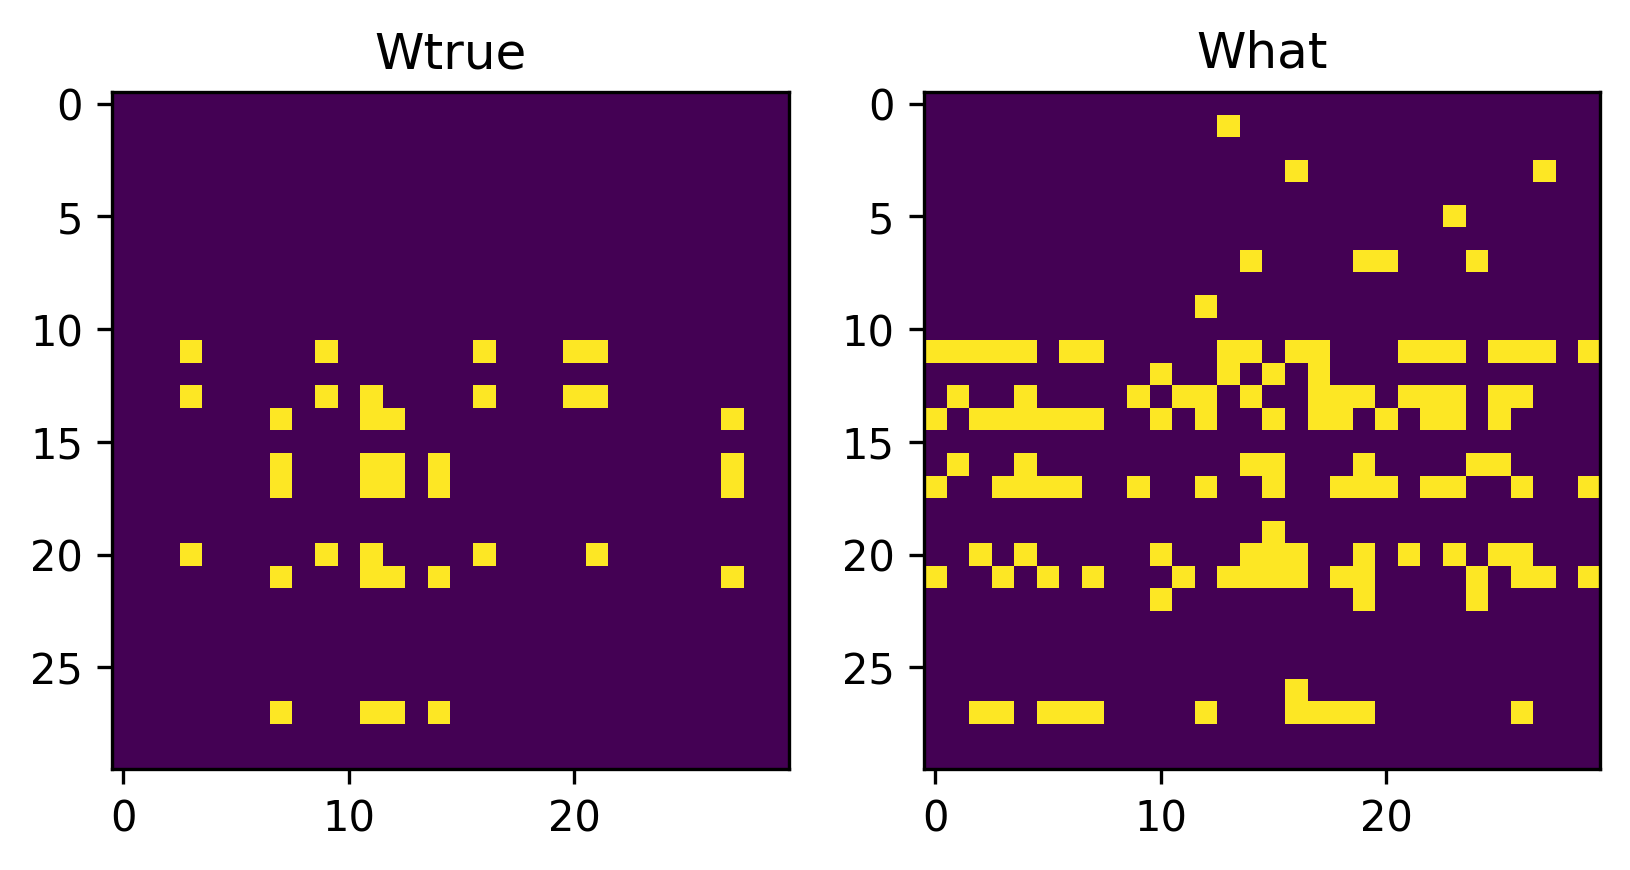

In [181]:
plt.subplot(1,2,1)
plt.title('Wtrue')
Wtrue_std = np.std(Wtrue.flatten())
Wtrue_threshold = np.logical_or(Wtrue > Wtrue_std + Wtrue.mean(), Wtrue < -Wtrue_std + Wtrue.mean())
plt.imshow(Wtrue_threshold, norm=colors.Normalize(vmin=0.0, vmax=.01))

plt.subplot(1,2,2)
plt.title('What')
What2 = What - np.diag(np.diag(What))
What_std = np.std(What2.flatten())
tolerance = 1
What_threshold = np.logical_or(What2 > tolerance*What_std + What2.mean(), What < -tolerance*What_std + What2.mean())
plt.imshow(What_threshold, norm=colors.Normalize(vmin=0.0, vmax=.01))

tpr = np.sum(np.logical_and(Wtrue_threshold, What_threshold)) / np.sum(Wtrue_threshold)
fpr = np.sum(np.logical_and(~Wtrue_threshold, What_threshold)) / np.sum(~Wtrue_threshold)
print(tpr,fpr)

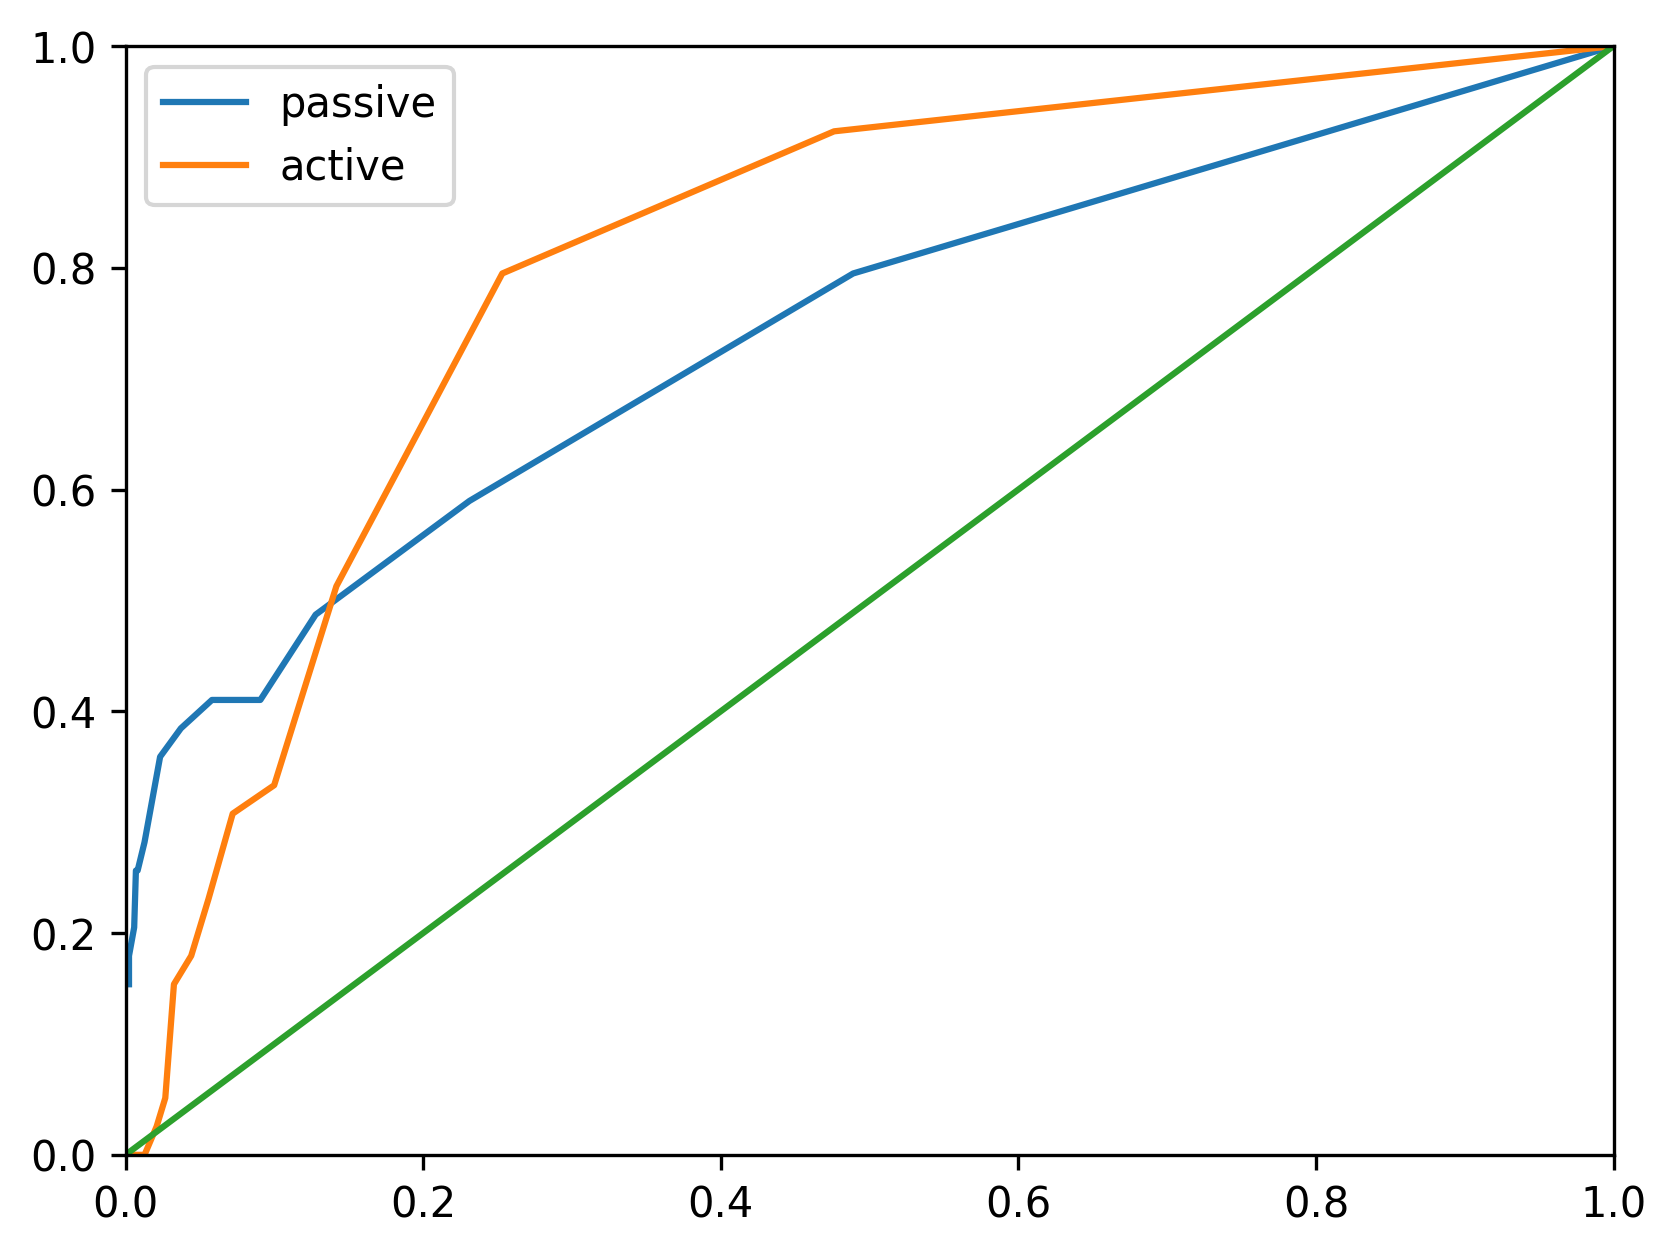

In [184]:
import copy

thresholds = np.linspace(-1,5,20)
tprs = []
fprs = []

for t in range(len(thresholds)):
    Wtrue_std = np.std(Wtrue.flatten())
    Wtrue_threshold = np.logical_or(Wtrue > Wtrue_std + Wtrue.mean(), Wtrue < -Wtrue_std + Wtrue.mean())

    What2 = What - np.diag(np.diag(What))
    What_std = np.std(What2.flatten())
    tolerance = thresholds[t]
    What_threshold = np.logical_or(What2 > tolerance*What_std + What2.mean(), What < -tolerance*What_std + What2.mean())

    tpr = np.sum(np.logical_and(Wtrue_threshold, What_threshold)) / np.sum(Wtrue_threshold)
    fpr = np.sum(np.logical_and(~Wtrue_threshold, What_threshold)) / np.sum(~Wtrue_threshold)
    tprs.append(tpr)
    fprs.append(fpr)
    
plt.figure()
plt.plot(fprs,tprs,label='passive')
plt.plot(fprs_active,tprs_active,label='active')
plt.plot([0,1],[0,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()
# fprs_active = copy.copy(fprs)
# tprs_active = copy.copy(tprs)

In [19]:
def compute_roc(Ghat):
    num_neurons = Ghat.shape[0]
    d = num_neurons
    k = 1
    Ast_new = np.zeros((num_neurons,2*k*num_neurons+1))
    for i in range(2*k):
        Ast_new[:,i*num_neurons:(i+1)*num_neurons] = Ghat[0:num_neurons,i*d:i*d+num_neurons]
    Ast_new[:,-1] = Ghat[0:num_neurons,-1]
    What = compute_transfer_gt(Ast_new)
    
    thresholds = np.linspace(-1,5,20)
    tprs = []
    fprs = []

    for t in range(len(thresholds)):
        Wtrue_std = np.std(Wtrue.flatten())
        Wtrue_threshold = np.logical_or(Wtrue > Wtrue_std + Wtrue.mean(), Wtrue < -Wtrue_std + Wtrue.mean())

        What2 = What - np.diag(np.diag(What))
        What_std = np.std(What2.flatten())
        tolerance = thresholds[t]
        What_threshold = np.logical_or(What2 > tolerance*What_std + What2.mean(), What < -tolerance*What_std + What2.mean())

        tpr = np.sum(np.logical_and(Wtrue_threshold, What_threshold)) / np.sum(Wtrue_threshold)
        fpr = np.sum(np.logical_and(~Wtrue_threshold, What_threshold)) / np.sum(~Wtrue_threshold)
        tprs.append(tpr)
        fprs.append(fpr)
    return np.array(fprs), np.array(tprs)

# Nonlinear model

In [ ]:
def l1_proj(u_batch, max_on=15):
    if torch.linalg.norm(u_batch, 1) <= max_on:
        return u_batch
    d = u_batch.shape[0]
    u_proj = torch.zeros_like(u_batch)
    sort_idx = torch.argsort(u_batch, descending=True)
    running_sum = 0
    max_j = 0
    max_sum = 0
    for j in range(d):
        uj = u_batch[sort_idx[j]]
        running_sum += uj
        if uj - (running_sum - max_on) / (j+1) > 0:
            max_j = j + 1
            max_sum = running_sum.clone()
    theta = (max_sum - max_on) / max_j
    u_proj = u_batch - theta
    u_proj.clamp_(min=0)
    return u_proj


def fit_glm(X,Y,n_iters):
    X = torch.tensor(X, device='cuda:0').float()
    Y = torch.tensor(Y, device='cuda:0').float()
    d = X.shape[0]
    
    W = torch.tensor(0.1*torch.randn(d,d), requires_grad=True, dtype=torch.float32)
    optimizer = optim.Adam([W], lr=0.05)
    
    loss_vals = []
    for n in range(n_iters):
        optimizer.zero_grad()
        loss = torch.linalg.norm(Y - torch.sigmoid(W @ X), ord='fro')**2
        #loss = torch.linalg.norm(Y - W @ X, ord='fro')**2
        #loss += 0.0001 * torch.linalg.norm(W, ord='fro')**2
        loss.backward()
        optimizer.step()
        
        loss_vals.append(loss.item())
    plt.plot(loss_vals)
    plt.show()
    return W.detach()


def fit_glm_nuc(X,Y,reg,n_iters):
    X = torch.tensor(X, device='cuda:0').float()
    Y = torch.tensor(Y, device='cuda:0').float()
    d = X.shape[0]
    
    W = torch.tensor(0.1*torch.randn(d,d), requires_grad=True, dtype=torch.float32)
    optimizer = optim.Adam([W], lr=0.05)
    
    loss_vals = []
    for n in range(n_iters):
        optimizer.zero_grad()
        loss = torch.linalg.norm(Y - torch.sigmoid(W @ X), ord='fro')**2
        #loss = torch.linalg.norm(Y - W @ X, ord='fro')**2
        #loss += 0.0001 * torch.linalg.norm(W, ord='fro')**2
        loss.backward()
        optimizer.step()
        loss_vals.append(loss.item())
        with torch.no_grad():
            U,S,V = torch.linalg.svd(W)
            S = l1_proj(S, max_on=reg)
            W.data = U @ torch.diag(S) @ V
    plt.plot(loss_vals)
    plt.show()
    return W.detach()

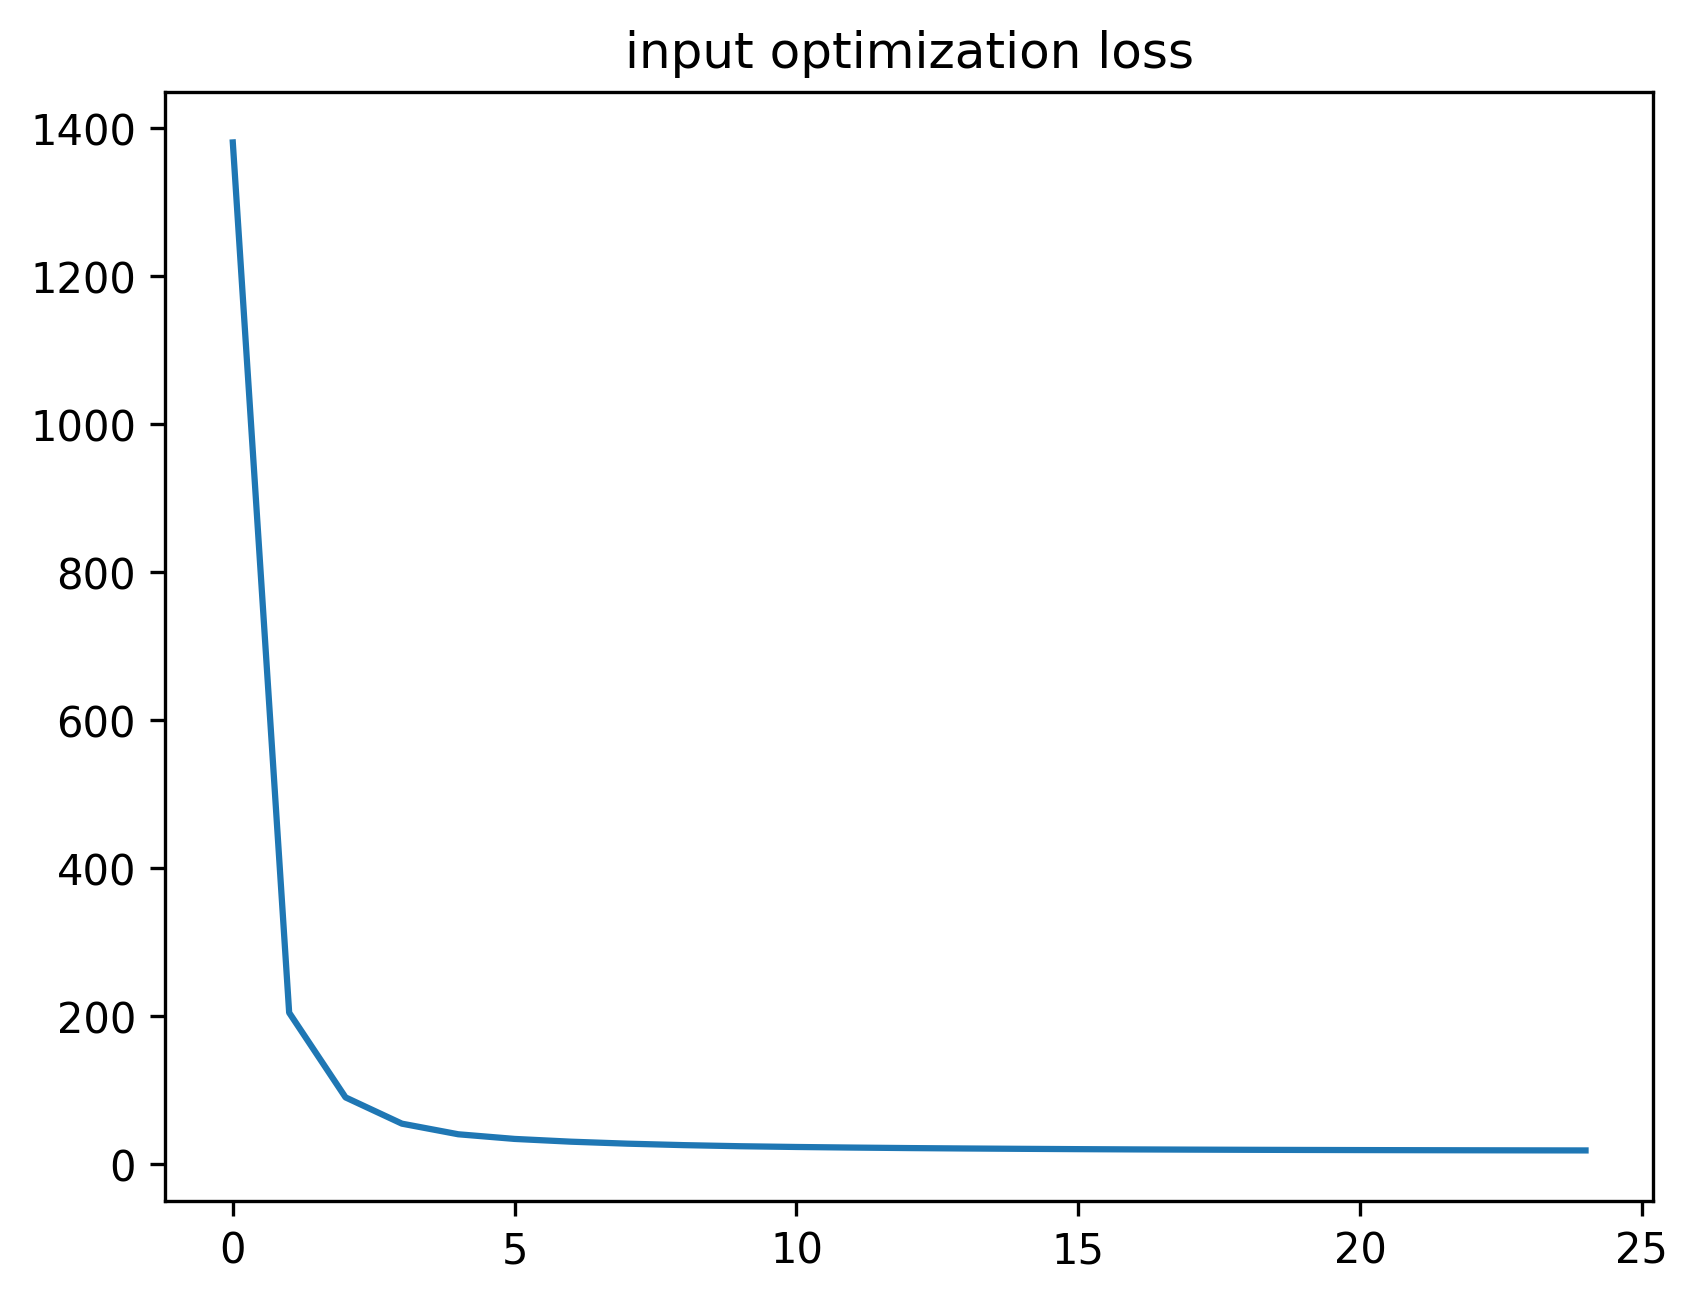

estimating, t = 100
estimating, t = 100


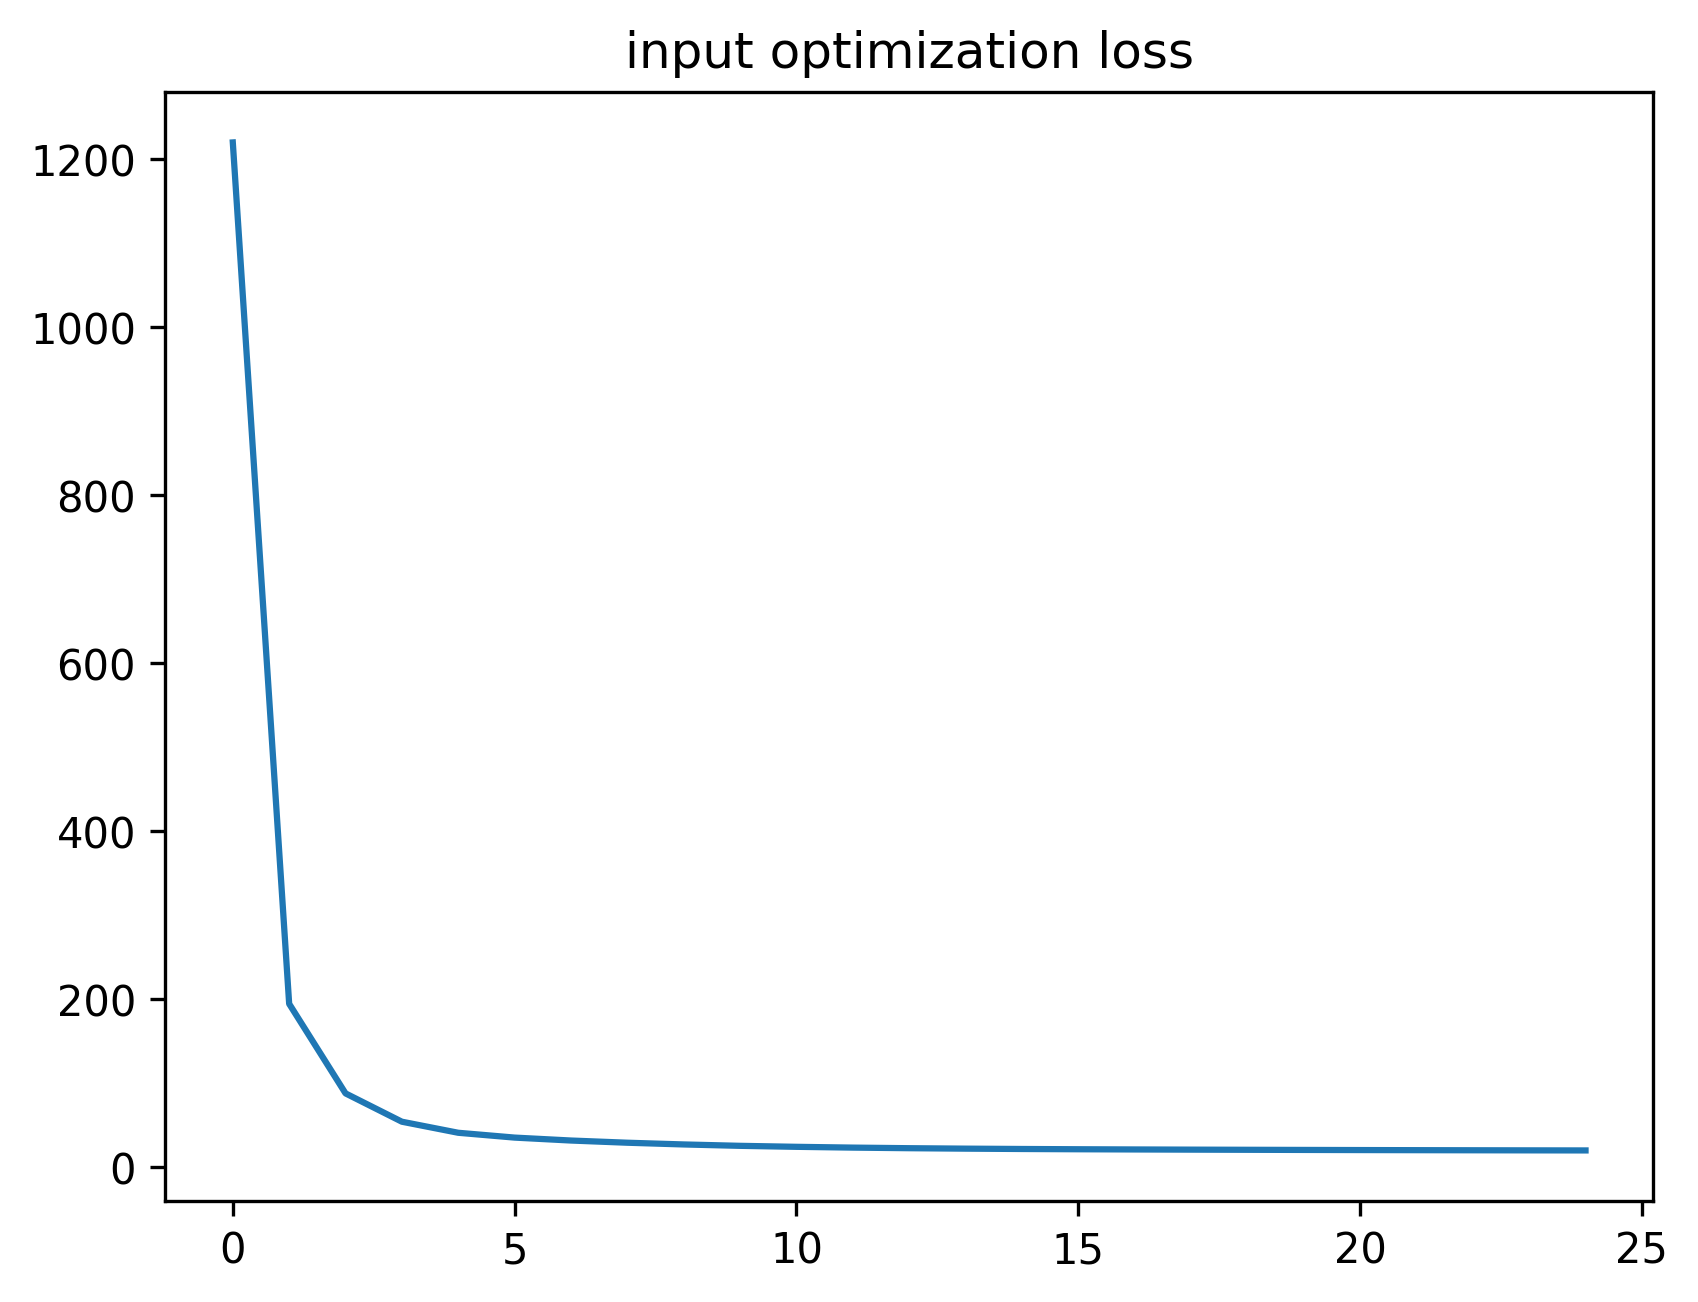

estimating, t = 100
estimating, t = 100


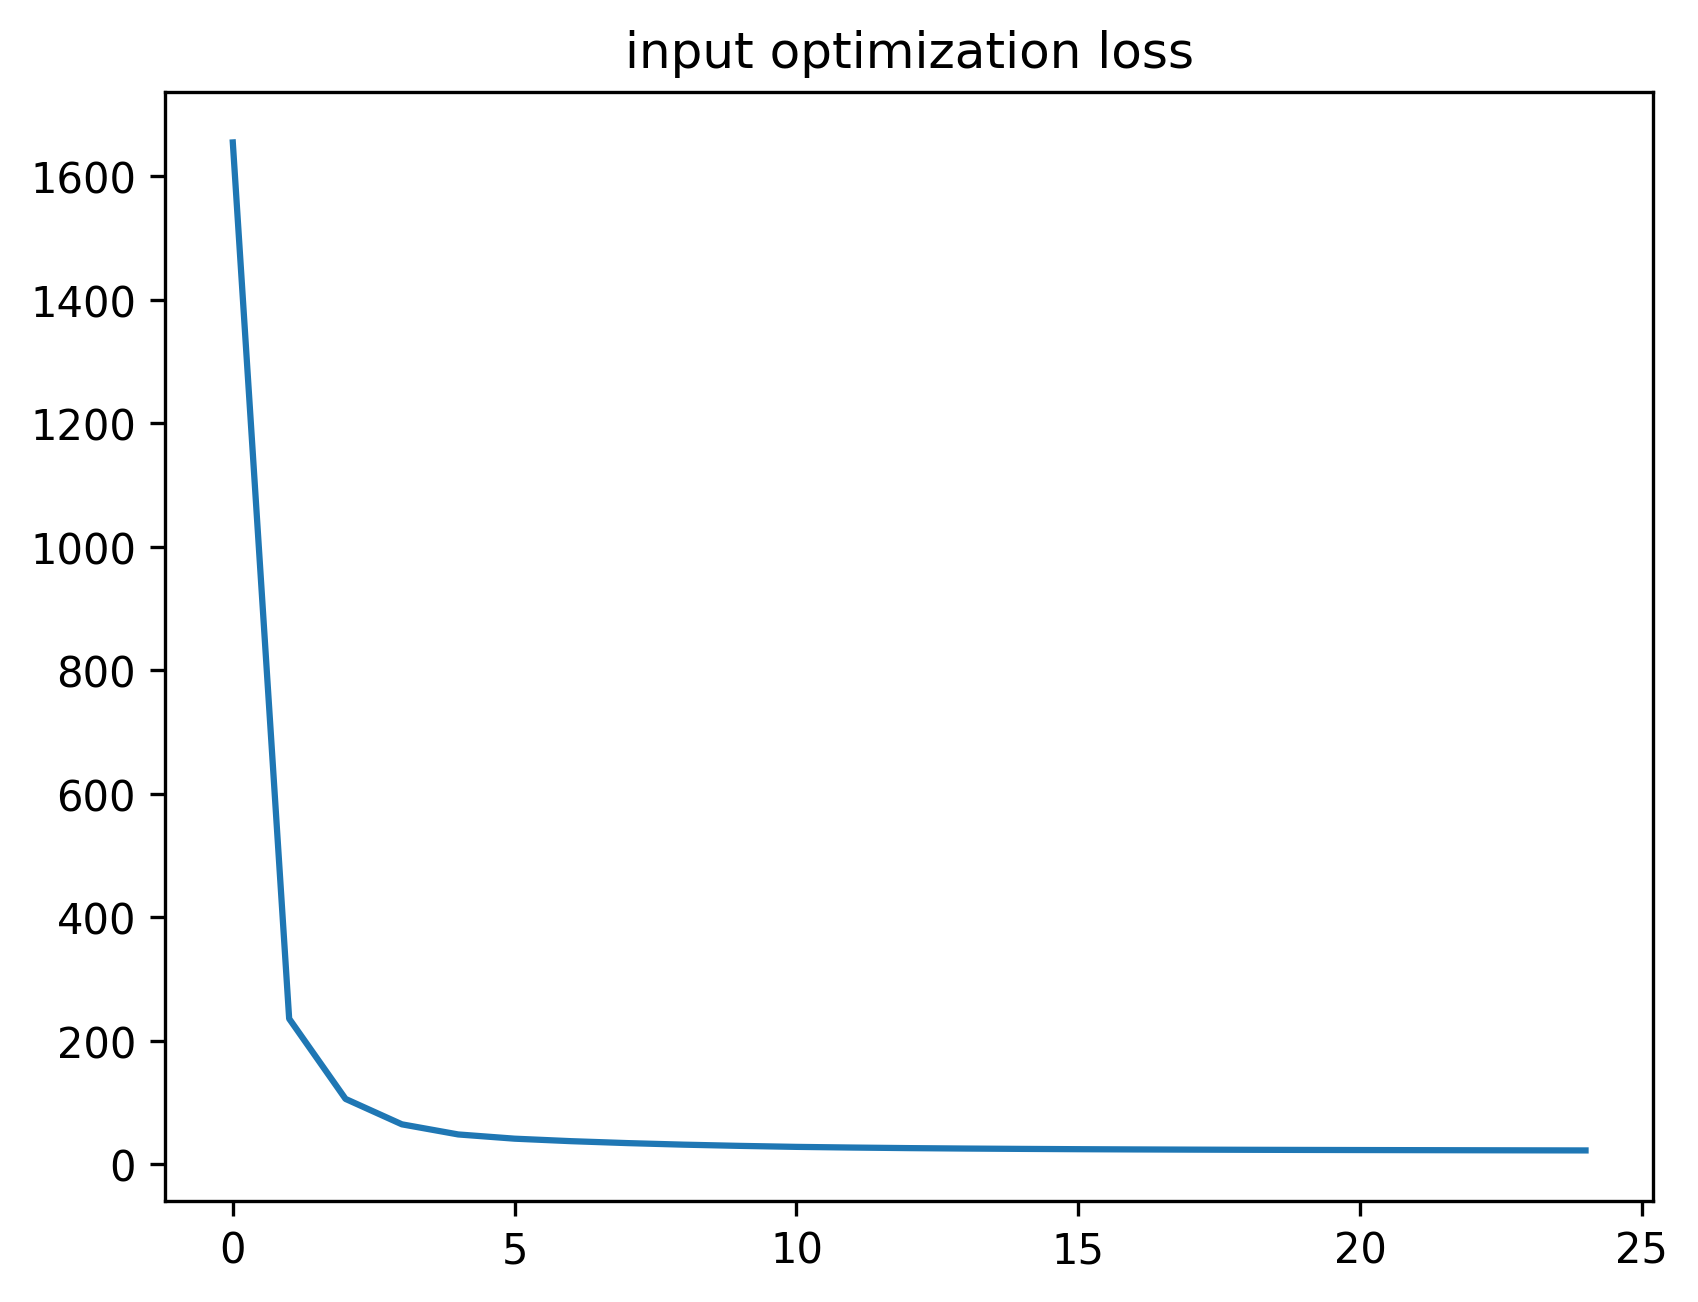

estimating, t = 100
estimating, t = 100


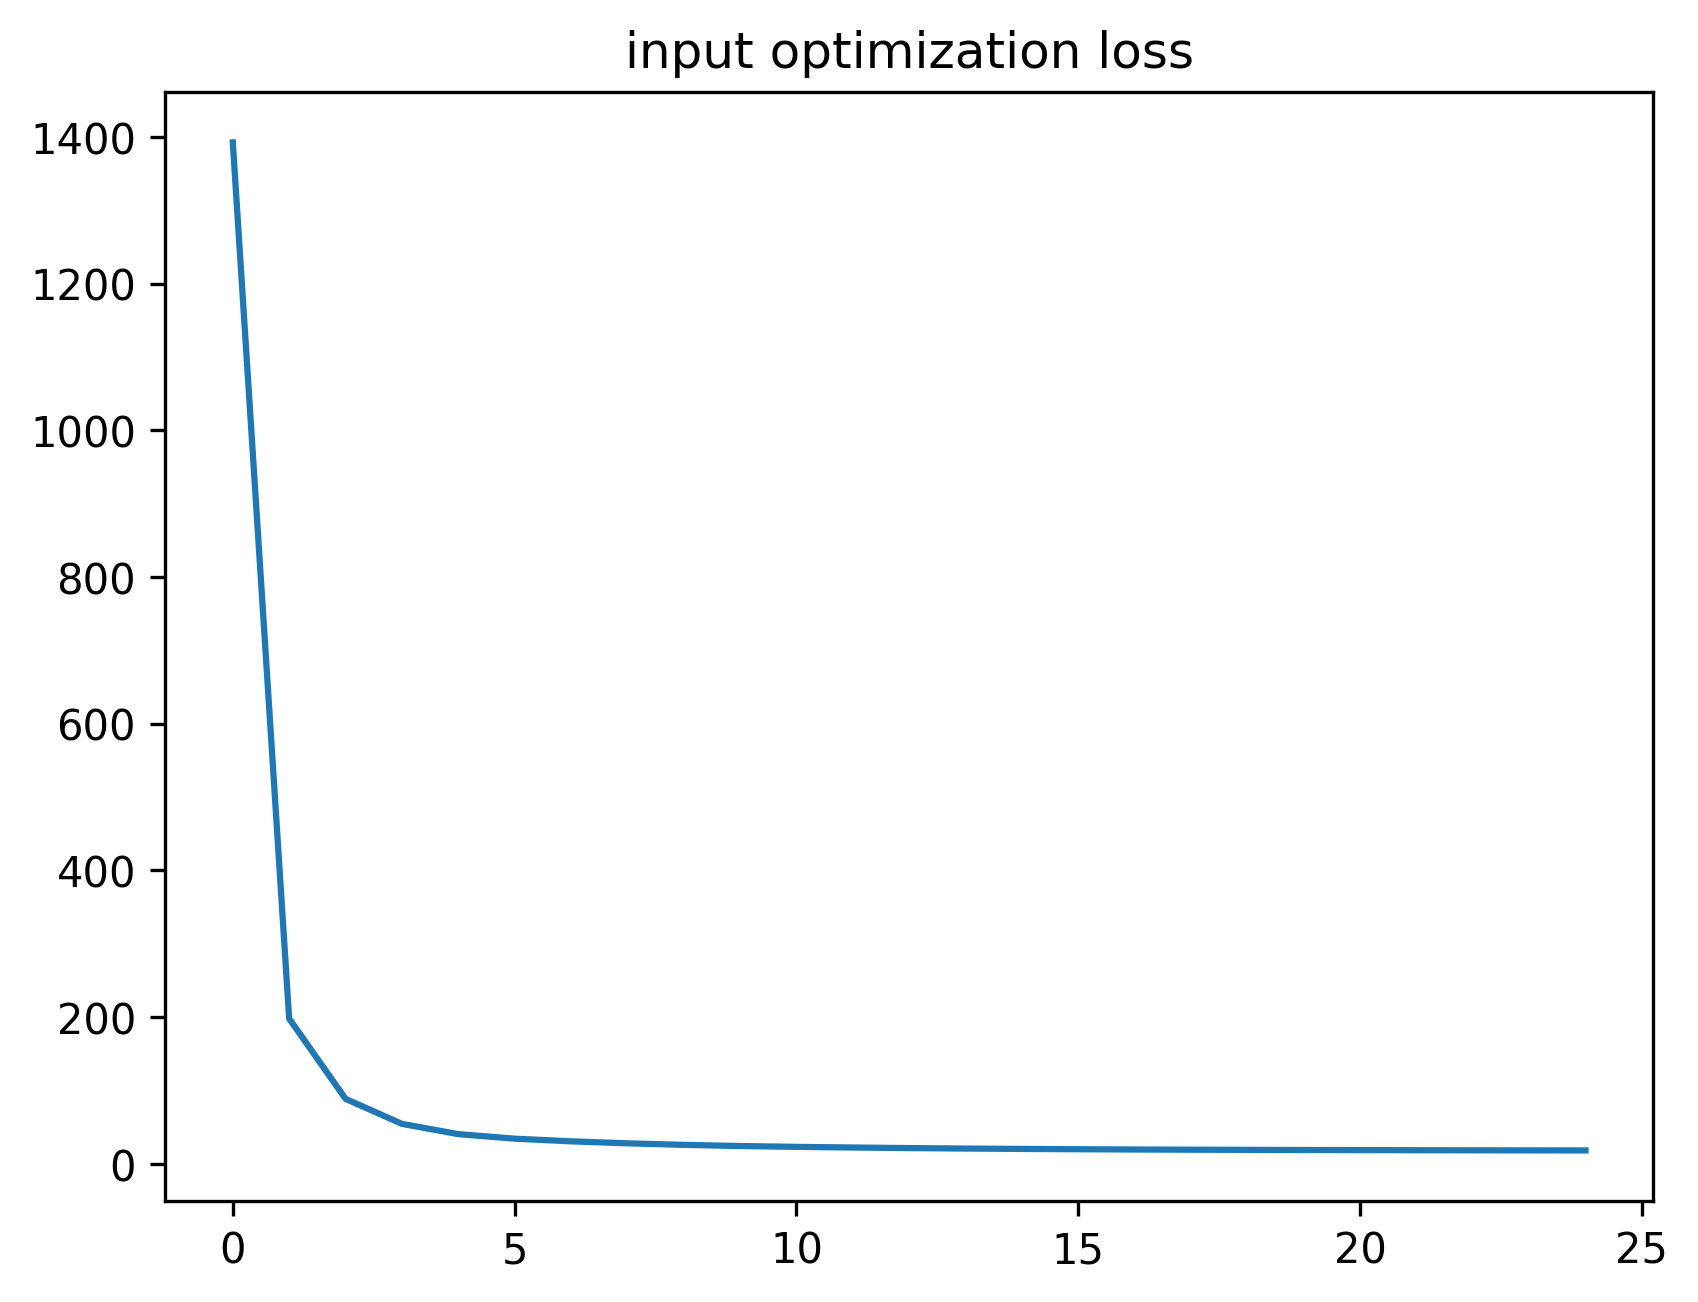

estimating, t = 100
estimating, t = 100


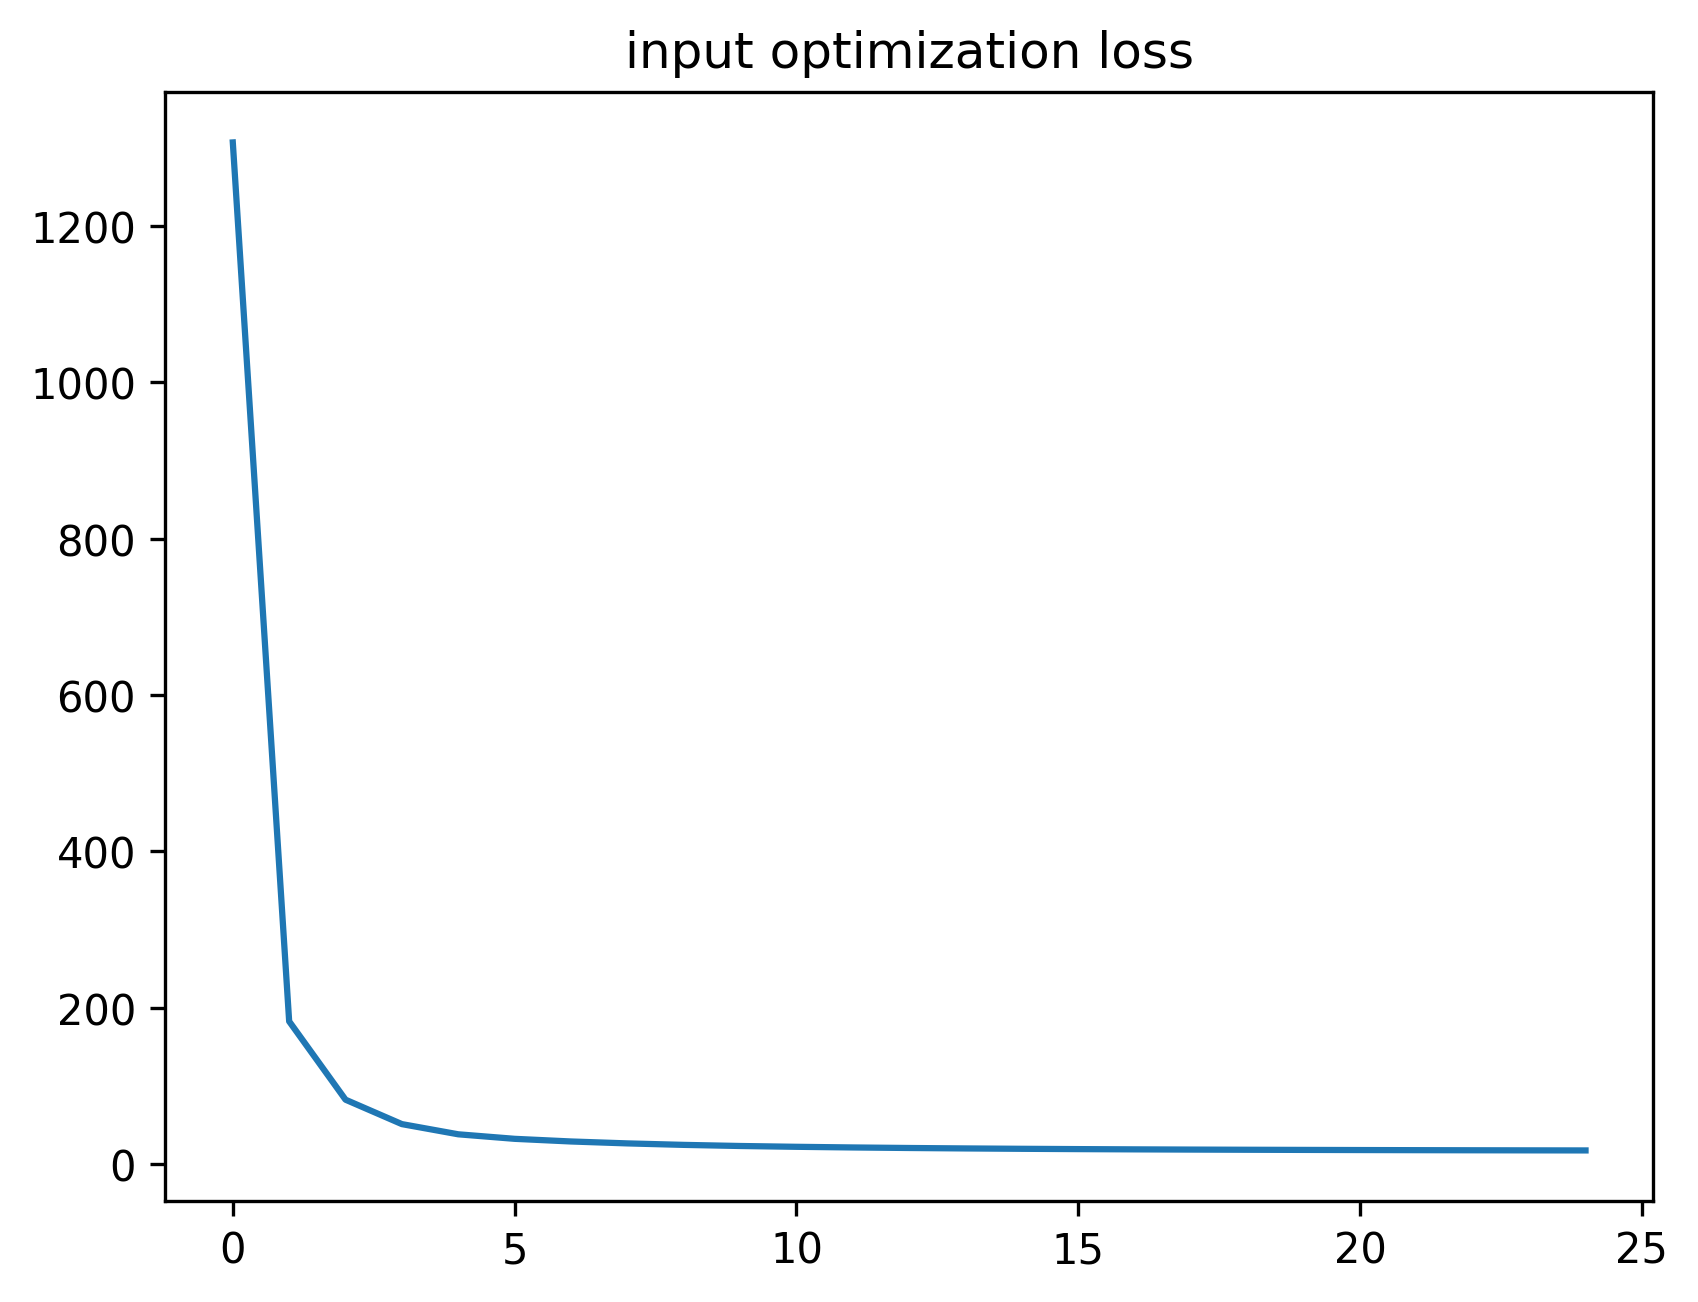

estimating, t = 100
estimating, t = 100


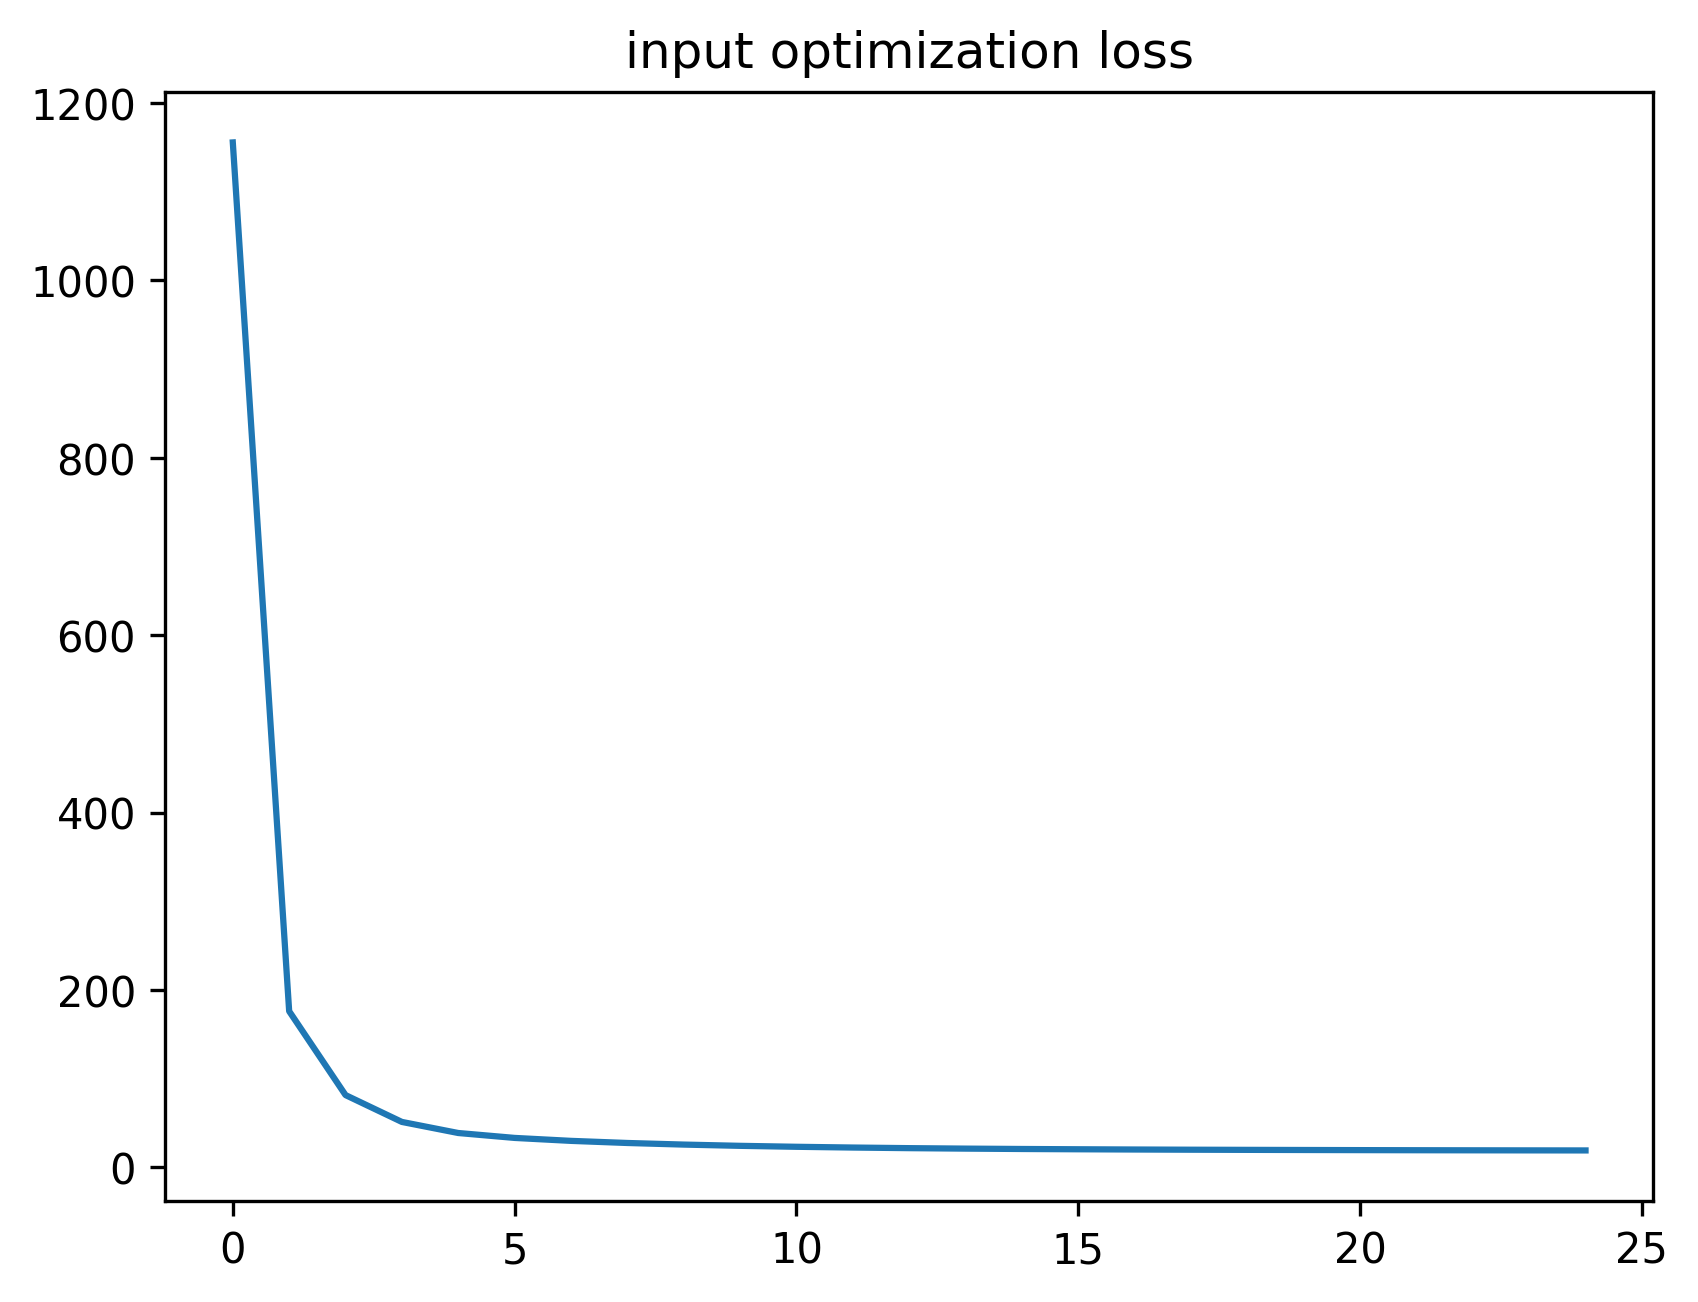

estimating, t = 100
estimating, t = 100


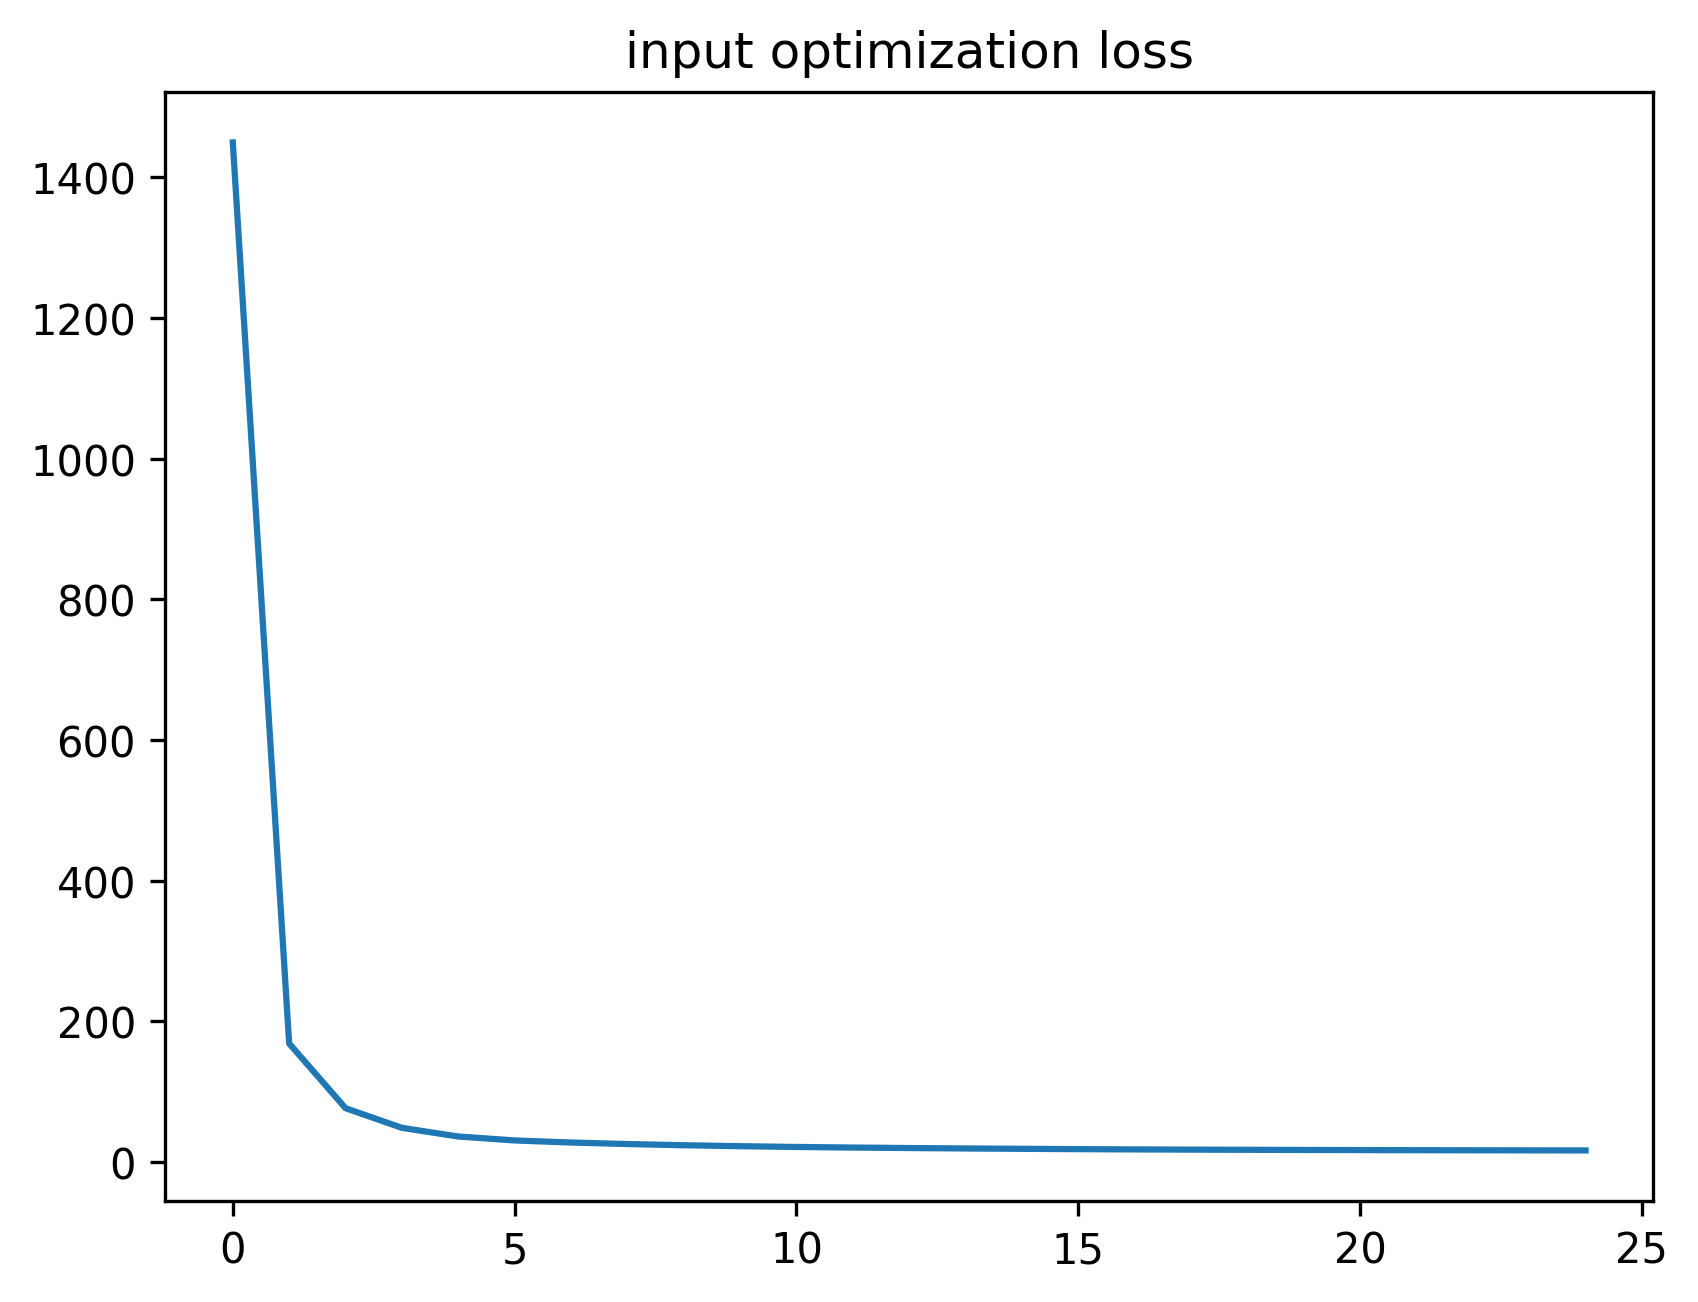

estimating, t = 100
estimating, t = 100


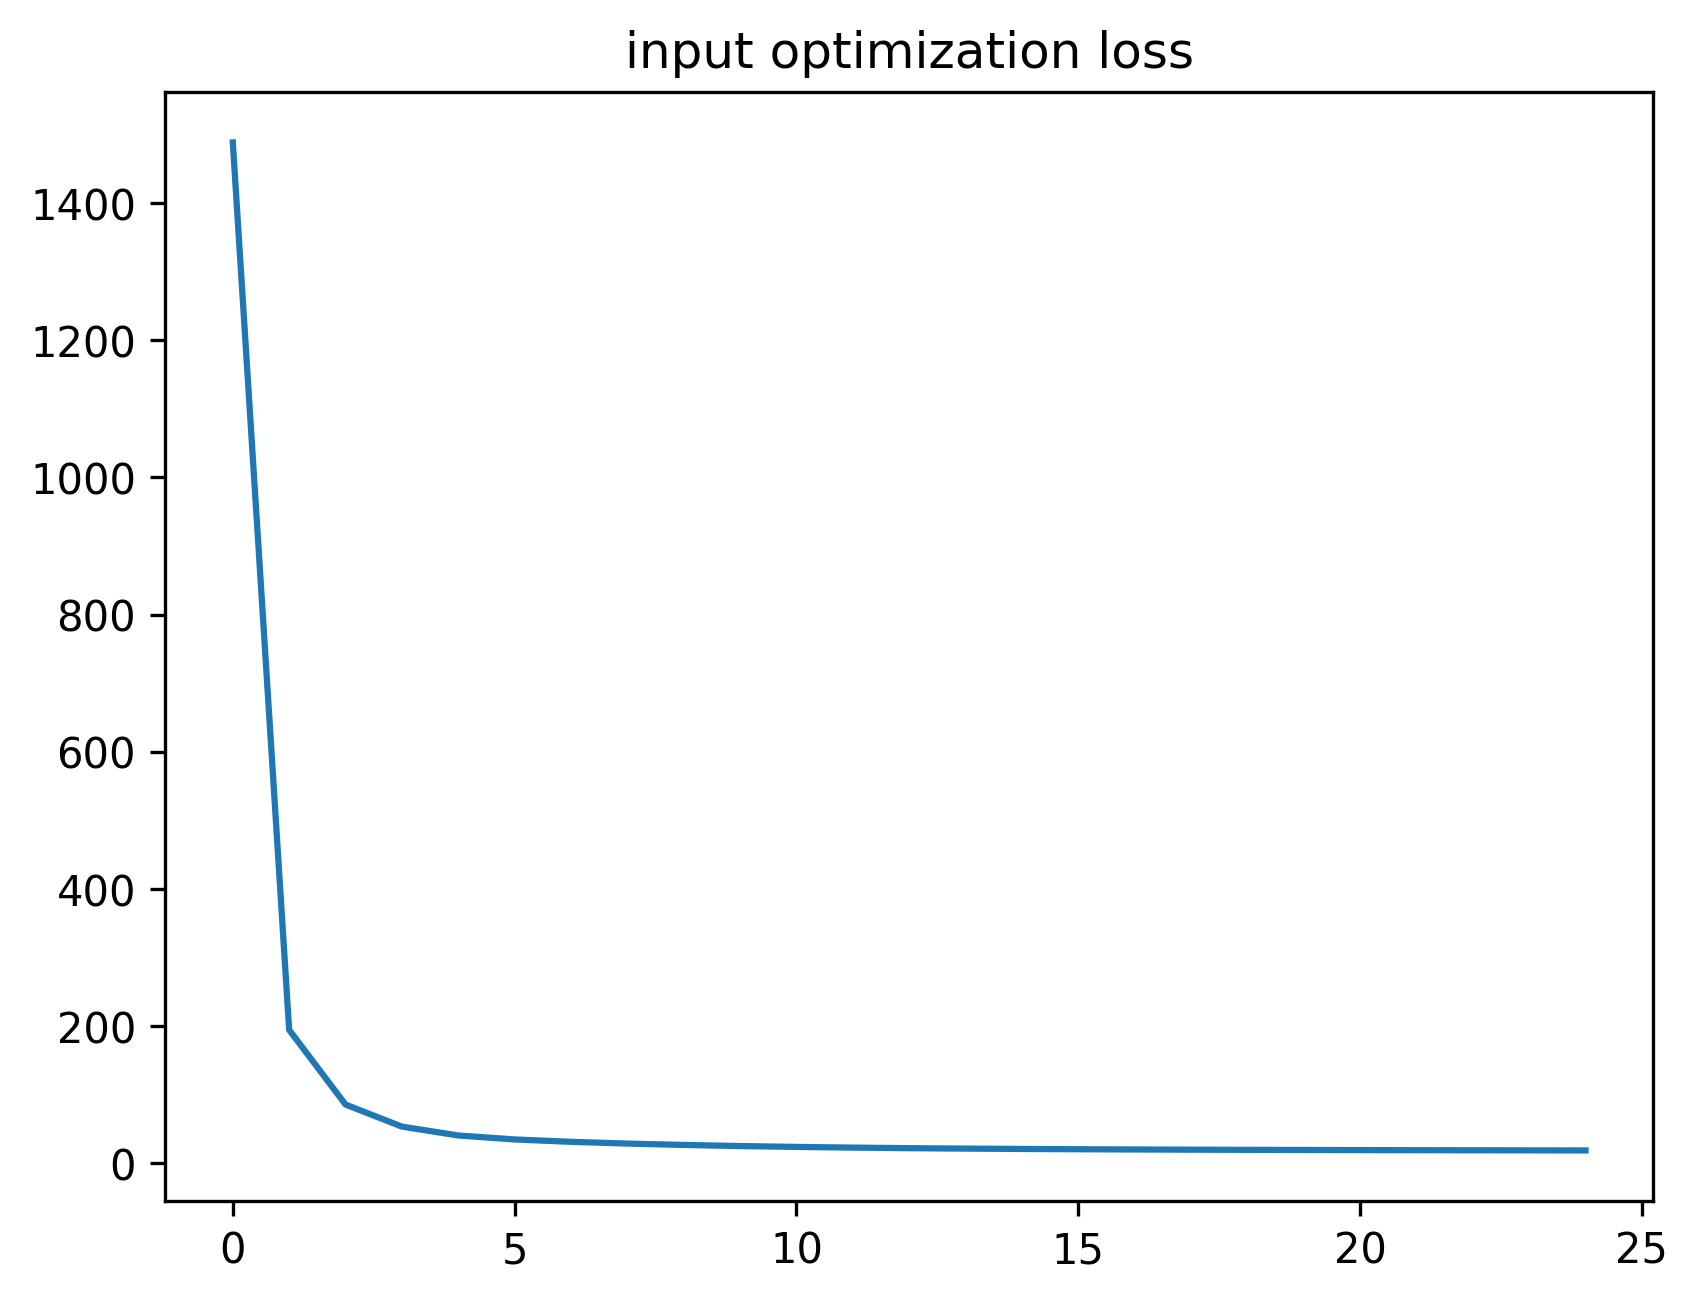

estimating, t = 100
estimating, t = 100


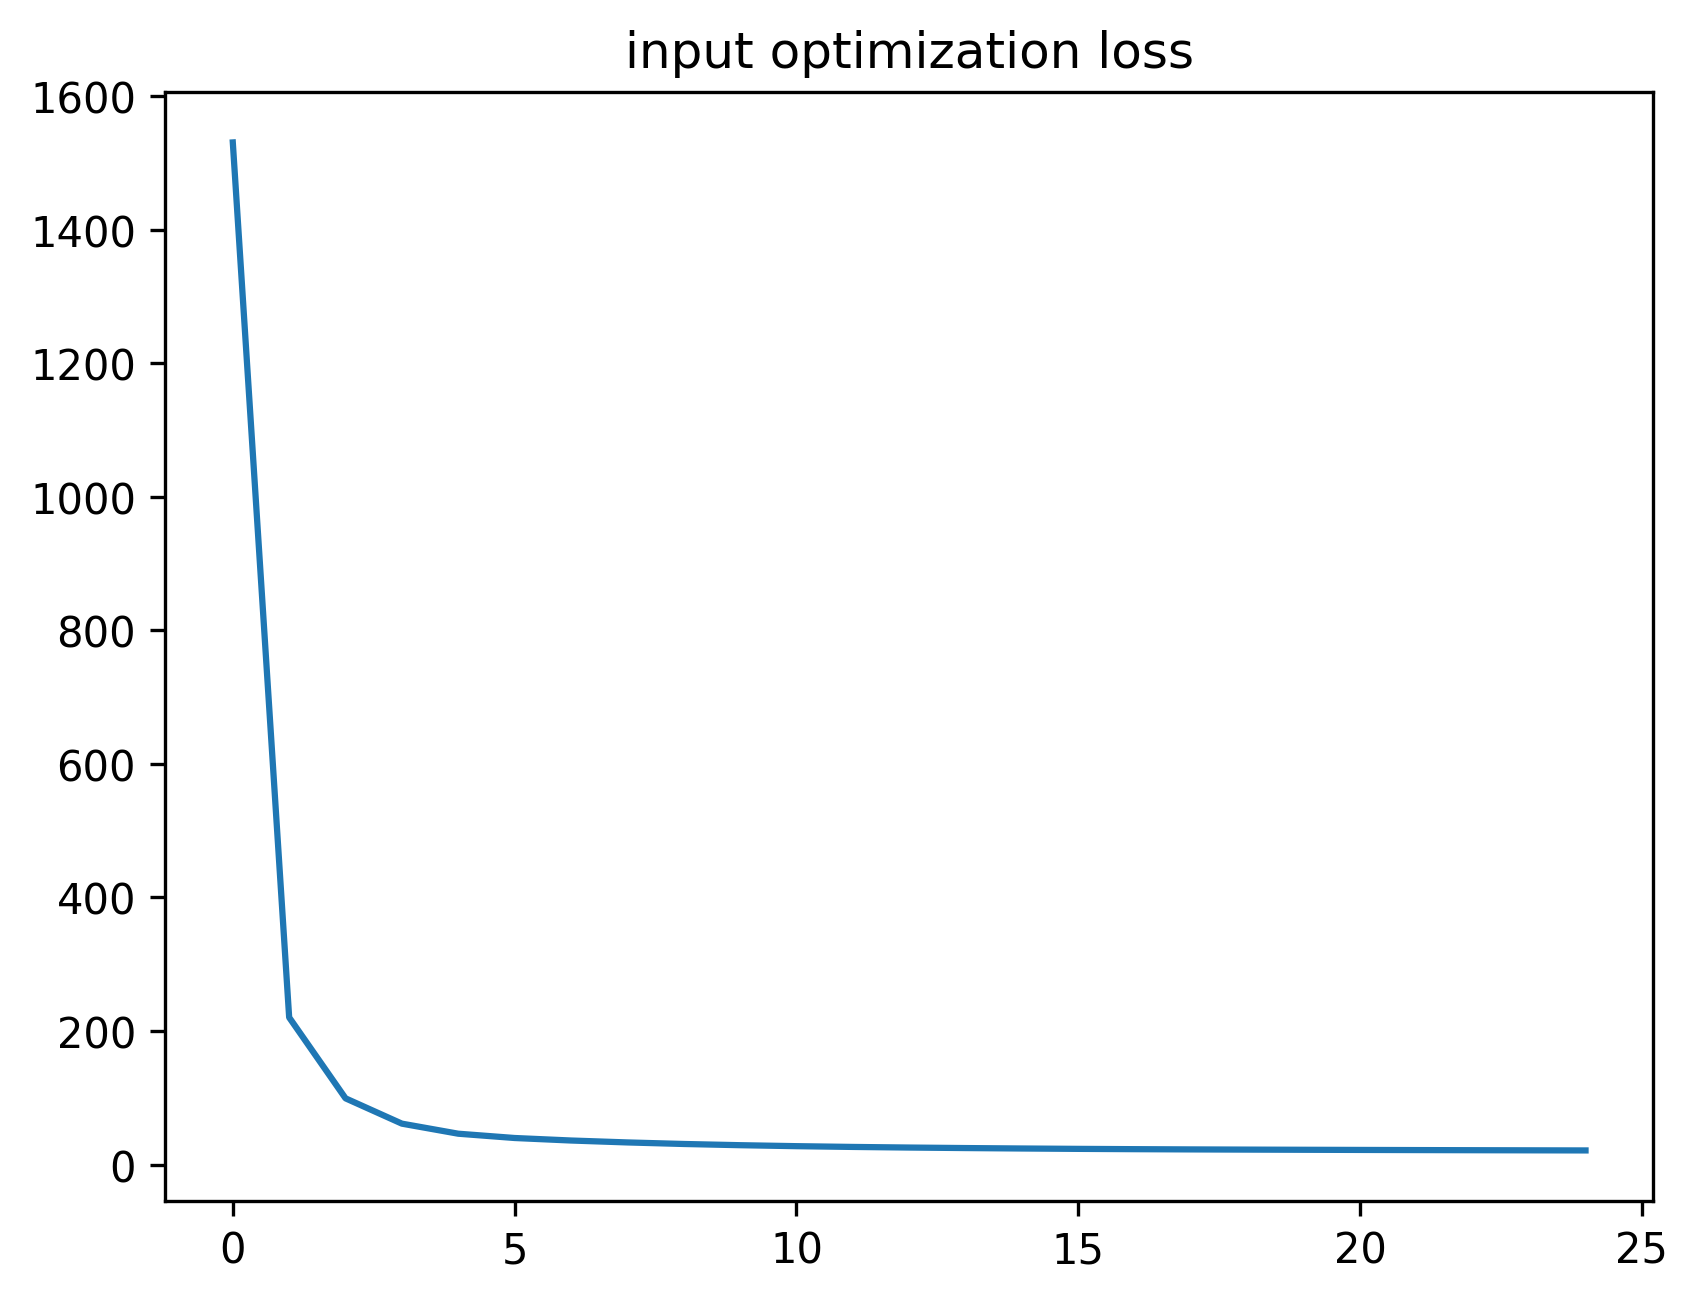

estimating, t = 100
estimating, t = 100


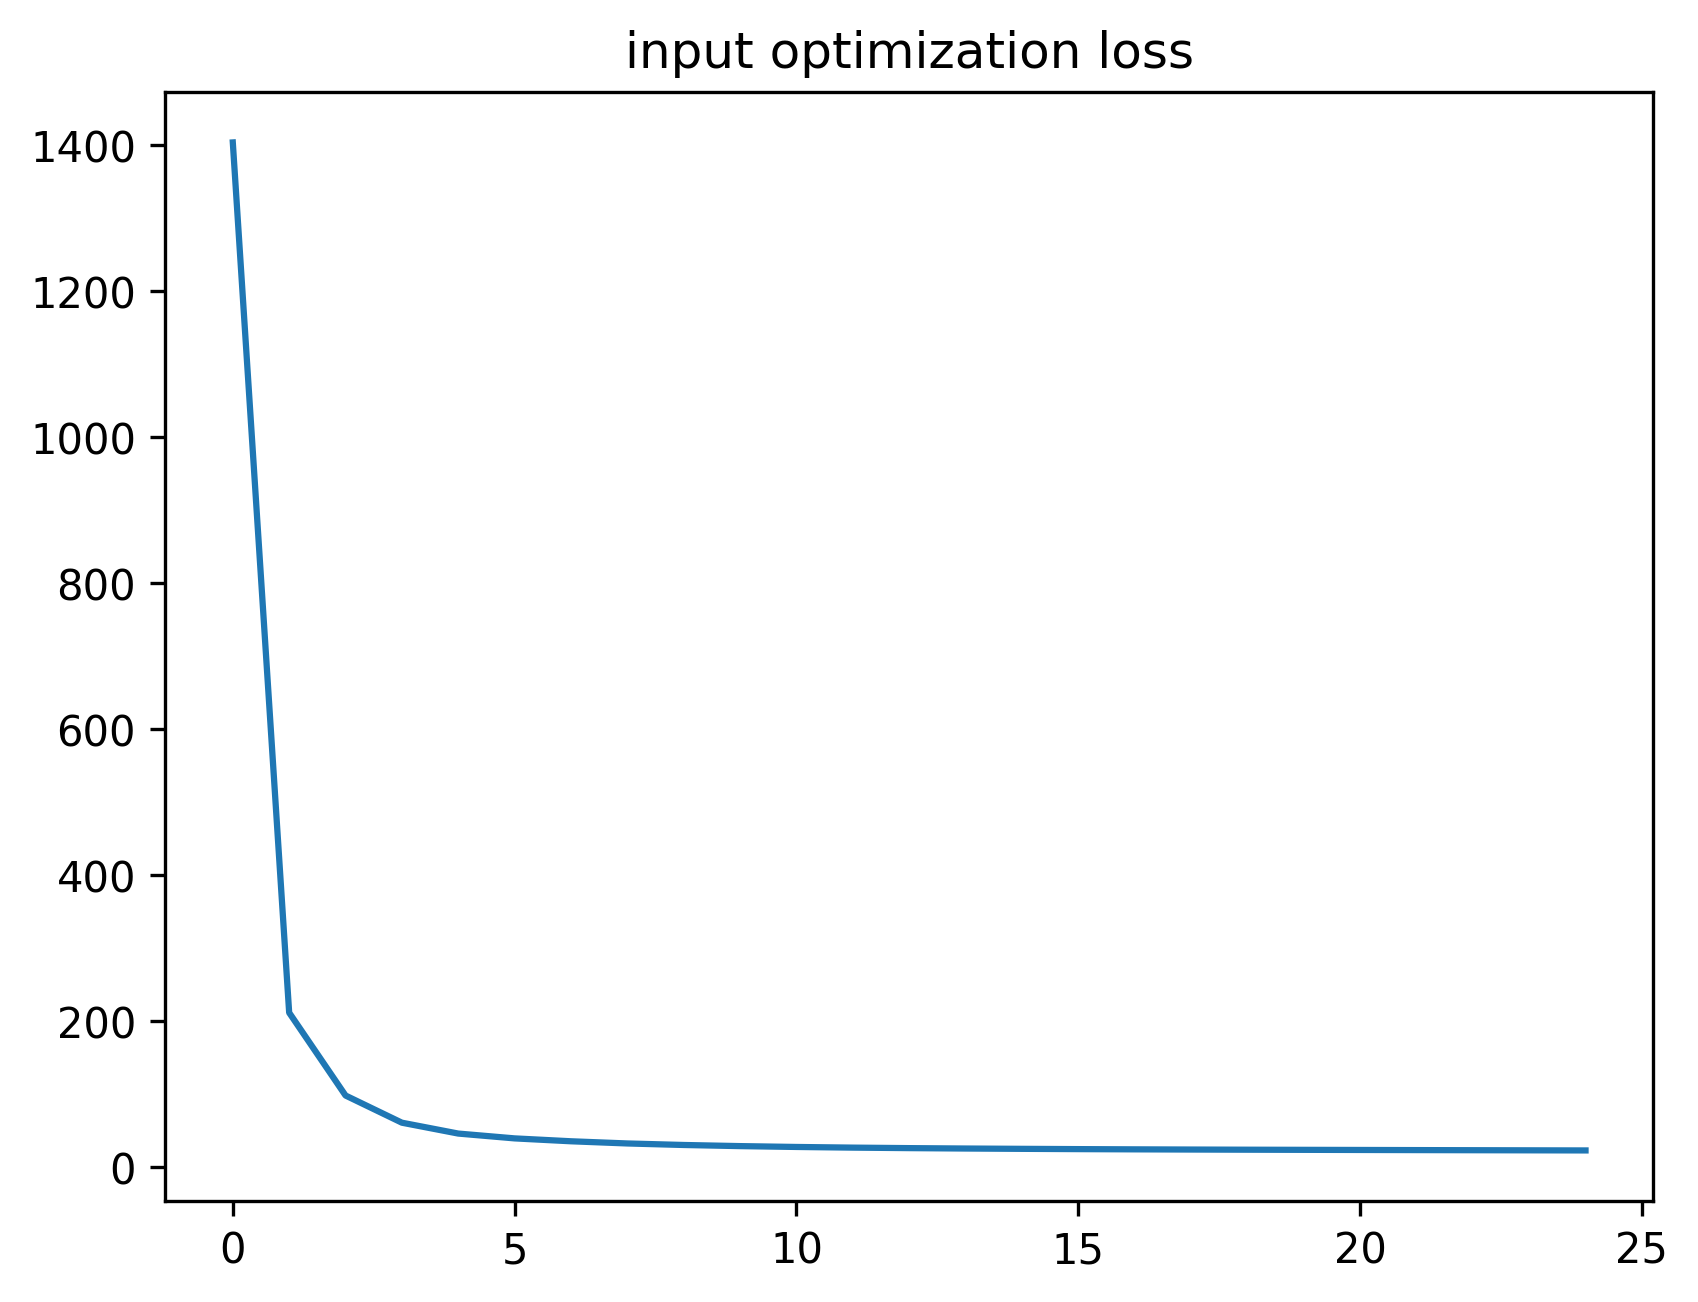

estimating, t = 100
estimating, t = 100


In [208]:
import importlib
import experiment_snn
import estimation_procedures as est
importlib.reload(experiment_snn)
importlib.reload(est)

exp_params = {
        "T": 101,
        "record_interval": 100,
        "est_type": ["ls"],
        "nuc_reg": 2,
        "max_on": 10,
        "mix_rand": True,
        "active_update_interval": 200,
        "type": "oracle",
        "plt_save": "./results_snn/",
        "no_diag": True,
        "inputs_r": 5
    }




fpr_p = None
tpr_p = None
fpr_a = None
tpr_a = None

n = 10
for t in range(n):
    env = SNN(Ncells=30, rank_dim=1, g=25, noise=1, leak=0.1, Catau=0.2, Itau=0.1, resetvoltage=0.1, threshold_voltage=10)
    exp_params["A_gt"] = env.W.copy()
    exp_params["type"] = "oracle"
    results_active = experiment_snn.run_experiment_helper(exp_params, env)
    env.reset()
    exp_params["type"] = "random"
    results_passive = experiment_snn.run_experiment_helper(exp_params, env)
    if fpr_p is None:
        fpr_ = results_passive['ls_roc'][0][0]
        tpr_ = results_passive['ls_roc'][0][1]
        fpr_p = fpr_ / n
        tpr_p = tpr_ / n
        
        fpr_ = results_active['ls_roc'][0][0]
        tpr_ = results_active['ls_roc'][0][1]
        fpr_a = fpr_ / n
        tpr_a = tpr_ / n
    else:
        fpr_ = results_passive['ls_roc'][0][0]
        tpr_ = results_passive['ls_roc'][0][1]
        fpr_p += fpr_ / n
        tpr_p += tpr_ / n
        
        fpr_ = results_active['ls_roc'][0][0]
        tpr_ = results_active['ls_roc'][0][1]
        fpr_a += fpr_ / n
        tpr_a += tpr_ / n

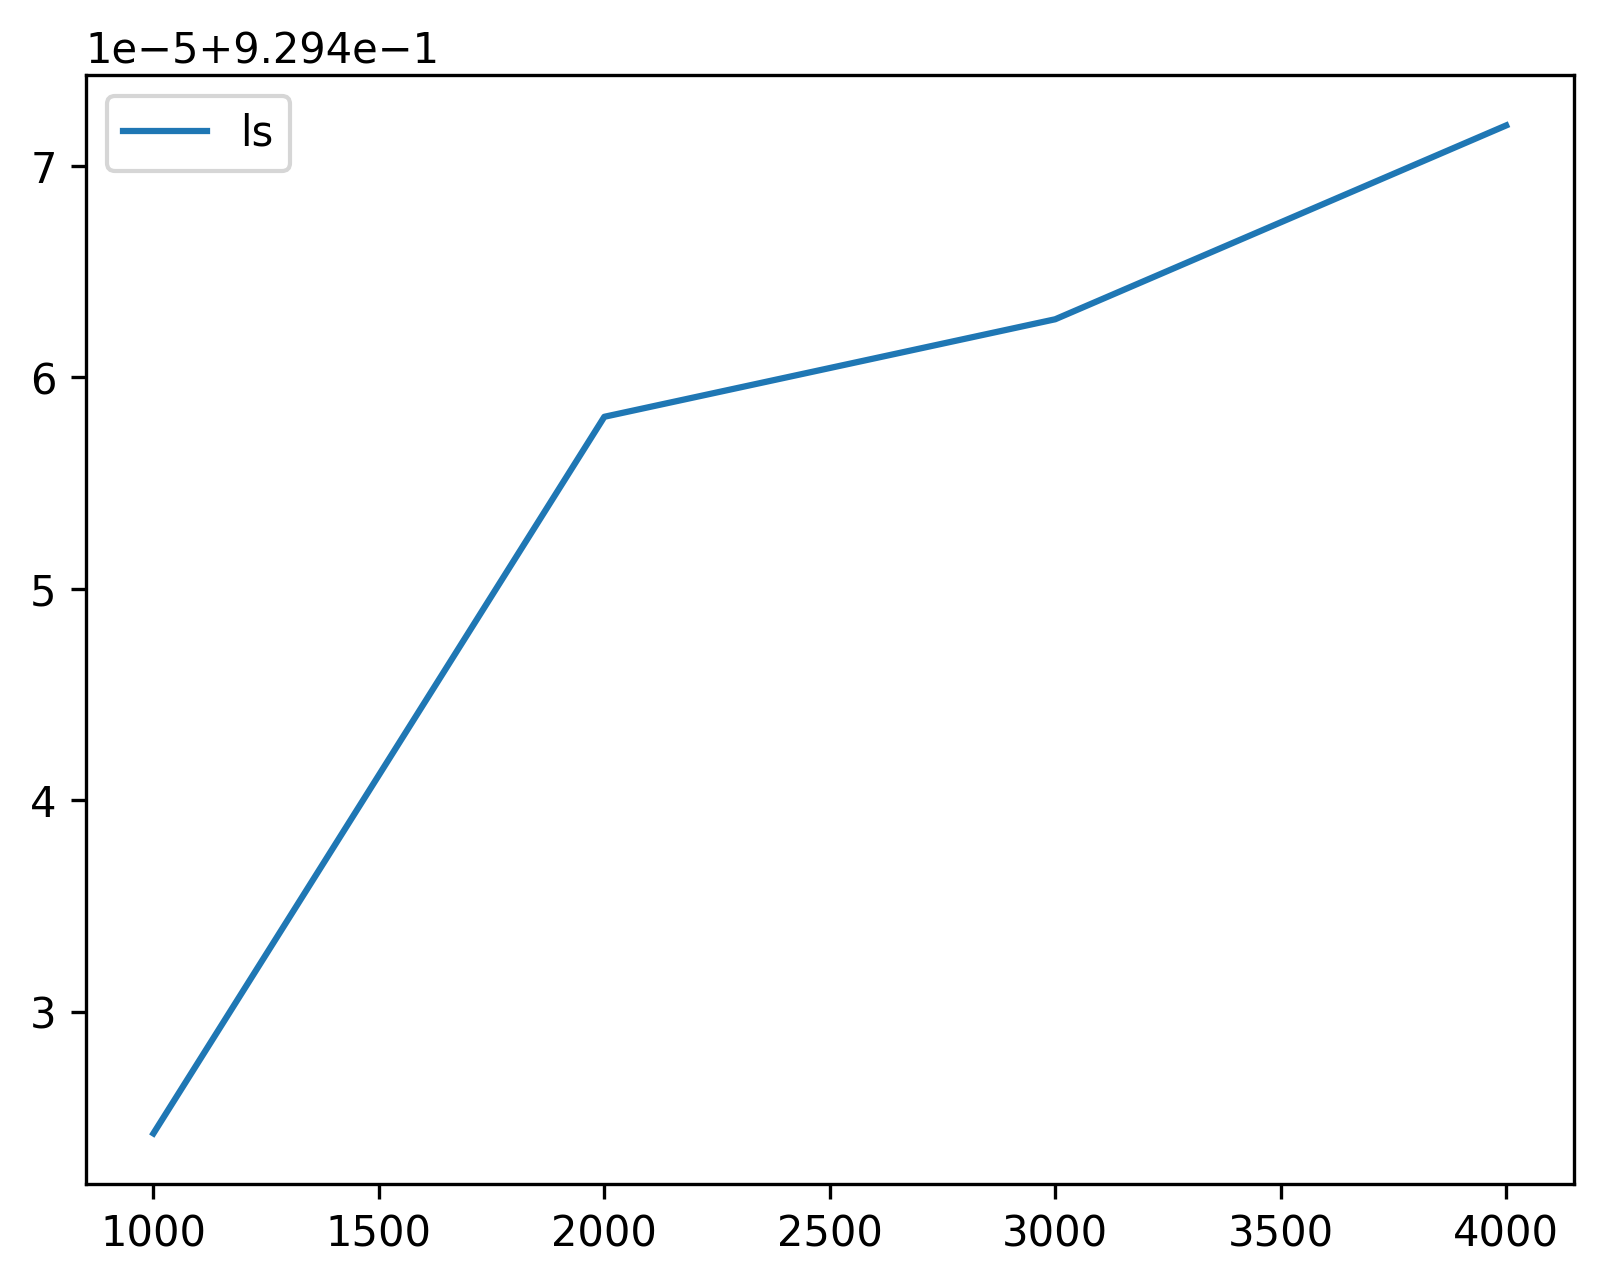

[0.9294242369882562, 0.9294581385497037, 0.929462752117135, 0.9294719209176371]


In [52]:
plt.plot(results['time'],results['ls_pred_error'],label='ls')
#plt.plot(results['time'],results['nuc_pred_error'],label='nuc')
plt.legend()
plt.show()
print(results['ls_pred_error'])

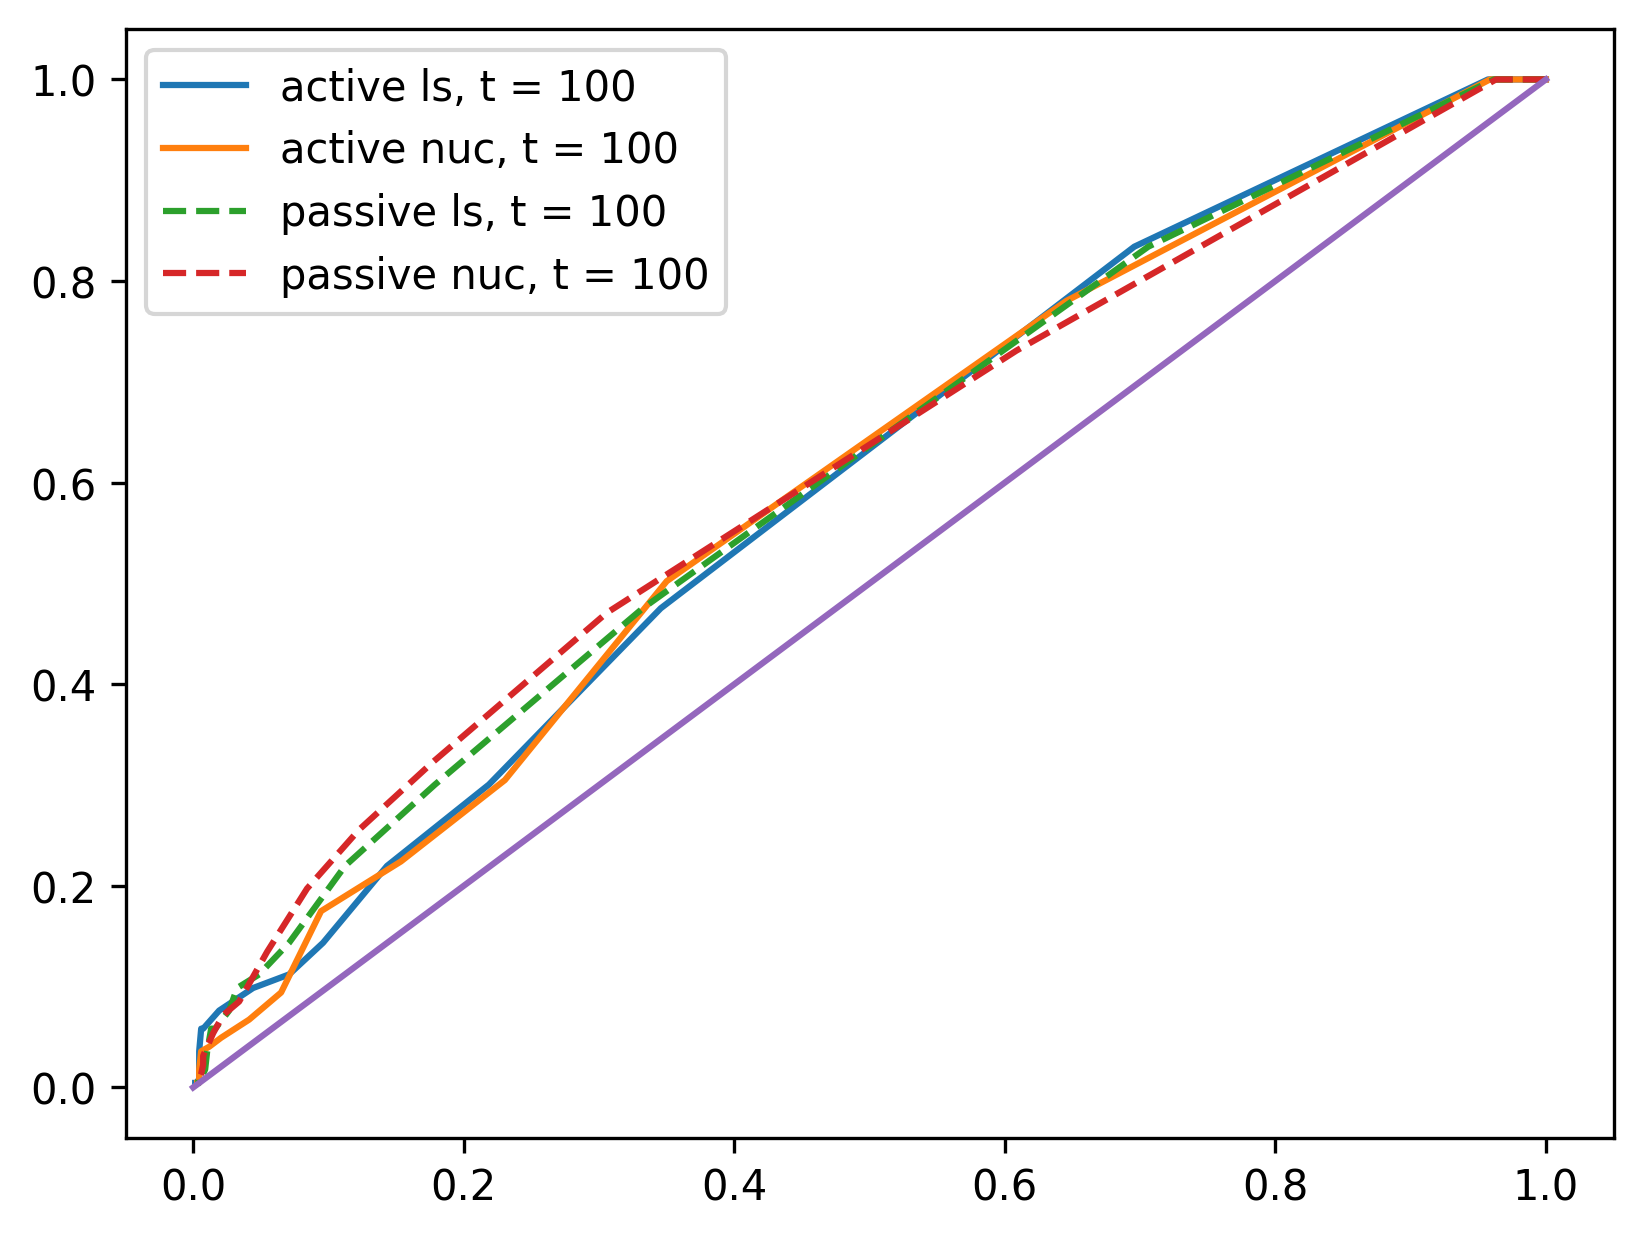

In [195]:
# plt.plot(results['ls_roc'][0][0], results['ls_roc'][0][1], label='t = 1000')
# plt.plot(results['ls_roc'][1][0], results['ls_roc'][1][1], label='t = 2000')
# plt.plot(results['ls_roc'][2][0], results['ls_roc'][2][1], label='t = 3000')
# plt.plot(results['ls_roc'][3][0], results['ls_roc'][3][1], label='t = 4000')

# for i in range(len(results['ls_roc'])):
#     t = results['time'][i]
#     plt.plot(results['ls_roc'][i][0], results['ls_roc'][i][1], label=f't = {t}')
for i in range(len(results_passive['ls_roc'])):
    t = results_passive['time'][i]
    plt.plot(results_active['ls_roc'][i][0], results_passive['ls_roc'][i][1],label=f'active ls, t = {t}')
    plt.plot(results_active['nuc_roc'][i][0], results_active['nuc_roc'][i][1],label=f'active nuc, t = {t}')

for i in range(len(results_passive['ls_roc'])):
    t = results_passive['time'][i]
    plt.plot(results_passive['ls_roc'][i][0], results_passive['ls_roc'][i][1],'--',label=f'passive ls, t = {t}')
    plt.plot(results_passive['nuc_roc'][i][0], results_passive['nuc_roc'][i][1],'--',label=f'passive nuc, t = {t}')
plt.plot([0,1],[0,1])
plt.legend()
plt.show()

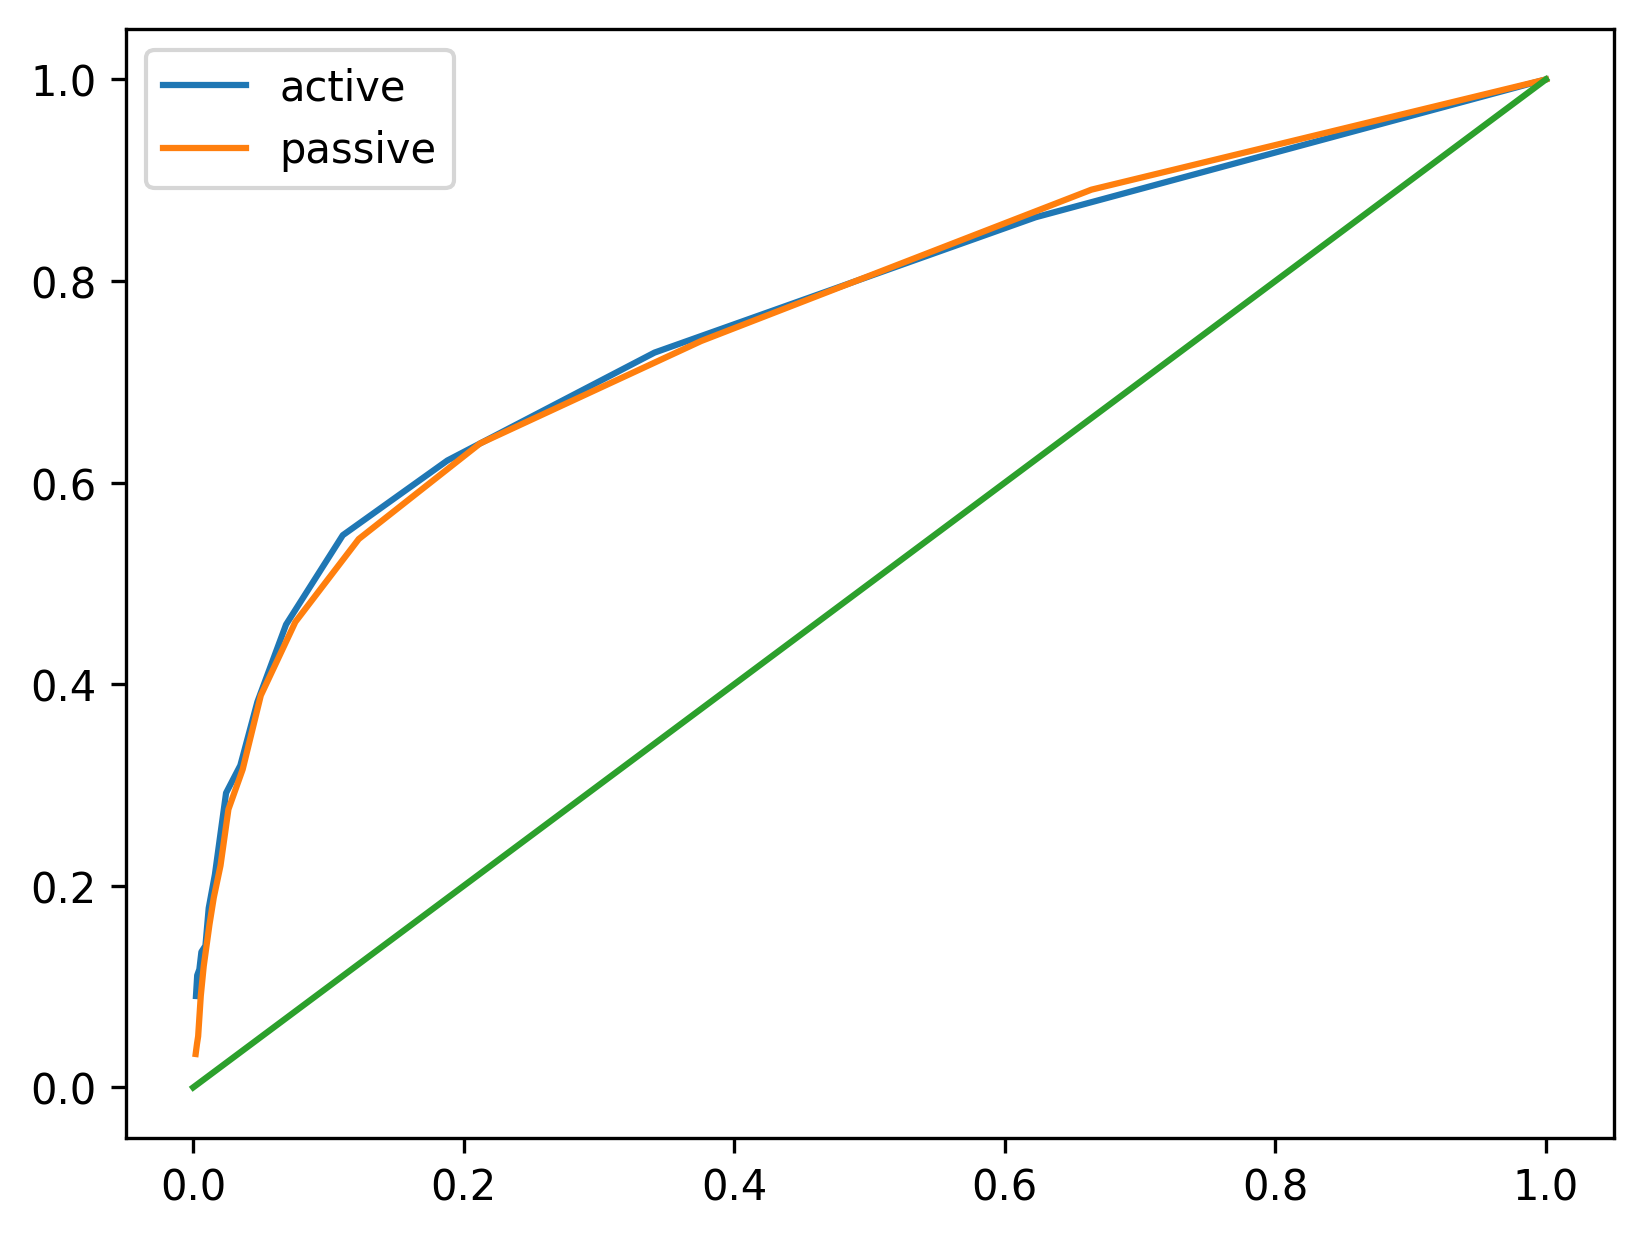

In [209]:
plt.plot(fpr_a,tpr_a,label='active')
plt.plot(fpr_p,tpr_p,label='passive')
plt.plot([0,1],[0,1])
plt.legend()
plt.show()